### Active Mini-Batch Stochastic Variational Inference

Authors: Sushil Bohara, Dequan Yang, Bishnu Dev

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torchvision import datasets, transforms
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm import tqdm
import time
import random
from collections import Counter
from sklearn.cluster import KMeans

# Set random seed for reproducibility
SEED = 42
pyro.set_rng_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data loading parameters
BATCH_SIZE = 128
TEST_BATCH_SIZE = 1000
DATA_DIR = './data'

# Model parameters
INPUT_SIZE = 28 * 28  # MNIST images are 28x28
OUTPUT_SIZE = 10      # 10 digit classes

# Training parameters
NUM_EPOCHS = 5
LEARNING_RATE = 0.01

# Active learning parameters
UNCERTAINTY_UPDATE_INTERVAL = 2  # Update uncertainty more frequently
ACTIVE_BATCH_SIZE = 128          # Size of active minibatch
WARM_UP_ITERATIONS = 200         # Longer warm-up with random sampling
EXPLORATION_RATIO_START = 0.7    # Start with more exploration
EXPLORATION_RATIO_END = 0.3      # End with more exploitation
MAX_ITERATIONS_TO_REUSE = 100    # Prevent reusing same samples too frequently


class OptimizedActiveDataset(Dataset):
    """
    Optimized dataset wrapper for active learning with MNIST
    """
    def __init__(self, dataset):
        self.dataset = dataset
        self.uncertainties = torch.zeros(len(dataset))
        self.sample_usage_counter = Counter()  # Track usage of samples
        self.update_required = True
        self.previously_selected = set()  # Track recently selected indices
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def update_uncertainties(self, uncertainties):
        """Update the uncertainty values for all samples"""
        assert len(uncertainties) == len(self.dataset), "Uncertainties must match dataset size"
        self.uncertainties = uncertainties
        self.update_required = False
    
    def get_stratified_batch_indices(self, batch_size):
        """
        Return indices with stratified sampling based on uncertainty:
        - Select from different uncertainty levels proportionally
        - Ensures diversity across uncertainty spectrum
        """
        if self.update_required:
            # If update is required but not performed, return random indices
            return torch.randperm(len(self.dataset))[:batch_size]
        
        # Divide samples into 5 uncertainty buckets (quintiles)
        _, sorted_indices = torch.sort(self.uncertainties)
        bucket_size = len(sorted_indices) // 5
        buckets = [
            sorted_indices[0:bucket_size],                    # Very certain
            sorted_indices[bucket_size:2*bucket_size],        # Somewhat certain
            sorted_indices[2*bucket_size:3*bucket_size],      # Medium certainty
            sorted_indices[3*bucket_size:4*bucket_size],      # Somewhat uncertain
            sorted_indices[4*bucket_size:],                   # Very uncertain
        ]
        
        # Sample from each bucket proportionally
        # More from higher uncertainty buckets, but some from all
        proportions = [0.1, 0.15, 0.2, 0.25, 0.3]  # Distribution across buckets
        
        selected_indices = []
        for i, bucket in enumerate(buckets):
            # Calculate how many samples to take from this bucket
            n_samples = int(batch_size * proportions[i])
            
            # Filter out recently used samples to reduce repetition
            available_indices = set(bucket.tolist()) - self.previously_selected
            if len(available_indices) < n_samples:  # Fall back if not enough
                available_indices = set(bucket.tolist())
                
            # Convert back to list and get a random sample
            available_indices = list(available_indices)
            if len(available_indices) > 0:
                bucket_indices = random.sample(
                    available_indices, 
                    min(n_samples, len(available_indices))
                )
                selected_indices.extend(bucket_indices)
                
                # Add to recently used set
                self.previously_selected.update(bucket_indices)
        
        # If we didn't get enough samples, fill with random ones
        if len(selected_indices) < batch_size:
            remaining = batch_size - len(selected_indices)
            available_indices = set(range(len(self.dataset))) - set(selected_indices) - self.previously_selected
            if len(available_indices) < remaining:
                available_indices = set(range(len(self.dataset))) - set(selected_indices)
            
            available_indices = list(available_indices)
            additional_indices = random.sample(
                available_indices, 
                min(remaining, len(available_indices))
            )
            selected_indices.extend(additional_indices)
            self.previously_selected.update(additional_indices)
        
        # Limit the size of previously_selected to prevent memory issues
        if len(self.previously_selected) > MAX_ITERATIONS_TO_REUSE:
            self.previously_selected = set(list(self.previously_selected)[-MAX_ITERATIONS_TO_REUSE:])
            
        # Ensure we have batch_size samples
        if len(selected_indices) > batch_size:
            selected_indices = selected_indices[:batch_size]
        elif len(selected_indices) < batch_size:
            # This should rarely happen, but just in case
            remaining = batch_size - len(selected_indices)
            selected_indices.extend(torch.randperm(len(self.dataset))[:remaining].tolist())
            
        # Track usage
        for idx in selected_indices:
            self.sample_usage_counter[idx] += 1
            
        return torch.tensor(selected_indices)
    
    def get_random_batch_indices(self, batch_size):
        """Return random indices for comparison"""
        indices = torch.randperm(len(self.dataset))[:batch_size].tolist()
        
        # Track usage
        for idx in indices:
            self.sample_usage_counter[idx] += 1
            
        return torch.tensor(indices)


class BayesianLogisticRegression(nn.Module):
    """
    Bayesian Logistic Regression model for MNIST classification.
    """
    def __init__(self, input_size, output_size):
        super(BayesianLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, INPUT_SIZE)
        # Apply linear transformation
        return self.linear(x)


def model(x_data, y_data=None):
    """
    Bayesian logistic regression model.
    """
    # Define priors
    weight_prior = dist.Normal(0., 1.).expand([OUTPUT_SIZE, INPUT_SIZE]).to_event(2)
    bias_prior = dist.Normal(0., 1.).expand([OUTPUT_SIZE]).to_event(1)
    
    # Sample from priors
    priors = {}
    priors['linear.weight'] = pyro.sample('linear.weight', weight_prior)
    priors['linear.bias'] = pyro.sample('linear.bias', bias_prior)
    
    # Forward pass
    x = x_data.view(-1, INPUT_SIZE)
    logits = torch.matmul(x, priors['linear.weight'].t()) + priors['linear.bias']
    
    # Sample y from the logistic model
    with pyro.plate('data', x.shape[0]):
        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y_data)
        
    return logits, obs


def guide(x_data, y_data=None):
    """
    Variational guide (posterior approximation) for the Bayesian logistic regression model.
    """
    # Define variational parameters
    # For the weight matrix
    w_loc = pyro.param('w_loc', torch.zeros(OUTPUT_SIZE, INPUT_SIZE).to(device))
    w_scale = pyro.param('w_scale', torch.ones(OUTPUT_SIZE, INPUT_SIZE).to(device),
                          constraint=dist.constraints.positive)
    
    # For the bias vector
    b_loc = pyro.param('b_loc', torch.zeros(OUTPUT_SIZE).to(device))
    b_scale = pyro.param('b_scale', torch.ones(OUTPUT_SIZE).to(device),
                         constraint=dist.constraints.positive)
    
    # Sample from variational distributions
    w = pyro.sample('linear.weight', dist.Normal(w_loc, w_scale).to_event(2))
    b = pyro.sample('linear.bias', dist.Normal(b_loc, b_scale).to_event(1))


def compute_bayesian_uncertainty(model, guide, x_data, num_samples=10, uncertainty_type='entropy'):
    """
    Compute uncertainty measures for each sample.
    
    Args:
        model: Bayesian model
        guide: Variational guide
        x_data: Input data tensor
        num_samples: Number of posterior samples to use
        uncertainty_type: Type of uncertainty measure to use
                         'entropy': predictive entropy
                         'bald': Bayesian Active Learning by Disagreement
                         'variation_ratio': 1 - max probability
    """
    all_probs = []
    
    # Obtain samples from the posterior
    for _ in range(num_samples):
        # Sample parameters from the guide
        guide_trace = poutine.trace(guide).get_trace(x_data)
        sampled_weights = guide_trace.nodes['linear.weight']['value']
        sampled_bias = guide_trace.nodes['linear.bias']['value']
        
        # Forward pass with sampled parameters
        with torch.no_grad():
            x = x_data.view(-1, INPUT_SIZE)
            logits = torch.matmul(x, sampled_weights.t()) + sampled_bias
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs)
    
    # Stack probabilities from all samples [num_samples, batch_size, num_classes]
    stacked_probs = torch.stack(all_probs)
    
    # Average probabilities across samples [batch_size, num_classes]
    mean_probs = stacked_probs.mean(0)
    
    if uncertainty_type == 'entropy':
        # Predictive entropy: -∑p*log(p)
        entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
        return entropy
        
    elif uncertainty_type == 'bald':
        # Bayesian Active Learning by Disagreement
        # BALD = H(y|x) - E_θ[H(y|x,θ)]
        
        # First term: entropy of the mean prediction (same as predictive entropy)
        H_mean = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
        
        # Second term: mean entropy of individual predictions
        sample_entropies = -torch.sum(stacked_probs * torch.log(stacked_probs + 1e-10), dim=2)
        mean_entropy = sample_entropies.mean(0)
        
        # BALD score
        bald = H_mean - mean_entropy
        return bald
        
    elif uncertainty_type == 'variation_ratio':
        # Variation ratio = 1 - max probability
        max_probs, _ = torch.max(mean_probs, dim=1)
        variation_ratio = 1.0 - max_probs
        return variation_ratio
    
    else:
        raise ValueError(f"Unknown uncertainty type: {uncertainty_type}")


def predict(model, guide, x, num_samples=10):
    """
    Make predictions with the trained model.
    """
    # Obtain samples from the posterior
    all_probs = []
    for _ in range(num_samples):
        # Sample parameters from the guide
        guide_trace = poutine.trace(guide).get_trace(x)
        sampled_weights = guide_trace.nodes['linear.weight']['value']
        sampled_bias = guide_trace.nodes['linear.bias']['value']
        
        # Forward pass with sampled parameters
        with torch.no_grad():
            x_flat = x.view(-1, INPUT_SIZE)
            logits = torch.matmul(x_flat, sampled_weights.t()) + sampled_bias
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs)
    
    # Average probabilities across samples
    mean_probs = torch.stack(all_probs).mean(0)
    _, predicted_class = torch.max(mean_probs, 1)
    
    return predicted_class, mean_probs


def evaluate(model, guide, test_loader):
    """
    Evaluate the model on test data.
    """
    correct = 0
    total = 0
    uncertainties = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            predicted_class, probs = predict(model, guide, data)
            
            # Calculate prediction entropy as uncertainty measure
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            uncertainties.extend(entropy.cpu().numpy())
            
            # Count correct predictions
            correct += (predicted_class == target).sum().item()
            total += target.size(0)
    
    accuracy = 100.0 * correct / total
    avg_uncertainty = np.mean(uncertainties)
    
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Average Uncertainty: {avg_uncertainty:.4f}')
    
    return accuracy, uncertainties


def train_with_optimized_active_minibatches(model, guide, active_dataset, optimizer, num_epochs, 
                                 batch_size=BATCH_SIZE, update_interval=UNCERTAINTY_UPDATE_INTERVAL,
                                 uncertainty_type='bald'):
    """
    Train the model using SVI with optimized active minibatch selection.
    """
    # Define SVI
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    # Training loop
    train_losses = []
    test_accuracies = []
    
    # Get all data to compute uncertainties when needed
    all_data = torch.stack([active_dataset[i][0] for i in range(len(active_dataset))]).to(device)
    all_labels = torch.tensor([active_dataset[i][1] for i in range(len(active_dataset))]).to(device)
    
    # Create test loader for evaluation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    test_dataset = datasets.MNIST(DATA_DIR, train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    # Evaluate model before training begins to establish a baseline
    print("\nEvaluating baseline model performance...")
    initial_accuracy, _ = evaluate(model, guide, test_loader)
    test_accuracies.append((0, initial_accuracy))
    
    total_iterations = num_epochs * (len(active_dataset) // batch_size)
    
    # Training iterations
    iteration = 0
    for epoch in range(num_epochs):
        # Initialize loss for this epoch
        epoch_loss = 0.0
        processed_batches = 0
        
        # Number of batches per epoch
        num_batches = len(active_dataset) // batch_size
        
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Initial warm-up phase with random batches
            if iteration < WARM_UP_ITERATIONS:
                batch_indices = active_dataset.get_random_batch_indices(batch_size)
            else:
                # Update uncertainties periodically
                if iteration % update_interval == 0 or active_dataset.update_required:
                    print("\nUpdating uncertainties...")
                    # Compute uncertainties for all samples using the specified method
                    uncertainties = compute_bayesian_uncertainty(
                        model, guide, all_data, 
                        num_samples=10, 
                        uncertainty_type=uncertainty_type
                    )
                    active_dataset.update_uncertainties(uncertainties.cpu())
                
                # Calculate adaptive exploration ratio based on training progress
                # Start with more exploration and gradually focus more on exploitation
                progress = min(1.0, (iteration - WARM_UP_ITERATIONS) / (total_iterations - WARM_UP_ITERATIONS))
                exploration_ratio = EXPLORATION_RATIO_START + progress * (EXPLORATION_RATIO_END - EXPLORATION_RATIO_START)
                
                # Get stratified batch indices
                batch_indices = active_dataset.get_stratified_batch_indices(batch_size)
            
            # Get batch data
            batch_data = all_data[batch_indices]
            batch_labels = all_labels[batch_indices]
            
            # Compute loss on this batch
            batch_loss = svi.step(batch_data, batch_labels)
            epoch_loss += batch_loss
            processed_batches += 1
            
            # Print intermediary results
            if batch_idx % 20 == 0:
                print(f'Batch {batch_idx}/{num_batches}, Loss: {batch_loss / batch_size:.6f}')
            
            # Track metrics consistently, including during warm-up phase
            if iteration % update_interval == 0:
                accuracy, _ = evaluate(model, guide, test_loader)
                test_accuracies.append((iteration, accuracy))
            
            iteration += 1
        
        # Calculate average loss over the epoch
        avg_epoch_loss = epoch_loss / (processed_batches * batch_size)
        train_losses.append(avg_epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}')
        
        # Evaluate model after each epoch
        accuracy, _ = evaluate(model, guide, test_loader)
        test_accuracies.append((iteration, accuracy))
    
    return train_losses, test_accuracies


def train_with_random_minibatches(model, guide, active_dataset, optimizer, num_epochs, batch_size=BATCH_SIZE):
    """
    Train the model using SVI with random minibatch selection (baseline).
    """
    # Define SVI
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    # Training loop
    train_losses = []
    test_accuracies = []
    
    # Get all data 
    all_data = torch.stack([active_dataset[i][0] for i in range(len(active_dataset))]).to(device)
    all_labels = torch.tensor([active_dataset[i][1] for i in range(len(active_dataset))]).to(device)
    
    # Create test loader for evaluation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    test_dataset = datasets.MNIST(DATA_DIR, train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    total_iterations = num_epochs * (len(active_dataset) // batch_size)
    
    # Training iterations
    iteration = 0
    for epoch in range(num_epochs):
        # Initialize loss for this epoch
        epoch_loss = 0.0
        processed_batches = 0
        
        # Number of batches per epoch
        num_batches = len(active_dataset) // batch_size
        
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Get random minibatch indices
            batch_indices = active_dataset.get_random_batch_indices(batch_size)
            
            # Get batch data
            batch_data = all_data[batch_indices]
            batch_labels = all_labels[batch_indices]
            
            # Compute loss on this batch
            batch_loss = svi.step(batch_data, batch_labels)
            epoch_loss += batch_loss
            processed_batches += 1
            
            # Print intermediary results
            if batch_idx % 20 == 0:
                print(f'Batch {batch_idx}/{num_batches}, Loss: {batch_loss / batch_size:.6f}')
            
            # For monitoring - compute test accuracy periodically
            if iteration % UNCERTAINTY_UPDATE_INTERVAL == 0 and iteration > 0:
                accuracy, _ = evaluate(model, guide, test_loader)
                test_accuracies.append((iteration, accuracy))
            
            iteration += 1
        
        # Calculate average loss over the epoch
        avg_epoch_loss = epoch_loss / (processed_batches * batch_size)
        train_losses.append(avg_epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}')
        
        # Evaluate model after each epoch
        accuracy, _ = evaluate(model, guide, test_loader)
        test_accuracies.append((iteration, accuracy))
        
    return train_losses, test_accuracies


/opt/anaconda3/envs/ML703/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# Define data transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
mnist_dataset = datasets.MNIST(DATA_DIR, train=True, download=True, transform=transform)

# Create active dataset wrapper
active_dataset = OptimizedActiveDataset(mnist_dataset)

print(f"Number of training examples: {len(active_dataset)}")

# Run comparison between optimized active and random sampling
print("\n==== Running Optimized Active Minibatch Selection ====")

# For optimized active minibatch selection
pyro.clear_param_store()
active_optimizer = Adam({"lr": LEARNING_RATE})
active_losses, active_accuracies = train_with_optimized_active_minibatches(
    model, guide, active_dataset, active_optimizer, NUM_EPOCHS, 
    batch_size=ACTIVE_BATCH_SIZE, update_interval=UNCERTAINTY_UPDATE_INTERVAL,
    uncertainty_type='bald'  # Use BALD measure for better performance
)

# Save active model
active_model_params = {name: param.data.clone() for name, param in pyro.get_param_store().items()}

# For random minibatch selection (baseline)
print("\n==== Running Random Minibatch Selection (Baseline) ====")
pyro.clear_param_store()
random_optimizer = Adam({"lr": LEARNING_RATE})
random_losses, random_accuracies = train_with_random_minibatches(
    model, guide, active_dataset, random_optimizer, NUM_EPOCHS, batch_size=ACTIVE_BATCH_SIZE
)

# Save random model
random_model_params = {name: param.data.clone() for name, param in pyro.get_param_store().items()}

Number of training examples: 60000

==== Running Optimized Active Minibatch Selection ====

Evaluating baseline model performance...
Test Accuracy: 10.42%
Average Uncertainty: 1.7991


Epoch 1/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 42.112514


Epoch 1/5:   0%|          | 1/468 [00:00<03:25,  2.27it/s]

Test Accuracy: 11.26%
Average Uncertainty: 1.8068


Epoch 1/5:   1%|          | 3/468 [00:00<02:02,  3.79it/s]

Test Accuracy: 14.31%
Average Uncertainty: 1.7920


Epoch 1/5:   1%|          | 5/468 [00:01<01:47,  4.30it/s]

Test Accuracy: 16.50%
Average Uncertainty: 1.7821


Epoch 1/5:   1%|▏         | 7/468 [00:01<01:47,  4.28it/s]

Test Accuracy: 18.91%
Average Uncertainty: 1.7567


Epoch 1/5:   2%|▏         | 9/468 [00:02<01:45,  4.36it/s]

Test Accuracy: 25.01%
Average Uncertainty: 1.7361


Epoch 1/5:   2%|▏         | 11/468 [00:02<01:41,  4.49it/s]

Test Accuracy: 25.61%
Average Uncertainty: 1.6842


Epoch 1/5:   3%|▎         | 13/468 [00:03<01:39,  4.59it/s]

Test Accuracy: 35.17%
Average Uncertainty: 1.6721


Epoch 1/5:   3%|▎         | 15/468 [00:03<01:35,  4.77it/s]

Test Accuracy: 37.47%
Average Uncertainty: 1.6736


Epoch 1/5:   4%|▎         | 17/468 [00:03<01:32,  4.89it/s]

Test Accuracy: 39.18%
Average Uncertainty: 1.6604


Epoch 1/5:   4%|▍         | 19/468 [00:04<01:30,  4.97it/s]

Test Accuracy: 44.54%
Average Uncertainty: 1.6214
Batch 20/468, Loss: 29.818589


Epoch 1/5:   4%|▍         | 21/468 [00:04<01:28,  5.05it/s]

Test Accuracy: 44.24%
Average Uncertainty: 1.6153


Epoch 1/5:   5%|▍         | 23/468 [00:04<01:27,  5.10it/s]

Test Accuracy: 48.27%
Average Uncertainty: 1.5726


Epoch 1/5:   5%|▌         | 25/468 [00:05<01:26,  5.14it/s]

Test Accuracy: 50.33%
Average Uncertainty: 1.5322


Epoch 1/5:   6%|▌         | 27/468 [00:05<01:26,  5.10it/s]

Test Accuracy: 50.75%
Average Uncertainty: 1.5206


Epoch 1/5:   6%|▌         | 29/468 [00:06<01:25,  5.12it/s]

Test Accuracy: 54.10%
Average Uncertainty: 1.4757


Epoch 1/5:   7%|▋         | 31/468 [00:06<01:25,  5.13it/s]

Test Accuracy: 56.13%
Average Uncertainty: 1.4551


Epoch 1/5:   7%|▋         | 33/468 [00:06<01:24,  5.15it/s]

Test Accuracy: 55.62%
Average Uncertainty: 1.4097


Epoch 1/5:   7%|▋         | 35/468 [00:07<01:24,  5.13it/s]

Test Accuracy: 57.70%
Average Uncertainty: 1.3793


Epoch 1/5:   8%|▊         | 37/468 [00:07<01:23,  5.15it/s]

Test Accuracy: 58.76%
Average Uncertainty: 1.3393


Epoch 1/5:   8%|▊         | 39/468 [00:08<01:22,  5.18it/s]

Test Accuracy: 58.31%
Average Uncertainty: 1.3277
Batch 40/468, Loss: 13.835775


Epoch 1/5:   9%|▉         | 41/468 [00:08<01:22,  5.19it/s]

Test Accuracy: 63.17%
Average Uncertainty: 1.3146


Epoch 1/5:   9%|▉         | 43/468 [00:08<01:21,  5.21it/s]

Test Accuracy: 63.71%
Average Uncertainty: 1.3105


Epoch 1/5:  10%|▉         | 45/468 [00:09<01:21,  5.21it/s]

Test Accuracy: 63.65%
Average Uncertainty: 1.2746


Epoch 1/5:  10%|█         | 47/468 [00:09<01:20,  5.21it/s]

Test Accuracy: 64.82%
Average Uncertainty: 1.2381


Epoch 1/5:  10%|█         | 49/468 [00:09<01:20,  5.21it/s]

Test Accuracy: 65.96%
Average Uncertainty: 1.2695


Epoch 1/5:  11%|█         | 51/468 [00:10<01:20,  5.18it/s]

Test Accuracy: 67.58%
Average Uncertainty: 1.2122


Epoch 1/5:  11%|█▏        | 53/468 [00:10<01:20,  5.17it/s]

Test Accuracy: 69.43%
Average Uncertainty: 1.2035


Epoch 1/5:  12%|█▏        | 55/468 [00:11<01:20,  5.14it/s]

Test Accuracy: 69.22%
Average Uncertainty: 1.1832


Epoch 1/5:  12%|█▏        | 57/468 [00:11<01:19,  5.15it/s]

Test Accuracy: 69.25%
Average Uncertainty: 1.1879


Epoch 1/5:  13%|█▎        | 59/468 [00:11<01:19,  5.17it/s]

Test Accuracy: 71.57%
Average Uncertainty: 1.1979
Batch 60/468, Loss: 15.668919


Epoch 1/5:  13%|█▎        | 61/468 [00:12<01:22,  4.93it/s]

Test Accuracy: 69.94%
Average Uncertainty: 1.1652


Epoch 1/5:  13%|█▎        | 63/468 [00:12<01:21,  4.97it/s]

Test Accuracy: 70.70%
Average Uncertainty: 1.1507


Epoch 1/5:  14%|█▍        | 65/468 [00:13<01:20,  5.04it/s]

Test Accuracy: 70.93%
Average Uncertainty: 1.1371


Epoch 1/5:  14%|█▍        | 67/468 [00:13<01:18,  5.08it/s]

Test Accuracy: 72.67%
Average Uncertainty: 1.1337


Epoch 1/5:  15%|█▍        | 69/468 [00:13<01:17,  5.12it/s]

Test Accuracy: 72.90%
Average Uncertainty: 1.1261


Epoch 1/5:  15%|█▌        | 71/468 [00:14<01:17,  5.15it/s]

Test Accuracy: 73.27%
Average Uncertainty: 1.1267


Epoch 1/5:  16%|█▌        | 73/468 [00:14<01:16,  5.16it/s]

Test Accuracy: 73.21%
Average Uncertainty: 1.0963


Epoch 1/5:  16%|█▌        | 75/468 [00:15<01:15,  5.17it/s]

Test Accuracy: 73.71%
Average Uncertainty: 1.0828


Epoch 1/5:  16%|█▋        | 77/468 [00:15<01:15,  5.19it/s]

Test Accuracy: 74.34%
Average Uncertainty: 1.0729


Epoch 1/5:  17%|█▋        | 79/468 [00:15<01:15,  5.17it/s]

Test Accuracy: 74.10%
Average Uncertainty: 1.0657
Batch 80/468, Loss: 17.859428


Epoch 1/5:  17%|█▋        | 81/468 [00:16<01:14,  5.18it/s]

Test Accuracy: 73.01%
Average Uncertainty: 1.0479


Epoch 1/5:  18%|█▊        | 83/468 [00:16<01:14,  5.19it/s]

Test Accuracy: 74.54%
Average Uncertainty: 1.0451


Epoch 1/5:  18%|█▊        | 85/468 [00:16<01:13,  5.20it/s]

Test Accuracy: 74.59%
Average Uncertainty: 1.0194


Epoch 1/5:  19%|█▊        | 87/468 [00:17<01:13,  5.19it/s]

Test Accuracy: 74.52%
Average Uncertainty: 1.0188


Epoch 1/5:  19%|█▉        | 89/468 [00:17<01:13,  5.19it/s]

Test Accuracy: 73.62%
Average Uncertainty: 1.0024


Epoch 1/5:  19%|█▉        | 91/468 [00:18<01:12,  5.21it/s]

Test Accuracy: 75.10%
Average Uncertainty: 0.9822


Epoch 1/5:  20%|█▉        | 93/468 [00:18<01:12,  5.20it/s]

Test Accuracy: 74.60%
Average Uncertainty: 0.9904


Epoch 1/5:  20%|██        | 95/468 [00:18<01:12,  5.16it/s]

Test Accuracy: 75.84%
Average Uncertainty: 0.9859


Epoch 1/5:  21%|██        | 97/468 [00:19<01:11,  5.18it/s]

Test Accuracy: 74.70%
Average Uncertainty: 0.9814


Epoch 1/5:  21%|██        | 99/468 [00:19<01:11,  5.18it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.9587
Batch 100/468, Loss: 15.226512


Epoch 1/5:  22%|██▏       | 101/468 [00:20<01:10,  5.19it/s]

Test Accuracy: 77.25%
Average Uncertainty: 0.9410


Epoch 1/5:  22%|██▏       | 103/468 [00:20<01:10,  5.20it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.9481


Epoch 1/5:  22%|██▏       | 105/468 [00:20<01:09,  5.20it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.9265


Epoch 1/5:  23%|██▎       | 107/468 [00:21<01:09,  5.20it/s]

Test Accuracy: 77.67%
Average Uncertainty: 0.9109


Epoch 1/5:  23%|██▎       | 109/468 [00:21<01:09,  5.20it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.9142


Epoch 1/5:  24%|██▎       | 111/468 [00:21<01:08,  5.20it/s]

Test Accuracy: 78.28%
Average Uncertainty: 0.9048


Epoch 1/5:  24%|██▍       | 113/468 [00:22<01:08,  5.21it/s]

Test Accuracy: 78.79%
Average Uncertainty: 0.8920


Epoch 1/5:  25%|██▍       | 115/468 [00:22<01:10,  4.98it/s]

Test Accuracy: 79.98%
Average Uncertainty: 0.8794


Epoch 1/5:  25%|██▌       | 117/468 [00:23<01:09,  5.05it/s]

Test Accuracy: 79.16%
Average Uncertainty: 0.9062


Epoch 1/5:  25%|██▌       | 119/468 [00:23<01:08,  5.11it/s]

Test Accuracy: 80.07%
Average Uncertainty: 0.8936
Batch 120/468, Loss: 8.757198


Epoch 1/5:  26%|██▌       | 121/468 [00:23<01:07,  5.14it/s]

Test Accuracy: 80.15%
Average Uncertainty: 0.8562


Epoch 1/5:  26%|██▋       | 123/468 [00:24<01:06,  5.17it/s]

Test Accuracy: 79.34%
Average Uncertainty: 0.8805


Epoch 1/5:  27%|██▋       | 125/468 [00:24<01:06,  5.13it/s]

Test Accuracy: 78.99%
Average Uncertainty: 0.8453


Epoch 1/5:  27%|██▋       | 127/468 [00:25<01:06,  5.15it/s]

Test Accuracy: 79.43%
Average Uncertainty: 0.8455


Epoch 1/5:  28%|██▊       | 129/468 [00:25<01:05,  5.18it/s]

Test Accuracy: 79.87%
Average Uncertainty: 0.8381


Epoch 1/5:  28%|██▊       | 131/468 [00:25<01:04,  5.19it/s]

Test Accuracy: 81.03%
Average Uncertainty: 0.8374


Epoch 1/5:  28%|██▊       | 133/468 [00:26<01:04,  5.20it/s]

Test Accuracy: 80.63%
Average Uncertainty: 0.8637


Epoch 1/5:  29%|██▉       | 135/468 [00:26<01:05,  5.11it/s]

Test Accuracy: 80.13%
Average Uncertainty: 0.8509


Epoch 1/5:  29%|██▉       | 137/468 [00:27<01:04,  5.13it/s]

Test Accuracy: 80.92%
Average Uncertainty: 0.8547


Epoch 1/5:  30%|██▉       | 139/468 [00:27<01:03,  5.16it/s]

Test Accuracy: 81.43%
Average Uncertainty: 0.8539
Batch 140/468, Loss: 11.610632


Epoch 1/5:  30%|███       | 141/468 [00:27<01:03,  5.16it/s]

Test Accuracy: 81.35%
Average Uncertainty: 0.8475


Epoch 1/5:  31%|███       | 143/468 [00:28<01:02,  5.17it/s]

Test Accuracy: 81.40%
Average Uncertainty: 0.8403


Epoch 1/5:  31%|███       | 145/468 [00:28<01:02,  5.18it/s]

Test Accuracy: 80.90%
Average Uncertainty: 0.8446


Epoch 1/5:  31%|███▏      | 147/468 [00:28<01:01,  5.19it/s]

Test Accuracy: 81.49%
Average Uncertainty: 0.8278


Epoch 1/5:  32%|███▏      | 149/468 [00:29<01:01,  5.20it/s]

Test Accuracy: 81.74%
Average Uncertainty: 0.8123


Epoch 1/5:  32%|███▏      | 151/468 [00:29<01:00,  5.21it/s]

Test Accuracy: 81.35%
Average Uncertainty: 0.8019


Epoch 1/5:  33%|███▎      | 153/468 [00:30<01:01,  5.12it/s]

Test Accuracy: 81.57%
Average Uncertainty: 0.8252


Epoch 1/5:  33%|███▎      | 155/468 [00:30<01:01,  5.12it/s]

Test Accuracy: 81.83%
Average Uncertainty: 0.8117


Epoch 1/5:  34%|███▎      | 157/468 [00:30<01:00,  5.15it/s]

Test Accuracy: 81.65%
Average Uncertainty: 0.7766


Epoch 1/5:  34%|███▍      | 159/468 [00:31<00:59,  5.17it/s]

Test Accuracy: 81.82%
Average Uncertainty: 0.7850
Batch 160/468, Loss: 15.650535


Epoch 1/5:  34%|███▍      | 161/468 [00:31<00:59,  5.19it/s]

Test Accuracy: 82.07%
Average Uncertainty: 0.7926


Epoch 1/5:  35%|███▍      | 163/468 [00:32<00:58,  5.19it/s]

Test Accuracy: 81.93%
Average Uncertainty: 0.7733


Epoch 1/5:  35%|███▌      | 165/468 [00:32<00:58,  5.20it/s]

Test Accuracy: 80.89%
Average Uncertainty: 0.7764


Epoch 1/5:  36%|███▌      | 167/468 [00:32<00:57,  5.20it/s]

Test Accuracy: 80.93%
Average Uncertainty: 0.7448


Epoch 1/5:  36%|███▌      | 169/468 [00:33<01:00,  4.95it/s]

Test Accuracy: 80.86%
Average Uncertainty: 0.7551


Epoch 1/5:  37%|███▋      | 171/468 [00:33<00:59,  5.02it/s]

Test Accuracy: 79.63%
Average Uncertainty: 0.7420


Epoch 1/5:  37%|███▋      | 173/468 [00:34<00:58,  5.07it/s]

Test Accuracy: 79.80%
Average Uncertainty: 0.7190


Epoch 1/5:  37%|███▋      | 175/468 [00:34<00:57,  5.12it/s]

Test Accuracy: 79.27%
Average Uncertainty: 0.7218


Epoch 1/5:  38%|███▊      | 177/468 [00:34<00:56,  5.14it/s]

Test Accuracy: 81.19%
Average Uncertainty: 0.7227


Epoch 1/5:  38%|███▊      | 179/468 [00:35<00:56,  5.16it/s]

Test Accuracy: 80.12%
Average Uncertainty: 0.7069
Batch 180/468, Loss: 13.384505


Epoch 1/5:  39%|███▊      | 181/468 [00:35<00:55,  5.18it/s]

Test Accuracy: 81.48%
Average Uncertainty: 0.7440


Epoch 1/5:  39%|███▉      | 183/468 [00:35<00:55,  5.15it/s]

Test Accuracy: 82.68%
Average Uncertainty: 0.7340


Epoch 1/5:  40%|███▉      | 185/468 [00:36<00:54,  5.16it/s]

Test Accuracy: 83.31%
Average Uncertainty: 0.7228


Epoch 1/5:  40%|███▉      | 187/468 [00:36<00:54,  5.17it/s]

Test Accuracy: 82.45%
Average Uncertainty: 0.7241


Epoch 1/5:  40%|████      | 189/468 [00:37<00:53,  5.18it/s]

Test Accuracy: 81.81%
Average Uncertainty: 0.7402


Epoch 1/5:  41%|████      | 191/468 [00:37<00:53,  5.17it/s]

Test Accuracy: 82.28%
Average Uncertainty: 0.7265


Epoch 1/5:  41%|████      | 193/468 [00:37<00:53,  5.17it/s]

Test Accuracy: 82.12%
Average Uncertainty: 0.7281


Epoch 1/5:  42%|████▏     | 195/468 [00:38<00:52,  5.19it/s]

Test Accuracy: 81.97%
Average Uncertainty: 0.7192


Epoch 1/5:  42%|████▏     | 197/468 [00:38<00:52,  5.20it/s]

Test Accuracy: 83.63%
Average Uncertainty: 0.7300


Epoch 1/5:  43%|████▎     | 199/468 [00:39<00:51,  5.19it/s]

Test Accuracy: 83.51%
Average Uncertainty: 0.7354

Updating uncertainties...
Batch 200/468, Loss: 10.756853


Epoch 1/5:  43%|████▎     | 201/468 [00:39<00:55,  4.82it/s]

Test Accuracy: 83.64%
Average Uncertainty: 0.7238

Updating uncertainties...


Epoch 1/5:  43%|████▎     | 203/468 [00:40<00:57,  4.58it/s]

Test Accuracy: 83.41%
Average Uncertainty: 0.7000

Updating uncertainties...


Epoch 1/5:  44%|████▍     | 205/468 [00:40<00:59,  4.44it/s]

Test Accuracy: 82.47%
Average Uncertainty: 0.7351

Updating uncertainties...


Epoch 1/5:  44%|████▍     | 207/468 [00:41<01:00,  4.33it/s]

Test Accuracy: 82.37%
Average Uncertainty: 0.7128

Updating uncertainties...


Epoch 1/5:  45%|████▍     | 209/468 [00:41<01:01,  4.24it/s]

Test Accuracy: 83.45%
Average Uncertainty: 0.7123

Updating uncertainties...


Epoch 1/5:  45%|████▌     | 211/468 [00:41<01:01,  4.21it/s]

Test Accuracy: 82.29%
Average Uncertainty: 0.6987

Updating uncertainties...


Epoch 1/5:  46%|████▌     | 213/468 [00:42<01:00,  4.18it/s]

Test Accuracy: 82.97%
Average Uncertainty: 0.7029

Updating uncertainties...


Epoch 1/5:  46%|████▌     | 215/468 [00:42<01:00,  4.16it/s]

Test Accuracy: 83.10%
Average Uncertainty: 0.7105

Updating uncertainties...


Epoch 1/5:  46%|████▋     | 217/468 [00:43<01:00,  4.15it/s]

Test Accuracy: 83.58%
Average Uncertainty: 0.6991

Updating uncertainties...


Epoch 1/5:  47%|████▋     | 219/468 [00:43<01:00,  4.13it/s]

Test Accuracy: 84.52%
Average Uncertainty: 0.7038

Updating uncertainties...
Batch 220/468, Loss: 17.012909


Epoch 1/5:  47%|████▋     | 221/468 [00:44<00:59,  4.12it/s]

Test Accuracy: 84.46%
Average Uncertainty: 0.7058

Updating uncertainties...


Epoch 1/5:  48%|████▊     | 223/468 [00:44<01:01,  3.96it/s]

Test Accuracy: 83.67%
Average Uncertainty: 0.6963

Updating uncertainties...


Epoch 1/5:  48%|████▊     | 225/468 [00:45<01:00,  3.99it/s]

Test Accuracy: 84.02%
Average Uncertainty: 0.7111

Updating uncertainties...


Epoch 1/5:  49%|████▊     | 227/468 [00:45<00:59,  4.02it/s]

Test Accuracy: 84.56%
Average Uncertainty: 0.6784

Updating uncertainties...


Epoch 1/5:  49%|████▉     | 229/468 [00:46<00:59,  4.02it/s]

Test Accuracy: 84.41%
Average Uncertainty: 0.7021

Updating uncertainties...


Epoch 1/5:  49%|████▉     | 231/468 [00:46<00:58,  4.05it/s]

Test Accuracy: 85.17%
Average Uncertainty: 0.6688

Updating uncertainties...


Epoch 1/5:  50%|████▉     | 233/468 [00:47<00:58,  4.05it/s]

Test Accuracy: 84.90%
Average Uncertainty: 0.6706

Updating uncertainties...


Epoch 1/5:  50%|█████     | 235/468 [00:47<00:57,  4.07it/s]

Test Accuracy: 84.80%
Average Uncertainty: 0.6630

Updating uncertainties...


Epoch 1/5:  51%|█████     | 237/468 [00:48<00:57,  4.00it/s]

Test Accuracy: 84.36%
Average Uncertainty: 0.6668

Updating uncertainties...


Epoch 1/5:  51%|█████     | 239/468 [00:48<00:56,  4.03it/s]

Test Accuracy: 84.57%
Average Uncertainty: 0.6466

Updating uncertainties...
Batch 240/468, Loss: 13.431494


Epoch 1/5:  51%|█████▏    | 241/468 [00:49<00:56,  4.05it/s]

Test Accuracy: 84.30%
Average Uncertainty: 0.6629

Updating uncertainties...


Epoch 1/5:  52%|█████▏    | 243/468 [00:49<00:55,  4.06it/s]

Test Accuracy: 84.77%
Average Uncertainty: 0.6427

Updating uncertainties...


Epoch 1/5:  52%|█████▏    | 245/468 [00:50<00:54,  4.07it/s]

Test Accuracy: 84.47%
Average Uncertainty: 0.6532

Updating uncertainties...


Epoch 1/5:  53%|█████▎    | 247/468 [00:50<00:54,  4.08it/s]

Test Accuracy: 85.07%
Average Uncertainty: 0.6585

Updating uncertainties...


Epoch 1/5:  53%|█████▎    | 249/468 [00:51<00:53,  4.08it/s]

Test Accuracy: 85.26%
Average Uncertainty: 0.6703

Updating uncertainties...


Epoch 1/5:  54%|█████▎    | 251/468 [00:51<00:53,  4.08it/s]

Test Accuracy: 84.61%
Average Uncertainty: 0.6560

Updating uncertainties...


Epoch 1/5:  54%|█████▍    | 253/468 [00:52<00:52,  4.09it/s]

Test Accuracy: 84.51%
Average Uncertainty: 0.6632

Updating uncertainties...


Epoch 1/5:  54%|█████▍    | 255/468 [00:52<00:52,  4.09it/s]

Test Accuracy: 84.45%
Average Uncertainty: 0.6445

Updating uncertainties...


Epoch 1/5:  55%|█████▍    | 257/468 [00:53<00:51,  4.09it/s]

Test Accuracy: 84.42%
Average Uncertainty: 0.6472

Updating uncertainties...


Epoch 1/5:  55%|█████▌    | 259/468 [00:53<00:51,  4.09it/s]

Test Accuracy: 83.97%
Average Uncertainty: 0.6363

Updating uncertainties...
Batch 260/468, Loss: 15.787621


Epoch 1/5:  56%|█████▌    | 261/468 [00:54<00:50,  4.09it/s]

Test Accuracy: 84.17%
Average Uncertainty: 0.6527

Updating uncertainties...


Epoch 1/5:  56%|█████▌    | 263/468 [00:54<00:50,  4.10it/s]

Test Accuracy: 84.33%
Average Uncertainty: 0.6536

Updating uncertainties...


Epoch 1/5:  57%|█████▋    | 265/468 [00:55<00:50,  4.06it/s]

Test Accuracy: 84.89%
Average Uncertainty: 0.6501

Updating uncertainties...


Epoch 1/5:  57%|█████▋    | 267/468 [00:55<00:49,  4.06it/s]

Test Accuracy: 86.07%
Average Uncertainty: 0.6373

Updating uncertainties...


Epoch 1/5:  57%|█████▋    | 269/468 [00:56<00:48,  4.07it/s]

Test Accuracy: 85.72%
Average Uncertainty: 0.6339

Updating uncertainties...


Epoch 1/5:  58%|█████▊    | 271/468 [00:56<00:48,  4.08it/s]

Test Accuracy: 85.45%
Average Uncertainty: 0.6320

Updating uncertainties...


Epoch 1/5:  58%|█████▊    | 273/468 [00:57<00:47,  4.08it/s]

Test Accuracy: 85.48%
Average Uncertainty: 0.6357

Updating uncertainties...


Epoch 1/5:  59%|█████▉    | 275/468 [00:57<00:47,  4.08it/s]

Test Accuracy: 86.01%
Average Uncertainty: 0.6401

Updating uncertainties...


Epoch 1/5:  59%|█████▉    | 277/468 [00:58<00:46,  4.07it/s]

Test Accuracy: 85.55%
Average Uncertainty: 0.6377

Updating uncertainties...


Epoch 1/5:  60%|█████▉    | 279/468 [00:58<00:46,  4.08it/s]

Test Accuracy: 85.10%
Average Uncertainty: 0.6240

Updating uncertainties...
Batch 280/468, Loss: 14.478928


Epoch 1/5:  60%|██████    | 281/468 [00:59<00:45,  4.08it/s]

Test Accuracy: 85.38%
Average Uncertainty: 0.6312

Updating uncertainties...


Epoch 1/5:  60%|██████    | 283/468 [00:59<00:45,  4.09it/s]

Test Accuracy: 85.18%
Average Uncertainty: 0.6109

Updating uncertainties...


Epoch 1/5:  61%|██████    | 285/468 [01:00<00:44,  4.08it/s]

Test Accuracy: 85.76%
Average Uncertainty: 0.6294

Updating uncertainties...


Epoch 1/5:  61%|██████▏   | 287/468 [01:00<00:44,  4.09it/s]

Test Accuracy: 84.67%
Average Uncertainty: 0.6327

Updating uncertainties...


Epoch 1/5:  62%|██████▏   | 289/468 [01:01<00:43,  4.09it/s]

Test Accuracy: 84.52%
Average Uncertainty: 0.6413

Updating uncertainties...


Epoch 1/5:  62%|██████▏   | 291/468 [01:01<00:43,  4.07it/s]

Test Accuracy: 84.80%
Average Uncertainty: 0.6201

Updating uncertainties...


Epoch 1/5:  63%|██████▎   | 293/468 [01:02<00:42,  4.07it/s]

Test Accuracy: 84.06%
Average Uncertainty: 0.6150

Updating uncertainties...


Epoch 1/5:  63%|██████▎   | 295/468 [01:02<00:42,  4.07it/s]

Test Accuracy: 84.61%
Average Uncertainty: 0.5940

Updating uncertainties...


Epoch 1/5:  63%|██████▎   | 297/468 [01:03<00:41,  4.08it/s]

Test Accuracy: 85.43%
Average Uncertainty: 0.6169

Updating uncertainties...


Epoch 1/5:  64%|██████▍   | 299/468 [01:03<00:41,  4.08it/s]

Test Accuracy: 84.95%
Average Uncertainty: 0.6283

Updating uncertainties...
Batch 300/468, Loss: 13.671352


Epoch 1/5:  64%|██████▍   | 301/468 [01:04<00:40,  4.08it/s]

Test Accuracy: 85.03%
Average Uncertainty: 0.6306

Updating uncertainties...


Epoch 1/5:  65%|██████▍   | 303/468 [01:04<00:40,  4.08it/s]

Test Accuracy: 85.44%
Average Uncertainty: 0.6193

Updating uncertainties...


Epoch 1/5:  65%|██████▌   | 305/468 [01:05<00:39,  4.08it/s]

Test Accuracy: 85.74%
Average Uncertainty: 0.6281

Updating uncertainties...


Epoch 1/5:  66%|██████▌   | 307/468 [01:05<00:39,  4.08it/s]

Test Accuracy: 85.15%
Average Uncertainty: 0.6264

Updating uncertainties...


Epoch 1/5:  66%|██████▌   | 309/468 [01:06<00:38,  4.08it/s]

Test Accuracy: 85.37%
Average Uncertainty: 0.6268

Updating uncertainties...


Epoch 1/5:  66%|██████▋   | 311/468 [01:06<00:38,  4.08it/s]

Test Accuracy: 85.39%
Average Uncertainty: 0.6291

Updating uncertainties...


Epoch 1/5:  67%|██████▋   | 313/468 [01:07<00:38,  4.08it/s]

Test Accuracy: 84.59%
Average Uncertainty: 0.6205

Updating uncertainties...


Epoch 1/5:  67%|██████▋   | 315/468 [01:07<00:38,  3.94it/s]

Test Accuracy: 85.09%
Average Uncertainty: 0.6016

Updating uncertainties...


Epoch 1/5:  68%|██████▊   | 317/468 [01:08<00:38,  3.94it/s]

Test Accuracy: 85.00%
Average Uncertainty: 0.6032

Updating uncertainties...


Epoch 1/5:  68%|██████▊   | 319/468 [01:08<00:37,  3.98it/s]

Test Accuracy: 85.08%
Average Uncertainty: 0.6077

Updating uncertainties...
Batch 320/468, Loss: 17.122522


Epoch 1/5:  69%|██████▊   | 321/468 [01:09<00:36,  4.01it/s]

Test Accuracy: 86.33%
Average Uncertainty: 0.6134

Updating uncertainties...


Epoch 1/5:  69%|██████▉   | 323/468 [01:09<00:35,  4.03it/s]

Test Accuracy: 86.14%
Average Uncertainty: 0.5854

Updating uncertainties...


Epoch 1/5:  69%|██████▉   | 325/468 [01:10<00:35,  4.05it/s]

Test Accuracy: 86.29%
Average Uncertainty: 0.6292

Updating uncertainties...


Epoch 1/5:  70%|██████▉   | 327/468 [01:10<00:34,  4.06it/s]

Test Accuracy: 86.53%
Average Uncertainty: 0.6223

Updating uncertainties...


Epoch 1/5:  70%|███████   | 329/468 [01:11<00:34,  4.06it/s]

Test Accuracy: 85.55%
Average Uncertainty: 0.5917

Updating uncertainties...


Epoch 1/5:  71%|███████   | 331/468 [01:11<00:33,  4.06it/s]

Test Accuracy: 86.11%
Average Uncertainty: 0.5917

Updating uncertainties...


Epoch 1/5:  71%|███████   | 333/468 [01:12<00:33,  4.06it/s]

Test Accuracy: 86.39%
Average Uncertainty: 0.5994

Updating uncertainties...


Epoch 1/5:  72%|███████▏  | 335/468 [01:12<00:32,  4.07it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.6118

Updating uncertainties...


Epoch 1/5:  72%|███████▏  | 337/468 [01:13<00:32,  4.07it/s]

Test Accuracy: 86.54%
Average Uncertainty: 0.5965

Updating uncertainties...


Epoch 1/5:  72%|███████▏  | 339/468 [01:13<00:31,  4.07it/s]

Test Accuracy: 86.00%
Average Uncertainty: 0.6049

Updating uncertainties...
Batch 340/468, Loss: 11.683916


Epoch 1/5:  73%|███████▎  | 341/468 [01:13<00:31,  4.07it/s]

Test Accuracy: 86.48%
Average Uncertainty: 0.6227

Updating uncertainties...


Epoch 1/5:  73%|███████▎  | 343/468 [01:14<00:31,  3.95it/s]

Test Accuracy: 86.13%
Average Uncertainty: 0.5925

Updating uncertainties...


Epoch 1/5:  74%|███████▎  | 345/468 [01:15<00:30,  3.97it/s]

Test Accuracy: 85.25%
Average Uncertainty: 0.6126

Updating uncertainties...


Epoch 1/5:  74%|███████▍  | 347/468 [01:15<00:30,  4.00it/s]

Test Accuracy: 85.67%
Average Uncertainty: 0.6126

Updating uncertainties...


Epoch 1/5:  75%|███████▍  | 349/468 [01:16<00:29,  4.02it/s]

Test Accuracy: 85.61%
Average Uncertainty: 0.5950

Updating uncertainties...


Epoch 1/5:  75%|███████▌  | 351/468 [01:16<00:28,  4.04it/s]

Test Accuracy: 84.66%
Average Uncertainty: 0.5902

Updating uncertainties...


Epoch 1/5:  75%|███████▌  | 353/468 [01:16<00:28,  4.05it/s]

Test Accuracy: 85.26%
Average Uncertainty: 0.5991

Updating uncertainties...


Epoch 1/5:  76%|███████▌  | 355/468 [01:17<00:27,  4.05it/s]

Test Accuracy: 85.40%
Average Uncertainty: 0.6017

Updating uncertainties...


Epoch 1/5:  76%|███████▋  | 357/468 [01:17<00:27,  4.06it/s]

Test Accuracy: 85.76%
Average Uncertainty: 0.5916

Updating uncertainties...


Epoch 1/5:  77%|███████▋  | 359/468 [01:18<00:26,  4.06it/s]

Test Accuracy: 86.26%
Average Uncertainty: 0.5865

Updating uncertainties...
Batch 360/468, Loss: 14.237617


Epoch 1/5:  77%|███████▋  | 361/468 [01:18<00:26,  4.06it/s]

Test Accuracy: 85.79%
Average Uncertainty: 0.5938

Updating uncertainties...


Epoch 1/5:  78%|███████▊  | 363/468 [01:19<00:25,  4.06it/s]

Test Accuracy: 86.35%
Average Uncertainty: 0.5939

Updating uncertainties...


Epoch 1/5:  78%|███████▊  | 365/468 [01:19<00:25,  4.07it/s]

Test Accuracy: 85.63%
Average Uncertainty: 0.5877

Updating uncertainties...


Epoch 1/5:  78%|███████▊  | 367/468 [01:20<00:25,  4.03it/s]

Test Accuracy: 86.23%
Average Uncertainty: 0.5947

Updating uncertainties...


Epoch 1/5:  79%|███████▉  | 369/468 [01:20<00:24,  4.05it/s]

Test Accuracy: 85.22%
Average Uncertainty: 0.5760

Updating uncertainties...


Epoch 1/5:  79%|███████▉  | 371/468 [01:21<00:23,  4.05it/s]

Test Accuracy: 84.12%
Average Uncertainty: 0.5804

Updating uncertainties...


Epoch 1/5:  80%|███████▉  | 373/468 [01:21<00:23,  4.06it/s]

Test Accuracy: 85.06%
Average Uncertainty: 0.5805

Updating uncertainties...


Epoch 1/5:  80%|████████  | 375/468 [01:22<00:22,  4.07it/s]

Test Accuracy: 84.31%
Average Uncertainty: 0.5749

Updating uncertainties...


Epoch 1/5:  81%|████████  | 377/468 [01:22<00:22,  4.06it/s]

Test Accuracy: 84.85%
Average Uncertainty: 0.5733

Updating uncertainties...


Epoch 1/5:  81%|████████  | 379/468 [01:23<00:21,  4.07it/s]

Test Accuracy: 85.22%
Average Uncertainty: 0.5841

Updating uncertainties...
Batch 380/468, Loss: 9.448967


Epoch 1/5:  81%|████████▏ | 381/468 [01:23<00:21,  4.07it/s]

Test Accuracy: 85.76%
Average Uncertainty: 0.5751

Updating uncertainties...


Epoch 1/5:  82%|████████▏ | 383/468 [01:24<00:20,  4.07it/s]

Test Accuracy: 85.41%
Average Uncertainty: 0.5640

Updating uncertainties...


Epoch 1/5:  82%|████████▏ | 385/468 [01:24<00:20,  4.08it/s]

Test Accuracy: 86.31%
Average Uncertainty: 0.5948

Updating uncertainties...


Epoch 1/5:  83%|████████▎ | 387/468 [01:25<00:19,  4.07it/s]

Test Accuracy: 86.68%
Average Uncertainty: 0.5705

Updating uncertainties...


Epoch 1/5:  83%|████████▎ | 389/468 [01:25<00:19,  4.07it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5630

Updating uncertainties...


Epoch 1/5:  84%|████████▎ | 391/468 [01:26<00:19,  4.03it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5771

Updating uncertainties...


Epoch 1/5:  84%|████████▍ | 393/468 [01:26<00:18,  4.03it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.5723

Updating uncertainties...


Epoch 1/5:  84%|████████▍ | 395/468 [01:27<00:18,  4.03it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5885

Updating uncertainties...


Epoch 1/5:  85%|████████▍ | 397/468 [01:27<00:17,  4.04it/s]

Test Accuracy: 86.17%
Average Uncertainty: 0.5752

Updating uncertainties...


Epoch 1/5:  85%|████████▌ | 399/468 [01:28<00:17,  4.03it/s]

Test Accuracy: 86.26%
Average Uncertainty: 0.5700

Updating uncertainties...
Batch 400/468, Loss: 14.930708


Epoch 1/5:  86%|████████▌ | 401/468 [01:28<00:16,  4.00it/s]

Test Accuracy: 85.92%
Average Uncertainty: 0.5835

Updating uncertainties...


Epoch 1/5:  86%|████████▌ | 403/468 [01:29<00:16,  4.00it/s]

Test Accuracy: 86.29%
Average Uncertainty: 0.5554

Updating uncertainties...


Epoch 1/5:  87%|████████▋ | 405/468 [01:29<00:15,  4.02it/s]

Test Accuracy: 86.21%
Average Uncertainty: 0.5765

Updating uncertainties...


Epoch 1/5:  87%|████████▋ | 407/468 [01:30<00:15,  4.01it/s]

Test Accuracy: 85.96%
Average Uncertainty: 0.5689

Updating uncertainties...


Epoch 1/5:  87%|████████▋ | 409/468 [01:30<00:15,  3.89it/s]

Test Accuracy: 86.77%
Average Uncertainty: 0.5745

Updating uncertainties...


Epoch 1/5:  88%|████████▊ | 411/468 [01:31<00:14,  3.94it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5716

Updating uncertainties...


Epoch 1/5:  88%|████████▊ | 413/468 [01:31<00:13,  3.96it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5524

Updating uncertainties...


Epoch 1/5:  89%|████████▊ | 415/468 [01:32<00:13,  3.95it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5398

Updating uncertainties...


Epoch 1/5:  89%|████████▉ | 417/468 [01:32<00:12,  3.99it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5608

Updating uncertainties...


Epoch 1/5:  90%|████████▉ | 419/468 [01:33<00:12,  4.01it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5791

Updating uncertainties...
Batch 420/468, Loss: 13.143160


Epoch 1/5:  90%|████████▉ | 421/468 [01:33<00:11,  4.02it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5654

Updating uncertainties...


Epoch 1/5:  90%|█████████ | 423/468 [01:34<00:11,  4.04it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5582

Updating uncertainties...


Epoch 1/5:  91%|█████████ | 425/468 [01:34<00:10,  4.04it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5642

Updating uncertainties...


Epoch 1/5:  91%|█████████ | 427/468 [01:35<00:10,  4.05it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5496

Updating uncertainties...


Epoch 1/5:  92%|█████████▏| 429/468 [01:35<00:09,  4.05it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5444

Updating uncertainties...


Epoch 1/5:  92%|█████████▏| 431/468 [01:36<00:09,  4.05it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5441

Updating uncertainties...


Epoch 1/5:  93%|█████████▎| 433/468 [01:36<00:08,  4.05it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5413

Updating uncertainties...


Epoch 1/5:  93%|█████████▎| 435/468 [01:37<00:08,  4.05it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5445

Updating uncertainties...


Epoch 1/5:  93%|█████████▎| 437/468 [01:37<00:07,  3.96it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5381

Updating uncertainties...


Epoch 1/5:  94%|█████████▍| 439/468 [01:38<00:07,  3.96it/s]

Test Accuracy: 86.83%
Average Uncertainty: 0.5523

Updating uncertainties...
Batch 440/468, Loss: 11.170255


Epoch 1/5:  94%|█████████▍| 441/468 [01:38<00:06,  3.99it/s]

Test Accuracy: 86.84%
Average Uncertainty: 0.5554

Updating uncertainties...


Epoch 1/5:  95%|█████████▍| 443/468 [01:39<00:06,  4.01it/s]

Test Accuracy: 86.80%
Average Uncertainty: 0.5547

Updating uncertainties...


Epoch 1/5:  95%|█████████▌| 445/468 [01:39<00:05,  4.02it/s]

Test Accuracy: 86.67%
Average Uncertainty: 0.5655

Updating uncertainties...


Epoch 1/5:  96%|█████████▌| 447/468 [01:40<00:05,  4.03it/s]

Test Accuracy: 86.04%
Average Uncertainty: 0.5683

Updating uncertainties...


Epoch 1/5:  96%|█████████▌| 449/468 [01:40<00:04,  4.04it/s]

Test Accuracy: 86.03%
Average Uncertainty: 0.5618

Updating uncertainties...


Epoch 1/5:  96%|█████████▋| 451/468 [01:41<00:04,  4.04it/s]

Test Accuracy: 85.51%
Average Uncertainty: 0.5642

Updating uncertainties...


Epoch 1/5:  97%|█████████▋| 453/468 [01:41<00:03,  4.05it/s]

Test Accuracy: 86.23%
Average Uncertainty: 0.5566

Updating uncertainties...


Epoch 1/5:  97%|█████████▋| 455/468 [01:42<00:03,  4.05it/s]

Test Accuracy: 86.40%
Average Uncertainty: 0.5651

Updating uncertainties...


Epoch 1/5:  98%|█████████▊| 457/468 [01:42<00:02,  4.06it/s]

Test Accuracy: 87.03%
Average Uncertainty: 0.5576

Updating uncertainties...


Epoch 1/5:  98%|█████████▊| 459/468 [01:43<00:02,  4.06it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5561

Updating uncertainties...
Batch 460/468, Loss: 15.446169


Epoch 1/5:  99%|█████████▊| 461/468 [01:43<00:01,  4.06it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5620

Updating uncertainties...


Epoch 1/5:  99%|█████████▉| 463/468 [01:44<00:01,  3.92it/s]

Test Accuracy: 86.62%
Average Uncertainty: 0.5642

Updating uncertainties...


Epoch 1/5:  99%|█████████▉| 465/468 [01:44<00:00,  3.95it/s]

Test Accuracy: 86.54%
Average Uncertainty: 0.5329

Updating uncertainties...


Epoch 1/5: 100%|██████████| 468/468 [01:45<00:00,  4.44it/s]

Test Accuracy: 86.94%
Average Uncertainty: 0.5429
Epoch 1/5, Average Loss: 15.139601


Test Accuracy: 86.60%
Average Uncertainty: 0.5401


Epoch 2/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 13.554870


Epoch 2/5:   0%|          | 1/468 [00:00<03:45,  2.07it/s]

Test Accuracy: 86.84%
Average Uncertainty: 0.5398

Updating uncertainties...


Epoch 2/5:   1%|          | 3/468 [00:00<02:22,  3.26it/s]

Test Accuracy: 86.20%
Average Uncertainty: 0.5449

Updating uncertainties...


Epoch 2/5:   1%|          | 5/468 [00:01<02:07,  3.62it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5398

Updating uncertainties...


Epoch 2/5:   1%|▏         | 7/468 [00:01<02:01,  3.78it/s]

Test Accuracy: 86.62%
Average Uncertainty: 0.5429

Updating uncertainties...


Epoch 2/5:   2%|▏         | 9/468 [00:02<01:58,  3.88it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5554

Updating uncertainties...


Epoch 2/5:   2%|▏         | 11/468 [00:02<01:55,  3.94it/s]

Test Accuracy: 87.35%
Average Uncertainty: 0.5243

Updating uncertainties...


Epoch 2/5:   3%|▎         | 13/468 [00:03<01:54,  3.98it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5674

Updating uncertainties...


Epoch 2/5:   3%|▎         | 15/468 [00:03<01:55,  3.91it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5585

Updating uncertainties...


Epoch 2/5:   4%|▎         | 17/468 [00:04<01:53,  3.96it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5725

Updating uncertainties...


Epoch 2/5:   4%|▍         | 19/468 [00:04<01:52,  3.99it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5524

Updating uncertainties...
Batch 20/468, Loss: 12.094381


Epoch 2/5:   4%|▍         | 21/468 [00:05<01:51,  4.01it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5468

Updating uncertainties...


Epoch 2/5:   5%|▍         | 23/468 [00:05<01:50,  4.02it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5462

Updating uncertainties...


Epoch 2/5:   5%|▌         | 25/468 [00:06<01:49,  4.03it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5379

Updating uncertainties...


Epoch 2/5:   6%|▌         | 27/468 [00:06<01:48,  4.05it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5435

Updating uncertainties...


Epoch 2/5:   6%|▌         | 29/468 [00:07<01:48,  4.06it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5631

Updating uncertainties...


Epoch 2/5:   7%|▋         | 31/468 [00:07<01:47,  4.07it/s]

Test Accuracy: 86.68%
Average Uncertainty: 0.5568

Updating uncertainties...


Epoch 2/5:   7%|▋         | 33/468 [00:08<01:50,  3.93it/s]

Test Accuracy: 86.46%
Average Uncertainty: 0.5535

Updating uncertainties...


Epoch 2/5:   7%|▋         | 35/468 [00:08<01:49,  3.97it/s]

Test Accuracy: 85.94%
Average Uncertainty: 0.5655

Updating uncertainties...


Epoch 2/5:   8%|▊         | 37/468 [00:09<01:47,  4.00it/s]

Test Accuracy: 86.48%
Average Uncertainty: 0.5585

Updating uncertainties...


Epoch 2/5:   8%|▊         | 39/468 [00:09<01:46,  4.03it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5562

Updating uncertainties...
Batch 40/468, Loss: 10.928244


Epoch 2/5:   9%|▉         | 41/468 [00:10<01:46,  4.01it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5418

Updating uncertainties...


Epoch 2/5:   9%|▉         | 43/468 [00:10<01:45,  4.03it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5488

Updating uncertainties...


Epoch 2/5:  10%|▉         | 45/468 [00:11<01:44,  4.04it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5513

Updating uncertainties...


Epoch 2/5:  10%|█         | 47/468 [00:11<01:44,  4.05it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5628

Updating uncertainties...


Epoch 2/5:  10%|█         | 49/468 [00:12<01:43,  4.06it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5691

Updating uncertainties...


Epoch 2/5:  11%|█         | 51/468 [00:12<01:42,  4.07it/s]

Test Accuracy: 87.12%
Average Uncertainty: 0.5625

Updating uncertainties...


Epoch 2/5:  11%|█▏        | 53/468 [00:13<01:42,  4.07it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5588

Updating uncertainties...


Epoch 2/5:  12%|█▏        | 55/468 [00:13<01:41,  4.07it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.5411

Updating uncertainties...


Epoch 2/5:  12%|█▏        | 57/468 [00:14<01:40,  4.07it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5583

Updating uncertainties...


Epoch 2/5:  13%|█▎        | 59/468 [00:14<01:40,  4.07it/s]

Test Accuracy: 87.35%
Average Uncertainty: 0.5475

Updating uncertainties...
Batch 60/468, Loss: 18.185894


Epoch 2/5:  13%|█▎        | 61/468 [00:15<01:39,  4.08it/s]

Test Accuracy: 86.72%
Average Uncertainty: 0.5477

Updating uncertainties...


Epoch 2/5:  13%|█▎        | 63/468 [00:15<01:39,  4.07it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5397

Updating uncertainties...


Epoch 2/5:  14%|█▍        | 65/468 [00:16<01:39,  4.07it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5358

Updating uncertainties...


Epoch 2/5:  14%|█▍        | 67/468 [00:16<01:38,  4.07it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5254

Updating uncertainties...


Epoch 2/5:  15%|█▍        | 69/468 [00:17<01:37,  4.07it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.5398

Updating uncertainties...


Epoch 2/5:  15%|█▌        | 71/468 [00:17<01:37,  4.07it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5415

Updating uncertainties...


Epoch 2/5:  16%|█▌        | 73/468 [00:18<01:37,  4.05it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5389

Updating uncertainties...


Epoch 2/5:  16%|█▌        | 75/468 [00:18<01:36,  4.06it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5330

Updating uncertainties...


Epoch 2/5:  16%|█▋        | 77/468 [00:19<01:36,  4.07it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5369

Updating uncertainties...


Epoch 2/5:  17%|█▋        | 79/468 [00:19<01:35,  4.07it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5455

Updating uncertainties...
Batch 80/468, Loss: 12.532017


Epoch 2/5:  17%|█▋        | 81/468 [00:20<01:34,  4.07it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5352

Updating uncertainties...


Epoch 2/5:  18%|█▊        | 83/468 [00:20<01:34,  4.08it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5374

Updating uncertainties...


Epoch 2/5:  18%|█▊        | 85/468 [00:21<01:33,  4.08it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5422

Updating uncertainties...


Epoch 2/5:  19%|█▊        | 87/468 [00:21<01:36,  3.93it/s]

Test Accuracy: 86.23%
Average Uncertainty: 0.5596

Updating uncertainties...


Epoch 2/5:  19%|█▉        | 89/468 [00:22<01:35,  3.97it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5344

Updating uncertainties...


Epoch 2/5:  19%|█▉        | 91/468 [00:22<01:34,  4.00it/s]

Test Accuracy: 86.40%
Average Uncertainty: 0.5514

Updating uncertainties...


Epoch 2/5:  20%|█▉        | 93/468 [00:23<01:34,  3.99it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5517

Updating uncertainties...


Epoch 2/5:  20%|██        | 95/468 [00:23<01:32,  4.02it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5643

Updating uncertainties...


Epoch 2/5:  21%|██        | 97/468 [00:24<01:32,  4.02it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5593

Updating uncertainties...


Epoch 2/5:  21%|██        | 99/468 [00:24<01:31,  4.03it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5381

Updating uncertainties...
Batch 100/468, Loss: 14.305265


Epoch 2/5:  22%|██▏       | 101/468 [00:25<01:30,  4.04it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5443

Updating uncertainties...


Epoch 2/5:  22%|██▏       | 103/468 [00:25<01:29,  4.06it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5325

Updating uncertainties...


Epoch 2/5:  22%|██▏       | 105/468 [00:26<01:29,  4.07it/s]

Test Accuracy: 88.24%
Average Uncertainty: 0.5456

Updating uncertainties...


Epoch 2/5:  23%|██▎       | 107/468 [00:26<01:29,  4.04it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5483

Updating uncertainties...


Epoch 2/5:  23%|██▎       | 109/468 [00:27<01:29,  4.02it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5272

Updating uncertainties...


Epoch 2/5:  24%|██▎       | 111/468 [00:27<01:28,  4.05it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5298

Updating uncertainties...


Epoch 2/5:  24%|██▍       | 113/468 [00:28<01:27,  4.06it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5542

Updating uncertainties...


Epoch 2/5:  25%|██▍       | 115/468 [00:28<01:26,  4.07it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5378

Updating uncertainties...


Epoch 2/5:  25%|██▌       | 117/468 [00:29<01:26,  4.08it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5439

Updating uncertainties...


Epoch 2/5:  25%|██▌       | 119/468 [00:29<01:25,  4.07it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5344

Updating uncertainties...
Batch 120/468, Loss: 12.035614


Epoch 2/5:  26%|██▌       | 121/468 [00:30<01:27,  3.97it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5648

Updating uncertainties...


Epoch 2/5:  26%|██▋       | 123/468 [00:30<01:26,  4.00it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5399

Updating uncertainties...


Epoch 2/5:  27%|██▋       | 125/468 [00:31<01:25,  4.02it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5165

Updating uncertainties...


Epoch 2/5:  27%|██▋       | 127/468 [00:31<01:24,  4.03it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5418

Updating uncertainties...


Epoch 2/5:  28%|██▊       | 129/468 [00:32<01:24,  3.99it/s]

Test Accuracy: 87.49%
Average Uncertainty: 0.5096

Updating uncertainties...


Epoch 2/5:  28%|██▊       | 131/468 [00:32<01:24,  4.00it/s]

Test Accuracy: 87.49%
Average Uncertainty: 0.5211

Updating uncertainties...


Epoch 2/5:  28%|██▊       | 133/468 [00:33<01:24,  3.98it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.5215

Updating uncertainties...


Epoch 2/5:  29%|██▉       | 135/468 [00:33<01:23,  4.00it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5114

Updating uncertainties...


Epoch 2/5:  29%|██▉       | 137/468 [00:34<01:22,  4.01it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5200

Updating uncertainties...


Epoch 2/5:  30%|██▉       | 139/468 [00:34<01:21,  4.03it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.5287

Updating uncertainties...
Batch 140/468, Loss: 9.870027


Epoch 2/5:  30%|███       | 141/468 [00:35<01:24,  3.86it/s]

Test Accuracy: 86.95%
Average Uncertainty: 0.5395

Updating uncertainties...


Epoch 2/5:  31%|███       | 143/468 [00:35<01:22,  3.92it/s]

Test Accuracy: 87.06%
Average Uncertainty: 0.5369

Updating uncertainties...


Epoch 2/5:  31%|███       | 145/468 [00:36<01:21,  3.97it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5467

Updating uncertainties...


Epoch 2/5:  31%|███▏      | 147/468 [00:36<01:20,  3.99it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5410

Updating uncertainties...


Epoch 2/5:  32%|███▏      | 149/468 [00:37<01:19,  4.01it/s]

Test Accuracy: 86.59%
Average Uncertainty: 0.5483

Updating uncertainties...


Epoch 2/5:  32%|███▏      | 151/468 [00:37<01:18,  4.03it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5389

Updating uncertainties...


Epoch 2/5:  33%|███▎      | 153/468 [00:38<01:17,  4.05it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5397

Updating uncertainties...


Epoch 2/5:  33%|███▎      | 155/468 [00:38<01:16,  4.07it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5393

Updating uncertainties...


Epoch 2/5:  34%|███▎      | 157/468 [00:39<01:16,  4.07it/s]

Test Accuracy: 87.26%
Average Uncertainty: 0.5314

Updating uncertainties...


Epoch 2/5:  34%|███▍      | 159/468 [00:39<01:15,  4.08it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.5179

Updating uncertainties...
Batch 160/468, Loss: 12.430090


Epoch 2/5:  34%|███▍      | 161/468 [00:40<01:17,  3.97it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5399

Updating uncertainties...


Epoch 2/5:  35%|███▍      | 163/468 [00:40<01:16,  4.01it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5368

Updating uncertainties...


Epoch 2/5:  35%|███▌      | 165/468 [00:41<01:15,  4.02it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5251

Updating uncertainties...


Epoch 2/5:  36%|███▌      | 167/468 [00:41<01:14,  4.02it/s]

Test Accuracy: 86.61%
Average Uncertainty: 0.5140

Updating uncertainties...


Epoch 2/5:  36%|███▌      | 169/468 [00:42<01:13,  4.04it/s]

Test Accuracy: 86.07%
Average Uncertainty: 0.5370

Updating uncertainties...


Epoch 2/5:  37%|███▋      | 171/468 [00:42<01:13,  4.07it/s]

Test Accuracy: 85.76%
Average Uncertainty: 0.5309

Updating uncertainties...


Epoch 2/5:  37%|███▋      | 173/468 [00:43<01:13,  4.02it/s]

Test Accuracy: 86.21%
Average Uncertainty: 0.5368

Updating uncertainties...


Epoch 2/5:  37%|███▋      | 175/468 [00:43<01:12,  4.03it/s]

Test Accuracy: 86.37%
Average Uncertainty: 0.5242

Updating uncertainties...


Epoch 2/5:  38%|███▊      | 177/468 [00:44<01:11,  4.05it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5246

Updating uncertainties...


Epoch 2/5:  38%|███▊      | 179/468 [00:44<01:11,  4.06it/s]

Test Accuracy: 85.96%
Average Uncertainty: 0.5202

Updating uncertainties...
Batch 180/468, Loss: 12.187089


Epoch 2/5:  39%|███▊      | 181/468 [00:45<01:10,  4.07it/s]

Test Accuracy: 85.80%
Average Uncertainty: 0.5321

Updating uncertainties...


Epoch 2/5:  39%|███▉      | 183/468 [00:45<01:10,  4.07it/s]

Test Accuracy: 86.31%
Average Uncertainty: 0.5395

Updating uncertainties...


Epoch 2/5:  40%|███▉      | 185/468 [00:46<01:09,  4.08it/s]

Test Accuracy: 86.24%
Average Uncertainty: 0.5149

Updating uncertainties...


Epoch 2/5:  40%|███▉      | 187/468 [00:46<01:08,  4.07it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5286

Updating uncertainties...


Epoch 2/5:  40%|████      | 189/468 [00:47<01:08,  4.08it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5549

Updating uncertainties...


Epoch 2/5:  41%|████      | 191/468 [00:47<01:07,  4.08it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5467

Updating uncertainties...


Epoch 2/5:  41%|████      | 193/468 [00:48<01:07,  4.05it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5157

Updating uncertainties...


Epoch 2/5:  42%|████▏     | 195/468 [00:48<01:07,  4.07it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5390

Updating uncertainties...


Epoch 2/5:  42%|████▏     | 197/468 [00:49<01:06,  4.08it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5209

Updating uncertainties...


Epoch 2/5:  43%|████▎     | 199/468 [00:49<01:05,  4.08it/s]

Test Accuracy: 85.81%
Average Uncertainty: 0.5307

Updating uncertainties...
Batch 200/468, Loss: 12.186495


Epoch 2/5:  43%|████▎     | 201/468 [00:50<01:05,  4.09it/s]

Test Accuracy: 85.92%
Average Uncertainty: 0.5357

Updating uncertainties...


Epoch 2/5:  43%|████▎     | 203/468 [00:50<01:05,  4.05it/s]

Test Accuracy: 86.90%
Average Uncertainty: 0.5263

Updating uncertainties...


Epoch 2/5:  44%|████▍     | 205/468 [00:51<01:04,  4.07it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5242

Updating uncertainties...


Epoch 2/5:  44%|████▍     | 207/468 [00:51<01:04,  4.07it/s]

Test Accuracy: 87.45%
Average Uncertainty: 0.5072

Updating uncertainties...


Epoch 2/5:  45%|████▍     | 209/468 [00:51<01:03,  4.06it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5223

Updating uncertainties...


Epoch 2/5:  45%|████▌     | 211/468 [00:52<01:03,  4.08it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5183

Updating uncertainties...


Epoch 2/5:  46%|████▌     | 213/468 [00:52<01:02,  4.08it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5051

Updating uncertainties...


Epoch 2/5:  46%|████▌     | 215/468 [00:53<01:01,  4.08it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5162

Updating uncertainties...


Epoch 2/5:  46%|████▋     | 217/468 [00:53<01:01,  4.09it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5118

Updating uncertainties...


Epoch 2/5:  47%|████▋     | 219/468 [00:54<01:00,  4.09it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5223

Updating uncertainties...
Batch 220/468, Loss: 16.672383


Epoch 2/5:  47%|████▋     | 221/468 [00:54<01:00,  4.09it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5121

Updating uncertainties...


Epoch 2/5:  48%|████▊     | 223/468 [00:55<00:59,  4.09it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5134

Updating uncertainties...


Epoch 2/5:  48%|████▊     | 225/468 [00:55<00:59,  4.08it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5321

Updating uncertainties...


Epoch 2/5:  49%|████▊     | 227/468 [00:56<00:58,  4.09it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5233

Updating uncertainties...


Epoch 2/5:  49%|████▉     | 229/468 [00:56<00:58,  4.08it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5006

Updating uncertainties...


Epoch 2/5:  49%|████▉     | 231/468 [00:57<00:58,  4.05it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5193

Updating uncertainties...


Epoch 2/5:  50%|████▉     | 233/468 [00:57<00:59,  3.92it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5257

Updating uncertainties...


Epoch 2/5:  50%|█████     | 235/468 [00:58<00:58,  3.97it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5038

Updating uncertainties...


Epoch 2/5:  51%|█████     | 237/468 [00:58<00:57,  4.01it/s]

Test Accuracy: 88.15%
Average Uncertainty: 0.5264

Updating uncertainties...


Epoch 2/5:  51%|█████     | 239/468 [00:59<00:56,  4.03it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5176

Updating uncertainties...
Batch 240/468, Loss: 13.247639


Epoch 2/5:  51%|█████▏    | 241/468 [00:59<00:56,  4.05it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5298

Updating uncertainties...


Epoch 2/5:  52%|█████▏    | 243/468 [01:00<00:55,  4.05it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5118

Updating uncertainties...


Epoch 2/5:  52%|█████▏    | 245/468 [01:00<00:54,  4.06it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5054

Updating uncertainties...


Epoch 2/5:  53%|█████▎    | 247/468 [01:01<00:54,  4.08it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5020

Updating uncertainties...


Epoch 2/5:  53%|█████▎    | 249/468 [01:01<00:53,  4.08it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5340

Updating uncertainties...


Epoch 2/5:  54%|█████▎    | 251/468 [01:02<00:53,  4.08it/s]

Test Accuracy: 88.37%
Average Uncertainty: 0.5096

Updating uncertainties...


Epoch 2/5:  54%|█████▍    | 253/468 [01:02<00:52,  4.09it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5000

Updating uncertainties...


Epoch 2/5:  54%|█████▍    | 255/468 [01:03<00:51,  4.10it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5262

Updating uncertainties...


Epoch 2/5:  55%|█████▍    | 257/468 [01:03<00:51,  4.06it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5322

Updating uncertainties...


Epoch 2/5:  55%|█████▌    | 259/468 [01:04<00:51,  4.07it/s]

Test Accuracy: 87.14%
Average Uncertainty: 0.5222

Updating uncertainties...
Batch 260/468, Loss: 11.526106


Epoch 2/5:  56%|█████▌    | 261/468 [01:04<00:50,  4.09it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5258

Updating uncertainties...


Epoch 2/5:  56%|█████▌    | 263/468 [01:05<00:52,  3.93it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5160

Updating uncertainties...


Epoch 2/5:  57%|█████▋    | 265/468 [01:05<00:53,  3.81it/s]

Test Accuracy: 87.13%
Average Uncertainty: 0.5337

Updating uncertainties...


Epoch 2/5:  57%|█████▋    | 267/468 [01:06<00:52,  3.83it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5392

Updating uncertainties...


Epoch 2/5:  57%|█████▋    | 269/468 [01:06<00:52,  3.82it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5286

Updating uncertainties...


Epoch 2/5:  58%|█████▊    | 271/468 [01:07<00:52,  3.79it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5433

Updating uncertainties...


Epoch 2/5:  58%|█████▊    | 273/468 [01:08<00:55,  3.53it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5326

Updating uncertainties...


Epoch 2/5:  59%|█████▉    | 275/468 [01:08<00:53,  3.58it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5254

Updating uncertainties...


Epoch 2/5:  59%|█████▉    | 277/468 [01:09<00:52,  3.63it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5095

Updating uncertainties...


Epoch 2/5:  60%|█████▉    | 279/468 [01:09<00:51,  3.66it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5010

Updating uncertainties...
Batch 280/468, Loss: 10.860999


Epoch 2/5:  60%|██████    | 281/468 [01:10<00:50,  3.67it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5023

Updating uncertainties...


Epoch 2/5:  60%|██████    | 283/468 [01:10<00:49,  3.74it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5122

Updating uncertainties...


Epoch 2/5:  61%|██████    | 285/468 [01:11<00:47,  3.82it/s]

Test Accuracy: 88.15%
Average Uncertainty: 0.5181

Updating uncertainties...


Epoch 2/5:  61%|██████▏   | 287/468 [01:11<00:47,  3.79it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5063

Updating uncertainties...


Epoch 2/5:  62%|██████▏   | 289/468 [01:12<00:49,  3.64it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.4834

Updating uncertainties...


Epoch 2/5:  62%|██████▏   | 291/468 [01:12<00:47,  3.75it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.4923

Updating uncertainties...


Epoch 2/5:  63%|██████▎   | 293/468 [01:13<00:45,  3.83it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5038

Updating uncertainties...


Epoch 2/5:  63%|██████▎   | 295/468 [01:13<00:44,  3.90it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5003

Updating uncertainties...


Epoch 2/5:  63%|██████▎   | 297/468 [01:14<00:43,  3.94it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5019

Updating uncertainties...


Epoch 2/5:  64%|██████▍   | 299/468 [01:14<00:42,  3.97it/s]

Test Accuracy: 88.64%
Average Uncertainty: 0.5070

Updating uncertainties...
Batch 300/468, Loss: 15.946921


Epoch 2/5:  64%|██████▍   | 301/468 [01:15<00:41,  3.99it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5228

Updating uncertainties...


Epoch 2/5:  65%|██████▍   | 303/468 [01:15<00:41,  4.00it/s]

Test Accuracy: 88.81%
Average Uncertainty: 0.5179

Updating uncertainties...


Epoch 2/5:  65%|██████▌   | 305/468 [01:16<00:40,  4.01it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.5250

Updating uncertainties...


Epoch 2/5:  66%|██████▌   | 307/468 [01:16<00:40,  4.02it/s]

Test Accuracy: 88.65%
Average Uncertainty: 0.5236

Updating uncertainties...


Epoch 2/5:  66%|██████▌   | 309/468 [01:17<00:39,  4.03it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5082

Updating uncertainties...


Epoch 2/5:  66%|██████▋   | 311/468 [01:17<00:38,  4.04it/s]

Test Accuracy: 88.54%
Average Uncertainty: 0.5344

Updating uncertainties...


Epoch 2/5:  67%|██████▋   | 313/468 [01:18<00:38,  4.04it/s]

Test Accuracy: 88.86%
Average Uncertainty: 0.5234

Updating uncertainties...


Epoch 2/5:  67%|██████▋   | 315/468 [01:18<00:37,  4.05it/s]

Test Accuracy: 88.81%
Average Uncertainty: 0.5205

Updating uncertainties...


Epoch 2/5:  68%|██████▊   | 317/468 [01:19<00:37,  4.05it/s]

Test Accuracy: 88.76%
Average Uncertainty: 0.4943

Updating uncertainties...


Epoch 2/5:  68%|██████▊   | 319/468 [01:19<00:36,  4.04it/s]

Test Accuracy: 89.10%
Average Uncertainty: 0.5176

Updating uncertainties...
Batch 320/468, Loss: 13.836024


Epoch 2/5:  69%|██████▊   | 321/468 [01:20<00:38,  3.84it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5078

Updating uncertainties...


Epoch 2/5:  69%|██████▉   | 323/468 [01:20<00:37,  3.83it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.5063

Updating uncertainties...


Epoch 2/5:  69%|██████▉   | 325/468 [01:21<00:37,  3.84it/s]

Test Accuracy: 88.05%
Average Uncertainty: 0.5188

Updating uncertainties...


Epoch 2/5:  70%|██████▉   | 327/468 [01:22<00:36,  3.84it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5435

Updating uncertainties...


Epoch 2/5:  70%|███████   | 329/468 [01:22<00:36,  3.84it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5471

Updating uncertainties...


Epoch 2/5:  71%|███████   | 331/468 [01:23<00:35,  3.85it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5199

Updating uncertainties...


Epoch 2/5:  71%|███████   | 333/468 [01:23<00:35,  3.85it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.5153

Updating uncertainties...


Epoch 2/5:  72%|███████▏  | 335/468 [01:24<00:34,  3.86it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5327

Updating uncertainties...


Epoch 2/5:  72%|███████▏  | 337/468 [01:24<00:33,  3.86it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5067

Updating uncertainties...


Epoch 2/5:  72%|███████▏  | 339/468 [01:25<00:33,  3.87it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5321

Updating uncertainties...
Batch 340/468, Loss: 13.528925


Epoch 2/5:  73%|███████▎  | 341/468 [01:25<00:32,  3.85it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5119

Updating uncertainties...


Epoch 2/5:  73%|███████▎  | 343/468 [01:26<00:33,  3.73it/s]

Test Accuracy: 88.41%
Average Uncertainty: 0.5284

Updating uncertainties...


Epoch 2/5:  74%|███████▎  | 345/468 [01:26<00:32,  3.76it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5205

Updating uncertainties...


Epoch 2/5:  74%|███████▍  | 347/468 [01:27<00:32,  3.71it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5177

Updating uncertainties...


Epoch 2/5:  75%|███████▍  | 349/468 [01:27<00:32,  3.68it/s]

Test Accuracy: 87.45%
Average Uncertainty: 0.5074

Updating uncertainties...


Epoch 2/5:  75%|███████▌  | 351/468 [01:28<00:31,  3.73it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5112

Updating uncertainties...


Epoch 2/5:  75%|███████▌  | 353/468 [01:28<00:30,  3.76it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5123

Updating uncertainties...


Epoch 2/5:  76%|███████▌  | 355/468 [01:29<00:29,  3.82it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5225

Updating uncertainties...


Epoch 2/5:  76%|███████▋  | 357/468 [01:29<00:28,  3.85it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.4910

Updating uncertainties...


Epoch 2/5:  77%|███████▋  | 359/468 [01:30<00:28,  3.87it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5180

Updating uncertainties...
Batch 360/468, Loss: 12.234278


Epoch 2/5:  77%|███████▋  | 361/468 [01:30<00:28,  3.72it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.4984

Updating uncertainties...


Epoch 2/5:  78%|███████▊  | 363/468 [01:31<00:27,  3.75it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5183

Updating uncertainties...


Epoch 2/5:  78%|███████▊  | 365/468 [01:32<00:28,  3.66it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5106

Updating uncertainties...


Epoch 2/5:  78%|███████▊  | 367/468 [01:32<00:27,  3.63it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5228

Updating uncertainties...


Epoch 2/5:  79%|███████▉  | 369/468 [01:33<00:27,  3.66it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5041

Updating uncertainties...


Epoch 2/5:  79%|███████▉  | 371/468 [01:33<00:27,  3.58it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.5189

Updating uncertainties...


Epoch 2/5:  80%|███████▉  | 373/468 [01:34<00:26,  3.54it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5054

Updating uncertainties...


Epoch 2/5:  80%|████████  | 375/468 [01:34<00:25,  3.63it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5079

Updating uncertainties...


Epoch 2/5:  81%|████████  | 377/468 [01:35<00:24,  3.74it/s]

Test Accuracy: 88.02%
Average Uncertainty: 0.5324

Updating uncertainties...


Epoch 2/5:  81%|████████  | 379/468 [01:35<00:23,  3.83it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5083

Updating uncertainties...
Batch 380/468, Loss: 13.113118


Epoch 2/5:  81%|████████▏ | 381/468 [01:36<00:23,  3.66it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5282

Updating uncertainties...


Epoch 2/5:  82%|████████▏ | 383/468 [01:36<00:22,  3.71it/s]

Test Accuracy: 88.27%
Average Uncertainty: 0.5167

Updating uncertainties...


Epoch 2/5:  82%|████████▏ | 385/468 [01:37<00:21,  3.81it/s]

Test Accuracy: 88.65%
Average Uncertainty: 0.5029

Updating uncertainties...


Epoch 2/5:  83%|████████▎ | 387/468 [01:37<00:21,  3.83it/s]

Test Accuracy: 88.45%
Average Uncertainty: 0.5081

Updating uncertainties...


Epoch 2/5:  83%|████████▎ | 389/468 [01:38<00:20,  3.89it/s]

Test Accuracy: 88.39%
Average Uncertainty: 0.5148

Updating uncertainties...


Epoch 2/5:  84%|████████▎ | 391/468 [01:38<00:19,  3.93it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.5138

Updating uncertainties...


Epoch 2/5:  84%|████████▍ | 393/468 [01:39<00:18,  3.97it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.5171

Updating uncertainties...


Epoch 2/5:  84%|████████▍ | 395/468 [01:39<00:18,  3.99it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5027

Updating uncertainties...


Epoch 2/5:  85%|████████▍ | 397/468 [01:40<00:18,  3.84it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.5238

Updating uncertainties...


Epoch 2/5:  85%|████████▌ | 399/468 [01:41<00:17,  3.89it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.5084

Updating uncertainties...
Batch 400/468, Loss: 17.115914


Epoch 2/5:  86%|████████▌ | 401/468 [01:41<00:17,  3.93it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5162

Updating uncertainties...


Epoch 2/5:  86%|████████▌ | 403/468 [01:42<00:16,  3.95it/s]

Test Accuracy: 87.93%
Average Uncertainty: 0.5049

Updating uncertainties...


Epoch 2/5:  87%|████████▋ | 405/468 [01:42<00:16,  3.93it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.5215

Updating uncertainties...


Epoch 2/5:  87%|████████▋ | 407/468 [01:43<00:15,  3.97it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5120

Updating uncertainties...


Epoch 2/5:  87%|████████▋ | 409/468 [01:43<00:15,  3.89it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.5209

Updating uncertainties...


Epoch 2/5:  88%|████████▊ | 411/468 [01:44<00:14,  3.95it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5180

Updating uncertainties...


Epoch 2/5:  88%|████████▊ | 413/468 [01:44<00:13,  3.98it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5087

Updating uncertainties...


Epoch 2/5:  89%|████████▊ | 415/468 [01:45<00:13,  3.98it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.4957

Updating uncertainties...


Epoch 2/5:  89%|████████▉ | 417/468 [01:45<00:12,  4.02it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5058

Updating uncertainties...


Epoch 2/5:  90%|████████▉ | 419/468 [01:46<00:12,  4.03it/s]

Test Accuracy: 88.27%
Average Uncertainty: 0.4998

Updating uncertainties...
Batch 420/468, Loss: 18.028483


Epoch 2/5:  90%|████████▉ | 421/468 [01:46<00:11,  4.02it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.5245

Updating uncertainties...


Epoch 2/5:  90%|█████████ | 423/468 [01:47<00:11,  4.02it/s]

Test Accuracy: 87.45%
Average Uncertainty: 0.5103

Updating uncertainties...


Epoch 2/5:  91%|█████████ | 425/468 [01:47<00:10,  4.03it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5253

Updating uncertainties...


Epoch 2/5:  91%|█████████ | 427/468 [01:48<00:10,  4.04it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5216

Updating uncertainties...


Epoch 2/5:  92%|█████████▏| 429/468 [01:48<00:09,  4.04it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5226

Updating uncertainties...


Epoch 2/5:  92%|█████████▏| 431/468 [01:49<00:09,  4.03it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5340

Updating uncertainties...


Epoch 2/5:  93%|█████████▎| 433/468 [01:49<00:08,  4.00it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5283

Updating uncertainties...


Epoch 2/5:  93%|█████████▎| 435/468 [01:50<00:08,  3.91it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.4993

Updating uncertainties...


Epoch 2/5:  93%|█████████▎| 437/468 [01:50<00:07,  3.95it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5084

Updating uncertainties...


Epoch 2/5:  94%|█████████▍| 439/468 [01:51<00:07,  3.97it/s]

Test Accuracy: 87.26%
Average Uncertainty: 0.5031

Updating uncertainties...
Batch 440/468, Loss: 15.213385


Epoch 2/5:  94%|█████████▍| 441/468 [01:51<00:06,  3.99it/s]

Test Accuracy: 86.95%
Average Uncertainty: 0.5229

Updating uncertainties...


Epoch 2/5:  95%|█████████▍| 443/468 [01:52<00:06,  3.93it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5286

Updating uncertainties...


Epoch 2/5:  95%|█████████▌| 445/468 [01:52<00:05,  3.97it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5068

Updating uncertainties...


Epoch 2/5:  96%|█████████▌| 447/468 [01:53<00:05,  4.00it/s]

Test Accuracy: 86.97%
Average Uncertainty: 0.5294

Updating uncertainties...


Epoch 2/5:  96%|█████████▌| 449/468 [01:53<00:04,  4.02it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5451

Updating uncertainties...


Epoch 2/5:  96%|█████████▋| 451/468 [01:54<00:04,  4.03it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5163

Updating uncertainties...


Epoch 2/5:  97%|█████████▋| 453/468 [01:54<00:03,  3.98it/s]

Test Accuracy: 86.83%
Average Uncertainty: 0.5314

Updating uncertainties...


Epoch 2/5:  97%|█████████▋| 455/468 [01:55<00:03,  4.00it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5202

Updating uncertainties...


Epoch 2/5:  98%|█████████▊| 457/468 [01:55<00:02,  4.01it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.5158

Updating uncertainties...


Epoch 2/5:  98%|█████████▊| 459/468 [01:56<00:02,  4.03it/s]

Test Accuracy: 88.56%
Average Uncertainty: 0.5093

Updating uncertainties...
Batch 460/468, Loss: 11.234327


Epoch 2/5:  99%|█████████▊| 461/468 [01:56<00:01,  3.99it/s]

Test Accuracy: 88.50%
Average Uncertainty: 0.5107

Updating uncertainties...


Epoch 2/5:  99%|█████████▉| 463/468 [01:57<00:01,  4.01it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.5169

Updating uncertainties...


Epoch 2/5:  99%|█████████▉| 465/468 [01:57<00:00,  4.02it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5100

Updating uncertainties...


Epoch 2/5: 100%|██████████| 468/468 [01:58<00:00,  3.96it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5122
Epoch 2/5, Average Loss: 12.866069


Test Accuracy: 87.01%
Average Uncertainty: 0.5194


Epoch 3/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 17.664529


Epoch 3/5:   0%|          | 1/468 [00:00<03:45,  2.07it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5101

Updating uncertainties...


Epoch 3/5:   1%|          | 3/468 [00:00<02:23,  3.25it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5100

Updating uncertainties...


Epoch 3/5:   1%|          | 5/468 [00:01<02:17,  3.36it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.4931

Updating uncertainties...


Epoch 3/5:   1%|▏         | 7/468 [00:02<02:07,  3.63it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.4910

Updating uncertainties...


Epoch 3/5:   2%|▏         | 9/468 [00:02<02:01,  3.79it/s]

Test Accuracy: 88.76%
Average Uncertainty: 0.5017

Updating uncertainties...


Epoch 3/5:   2%|▏         | 11/468 [00:03<01:57,  3.87it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5129

Updating uncertainties...


Epoch 3/5:   3%|▎         | 13/468 [00:03<01:55,  3.93it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5100

Updating uncertainties...


Epoch 3/5:   3%|▎         | 15/468 [00:04<01:54,  3.96it/s]

Test Accuracy: 87.77%
Average Uncertainty: 0.4999

Updating uncertainties...


Epoch 3/5:   4%|▎         | 17/468 [00:04<01:52,  4.01it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5139

Updating uncertainties...


Epoch 3/5:   4%|▍         | 19/468 [00:04<01:51,  4.03it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5334

Updating uncertainties...
Batch 20/468, Loss: 11.116215


Epoch 3/5:   4%|▍         | 21/468 [00:05<01:50,  4.05it/s]

Test Accuracy: 88.27%
Average Uncertainty: 0.5134

Updating uncertainties...


Epoch 3/5:   5%|▍         | 23/468 [00:05<01:49,  4.06it/s]

Test Accuracy: 88.54%
Average Uncertainty: 0.5292

Updating uncertainties...


Epoch 3/5:   5%|▌         | 25/468 [00:06<01:48,  4.08it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5266

Updating uncertainties...


Epoch 3/5:   6%|▌         | 27/468 [00:06<01:48,  4.08it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5157

Updating uncertainties...


Epoch 3/5:   6%|▌         | 29/468 [00:07<01:47,  4.08it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5483

Updating uncertainties...


Epoch 3/5:   7%|▋         | 31/468 [00:07<01:47,  4.07it/s]

Test Accuracy: 88.38%
Average Uncertainty: 0.5134

Updating uncertainties...


Epoch 3/5:   7%|▋         | 33/468 [00:08<01:47,  4.06it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5451

Updating uncertainties...


Epoch 3/5:   7%|▋         | 35/468 [00:08<01:46,  4.06it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5493

Updating uncertainties...


Epoch 3/5:   8%|▊         | 37/468 [00:09<01:46,  4.06it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.5369

Updating uncertainties...


Epoch 3/5:   8%|▊         | 39/468 [00:09<01:46,  4.04it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5523

Updating uncertainties...
Batch 40/468, Loss: 13.699994


Epoch 3/5:   9%|▉         | 41/468 [00:10<01:45,  4.06it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5276

Updating uncertainties...


Epoch 3/5:   9%|▉         | 43/468 [00:10<01:44,  4.07it/s]

Test Accuracy: 88.68%
Average Uncertainty: 0.5151

Updating uncertainties...


Epoch 3/5:  10%|▉         | 45/468 [00:11<01:43,  4.07it/s]

Test Accuracy: 89.01%
Average Uncertainty: 0.5504

Updating uncertainties...


Epoch 3/5:  10%|█         | 47/468 [00:11<01:43,  4.07it/s]

Test Accuracy: 88.60%
Average Uncertainty: 0.5237

Updating uncertainties...


Epoch 3/5:  10%|█         | 49/468 [00:12<01:42,  4.08it/s]

Test Accuracy: 88.54%
Average Uncertainty: 0.5170

Updating uncertainties...


Epoch 3/5:  11%|█         | 51/468 [00:12<01:42,  4.08it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5278

Updating uncertainties...


Epoch 3/5:  11%|█▏        | 53/468 [00:13<01:41,  4.08it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.5119

Updating uncertainties...


Epoch 3/5:  12%|█▏        | 55/468 [00:13<01:41,  4.07it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5144

Updating uncertainties...


Epoch 3/5:  12%|█▏        | 57/468 [00:14<01:40,  4.09it/s]

Test Accuracy: 88.02%
Average Uncertainty: 0.5343

Updating uncertainties...


Epoch 3/5:  13%|█▎        | 59/468 [00:14<01:40,  4.07it/s]

Test Accuracy: 88.29%
Average Uncertainty: 0.5180

Updating uncertainties...
Batch 60/468, Loss: 9.682236


Epoch 3/5:  13%|█▎        | 61/468 [00:15<01:39,  4.08it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5026

Updating uncertainties...


Epoch 3/5:  13%|█▎        | 63/468 [00:15<01:39,  4.08it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.5087

Updating uncertainties...


Epoch 3/5:  14%|█▍        | 65/468 [00:16<01:38,  4.08it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.5171

Updating uncertainties...


Epoch 3/5:  14%|█▍        | 67/468 [00:16<01:37,  4.09it/s]

Test Accuracy: 88.45%
Average Uncertainty: 0.5148

Updating uncertainties...


Epoch 3/5:  15%|█▍        | 69/468 [00:17<01:37,  4.09it/s]

Test Accuracy: 88.64%
Average Uncertainty: 0.5276

Updating uncertainties...


Epoch 3/5:  15%|█▌        | 71/468 [00:17<01:36,  4.10it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5207

Updating uncertainties...


Epoch 3/5:  16%|█▌        | 73/468 [00:18<01:36,  4.10it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5227

Updating uncertainties...


Epoch 3/5:  16%|█▌        | 75/468 [00:18<01:36,  4.09it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5324

Updating uncertainties...


Epoch 3/5:  16%|█▋        | 77/468 [00:19<01:35,  4.10it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5343

Updating uncertainties...


Epoch 3/5:  17%|█▋        | 79/468 [00:19<01:34,  4.10it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.5529

Updating uncertainties...
Batch 80/468, Loss: 10.316015


Epoch 3/5:  17%|█▋        | 81/468 [00:20<01:35,  4.07it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5407

Updating uncertainties...


Epoch 3/5:  18%|█▊        | 83/468 [00:20<01:34,  4.06it/s]

Test Accuracy: 88.50%
Average Uncertainty: 0.5490

Updating uncertainties...


Epoch 3/5:  18%|█▊        | 85/468 [00:21<01:34,  4.05it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5358

Updating uncertainties...


Epoch 3/5:  19%|█▊        | 87/468 [00:21<01:34,  4.05it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5351

Updating uncertainties...


Epoch 3/5:  19%|█▉        | 89/468 [00:22<01:33,  4.06it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5206

Updating uncertainties...


Epoch 3/5:  19%|█▉        | 91/468 [00:22<01:32,  4.05it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5443

Updating uncertainties...


Epoch 3/5:  20%|█▉        | 93/468 [00:23<01:32,  4.05it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5232

Updating uncertainties...


Epoch 3/5:  20%|██        | 95/468 [00:23<01:32,  4.05it/s]

Test Accuracy: 87.93%
Average Uncertainty: 0.5135

Updating uncertainties...


Epoch 3/5:  21%|██        | 97/468 [00:24<01:32,  4.01it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.4943

Updating uncertainties...


Epoch 3/5:  21%|██        | 99/468 [00:24<01:34,  3.89it/s]

Test Accuracy: 88.15%
Average Uncertainty: 0.5249

Updating uncertainties...
Batch 100/468, Loss: 13.153550


Epoch 3/5:  22%|██▏       | 101/468 [00:25<01:33,  3.94it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.4816

Updating uncertainties...


Epoch 3/5:  22%|██▏       | 103/468 [00:25<01:31,  3.98it/s]

Test Accuracy: 88.45%
Average Uncertainty: 0.5126

Updating uncertainties...


Epoch 3/5:  22%|██▏       | 105/468 [00:26<01:32,  3.91it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5107

Updating uncertainties...


Epoch 3/5:  23%|██▎       | 107/468 [00:26<01:31,  3.95it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5155

Updating uncertainties...


Epoch 3/5:  23%|██▎       | 109/468 [00:27<01:29,  4.00it/s]

Test Accuracy: 86.77%
Average Uncertainty: 0.5225

Updating uncertainties...


Epoch 3/5:  24%|██▎       | 111/468 [00:27<01:28,  4.03it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5166

Updating uncertainties...


Epoch 3/5:  24%|██▍       | 113/468 [00:28<01:27,  4.05it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5300

Updating uncertainties...


Epoch 3/5:  25%|██▍       | 115/468 [00:28<01:27,  4.05it/s]

Test Accuracy: 86.50%
Average Uncertainty: 0.5280

Updating uncertainties...


Epoch 3/5:  25%|██▌       | 117/468 [00:29<01:26,  4.06it/s]

Test Accuracy: 87.26%
Average Uncertainty: 0.5162

Updating uncertainties...


Epoch 3/5:  25%|██▌       | 119/468 [00:29<01:25,  4.08it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5314

Updating uncertainties...
Batch 120/468, Loss: 13.349684


Epoch 3/5:  26%|██▌       | 121/468 [00:30<01:25,  4.08it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5296

Updating uncertainties...


Epoch 3/5:  26%|██▋       | 123/468 [00:30<01:24,  4.08it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.5350

Updating uncertainties...


Epoch 3/5:  27%|██▋       | 125/468 [00:31<01:24,  4.07it/s]

Test Accuracy: 88.40%
Average Uncertainty: 0.5195

Updating uncertainties...


Epoch 3/5:  27%|██▋       | 127/468 [00:31<01:23,  4.08it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5443

Updating uncertainties...


Epoch 3/5:  28%|██▊       | 129/468 [00:32<01:23,  4.08it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5616

Updating uncertainties...


Epoch 3/5:  28%|██▊       | 131/468 [00:32<01:22,  4.08it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5292

Updating uncertainties...


Epoch 3/5:  28%|██▊       | 133/468 [00:33<01:28,  3.80it/s]

Test Accuracy: 87.77%
Average Uncertainty: 0.5173

Updating uncertainties...


Epoch 3/5:  29%|██▉       | 135/468 [00:33<01:25,  3.89it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5202

Updating uncertainties...


Epoch 3/5:  29%|██▉       | 137/468 [00:34<01:23,  3.95it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5043

Updating uncertainties...


Epoch 3/5:  30%|██▉       | 139/468 [00:34<01:22,  3.99it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.4888

Updating uncertainties...
Batch 140/468, Loss: 15.117405


Epoch 3/5:  30%|███       | 141/468 [00:35<01:21,  4.03it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.4995

Updating uncertainties...


Epoch 3/5:  31%|███       | 143/468 [00:35<01:21,  4.00it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.4864

Updating uncertainties...


Epoch 3/5:  31%|███       | 145/468 [00:36<01:20,  4.03it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5066

Updating uncertainties...


Epoch 3/5:  31%|███▏      | 147/468 [00:36<01:19,  4.06it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.4935

Updating uncertainties...


Epoch 3/5:  32%|███▏      | 149/468 [00:37<01:18,  4.06it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5151

Updating uncertainties...


Epoch 3/5:  32%|███▏      | 151/468 [00:37<01:17,  4.07it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.4976

Updating uncertainties...


Epoch 3/5:  33%|███▎      | 153/468 [00:38<01:20,  3.93it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5084

Updating uncertainties...


Epoch 3/5:  33%|███▎      | 155/468 [00:38<01:20,  3.90it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5101

Updating uncertainties...


Epoch 3/5:  34%|███▎      | 157/468 [00:39<01:18,  3.96it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5101

Updating uncertainties...


Epoch 3/5:  34%|███▍      | 159/468 [00:39<01:17,  4.00it/s]

Test Accuracy: 88.24%
Average Uncertainty: 0.5220

Updating uncertainties...
Batch 160/468, Loss: 11.113267


Epoch 3/5:  34%|███▍      | 161/468 [00:40<01:15,  4.04it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5041

Updating uncertainties...


Epoch 3/5:  35%|███▍      | 163/468 [00:40<01:15,  4.06it/s]

Test Accuracy: 87.80%
Average Uncertainty: 0.5095

Updating uncertainties...


Epoch 3/5:  35%|███▌      | 165/468 [00:41<01:14,  4.07it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5182

Updating uncertainties...


Epoch 3/5:  36%|███▌      | 167/468 [00:41<01:14,  4.06it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5105

Updating uncertainties...


Epoch 3/5:  36%|███▌      | 169/468 [00:42<01:14,  4.02it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5047

Updating uncertainties...


Epoch 3/5:  37%|███▋      | 171/468 [00:42<01:13,  4.03it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5060

Updating uncertainties...


Epoch 3/5:  37%|███▋      | 173/468 [00:43<01:13,  4.04it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5053

Updating uncertainties...


Epoch 3/5:  37%|███▋      | 175/468 [00:43<01:12,  4.06it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5192

Updating uncertainties...


Epoch 3/5:  38%|███▊      | 177/468 [00:44<01:11,  4.04it/s]

Test Accuracy: 86.60%
Average Uncertainty: 0.5125

Updating uncertainties...


Epoch 3/5:  38%|███▊      | 179/468 [00:44<01:11,  4.06it/s]

Test Accuracy: 86.83%
Average Uncertainty: 0.5222

Updating uncertainties...
Batch 180/468, Loss: 10.781882


Epoch 3/5:  39%|███▊      | 181/468 [00:45<01:10,  4.07it/s]

Test Accuracy: 86.59%
Average Uncertainty: 0.5313

Updating uncertainties...


Epoch 3/5:  39%|███▉      | 183/468 [00:45<01:09,  4.08it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5322

Updating uncertainties...


Epoch 3/5:  40%|███▉      | 185/468 [00:46<01:09,  4.07it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5135

Updating uncertainties...


Epoch 3/5:  40%|███▉      | 187/468 [00:46<01:08,  4.08it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5179

Updating uncertainties...


Epoch 3/5:  40%|████      | 189/468 [00:47<01:08,  4.08it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5105

Updating uncertainties...


Epoch 3/5:  41%|████      | 191/468 [00:47<01:07,  4.08it/s]

Test Accuracy: 88.84%
Average Uncertainty: 0.4952

Updating uncertainties...


Epoch 3/5:  41%|████      | 193/468 [00:48<01:07,  4.06it/s]

Test Accuracy: 88.43%
Average Uncertainty: 0.5015

Updating uncertainties...


Epoch 3/5:  42%|████▏     | 195/468 [00:48<01:07,  4.07it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5026

Updating uncertainties...


Epoch 3/5:  42%|████▏     | 197/468 [00:49<01:06,  4.07it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5052

Updating uncertainties...


Epoch 3/5:  43%|████▎     | 199/468 [00:49<01:05,  4.08it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5280

Updating uncertainties...
Batch 200/468, Loss: 10.580423


Epoch 3/5:  43%|████▎     | 201/468 [00:49<01:06,  4.04it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.5045

Updating uncertainties...


Epoch 3/5:  43%|████▎     | 203/468 [00:50<01:05,  4.05it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.5130

Updating uncertainties...


Epoch 3/5:  44%|████▍     | 205/468 [00:50<01:04,  4.07it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.5099

Updating uncertainties...


Epoch 3/5:  44%|████▍     | 207/468 [00:51<01:06,  3.93it/s]

Test Accuracy: 88.73%
Average Uncertainty: 0.5155

Updating uncertainties...


Epoch 3/5:  45%|████▍     | 209/468 [00:52<01:05,  3.97it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5044

Updating uncertainties...


Epoch 3/5:  45%|████▌     | 211/468 [00:52<01:04,  4.01it/s]

Test Accuracy: 87.49%
Average Uncertainty: 0.5086

Updating uncertainties...


Epoch 3/5:  46%|████▌     | 213/468 [00:52<01:03,  4.02it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5128

Updating uncertainties...


Epoch 3/5:  46%|████▌     | 215/468 [00:53<01:02,  4.04it/s]

Test Accuracy: 86.92%
Average Uncertainty: 0.5066

Updating uncertainties...


Epoch 3/5:  46%|████▋     | 217/468 [00:53<01:02,  4.04it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5048

Updating uncertainties...


Epoch 3/5:  47%|████▋     | 219/468 [00:54<01:01,  4.06it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5074

Updating uncertainties...
Batch 220/468, Loss: 10.602245


Epoch 3/5:  47%|████▋     | 221/468 [00:54<01:00,  4.07it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5086

Updating uncertainties...


Epoch 3/5:  48%|████▊     | 223/468 [00:55<01:00,  4.03it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5104

Updating uncertainties...


Epoch 3/5:  48%|████▊     | 225/468 [00:55<00:59,  4.05it/s]

Test Accuracy: 88.24%
Average Uncertainty: 0.5135

Updating uncertainties...


Epoch 3/5:  49%|████▊     | 227/468 [00:56<00:59,  4.06it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5110

Updating uncertainties...


Epoch 3/5:  49%|████▉     | 229/468 [00:56<00:58,  4.07it/s]

Test Accuracy: 87.09%
Average Uncertainty: 0.5063

Updating uncertainties...


Epoch 3/5:  49%|████▉     | 231/468 [00:57<00:58,  4.08it/s]

Test Accuracy: 87.03%
Average Uncertainty: 0.4902

Updating uncertainties...


Epoch 3/5:  50%|████▉     | 233/468 [00:57<00:57,  4.08it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.4942

Updating uncertainties...


Epoch 3/5:  50%|█████     | 235/468 [00:58<00:57,  4.07it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.4930

Updating uncertainties...


Epoch 3/5:  51%|█████     | 237/468 [00:58<00:56,  4.08it/s]

Test Accuracy: 87.77%
Average Uncertainty: 0.5170

Updating uncertainties...


Epoch 3/5:  51%|█████     | 239/468 [00:59<00:56,  4.08it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.4959

Updating uncertainties...
Batch 240/468, Loss: 12.413288


Epoch 3/5:  51%|█████▏    | 241/468 [00:59<00:55,  4.09it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5062

Updating uncertainties...


Epoch 3/5:  52%|█████▏    | 243/468 [01:00<00:55,  4.08it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.4966

Updating uncertainties...


Epoch 3/5:  52%|█████▏    | 245/468 [01:00<00:54,  4.06it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.4855

Updating uncertainties...


Epoch 3/5:  53%|█████▎    | 247/468 [01:01<00:55,  3.98it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5065

Updating uncertainties...


Epoch 3/5:  53%|█████▎    | 249/468 [01:01<00:55,  3.98it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5065

Updating uncertainties...


Epoch 3/5:  54%|█████▎    | 251/468 [01:02<00:54,  4.01it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.4937

Updating uncertainties...


Epoch 3/5:  54%|█████▍    | 253/468 [01:02<00:53,  4.03it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5220

Updating uncertainties...


Epoch 3/5:  54%|█████▍    | 255/468 [01:03<00:52,  4.04it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5079

Updating uncertainties...


Epoch 3/5:  55%|█████▍    | 257/468 [01:03<00:51,  4.06it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5142

Updating uncertainties...


Epoch 3/5:  55%|█████▌    | 259/468 [01:04<00:51,  4.07it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5302

Updating uncertainties...
Batch 260/468, Loss: 12.490591


Epoch 3/5:  56%|█████▌    | 261/468 [01:04<00:50,  4.08it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5369

Updating uncertainties...


Epoch 3/5:  56%|█████▌    | 263/468 [01:05<00:50,  4.03it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5193

Updating uncertainties...


Epoch 3/5:  57%|█████▋    | 265/468 [01:05<00:50,  4.03it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5060

Updating uncertainties...


Epoch 3/5:  57%|█████▋    | 267/468 [01:06<00:49,  4.02it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5062

Updating uncertainties...


Epoch 3/5:  57%|█████▋    | 269/468 [01:06<00:49,  4.01it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.4965

Updating uncertainties...


Epoch 3/5:  58%|█████▊    | 271/468 [01:07<00:48,  4.03it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5173

Updating uncertainties...


Epoch 3/5:  58%|█████▊    | 273/468 [01:07<00:49,  3.97it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5077

Updating uncertainties...


Epoch 3/5:  59%|█████▉    | 275/468 [01:08<00:48,  4.01it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5011

Updating uncertainties...


Epoch 3/5:  59%|█████▉    | 277/468 [01:08<00:47,  4.02it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5146

Updating uncertainties...


Epoch 3/5:  60%|█████▉    | 279/468 [01:09<00:47,  4.02it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5076

Updating uncertainties...
Batch 280/468, Loss: 11.987336


Epoch 3/5:  60%|██████    | 281/468 [01:09<00:46,  4.04it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5021

Updating uncertainties...


Epoch 3/5:  60%|██████    | 283/468 [01:10<00:45,  4.05it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5011

Updating uncertainties...


Epoch 3/5:  61%|██████    | 285/468 [01:10<00:45,  4.05it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5035

Updating uncertainties...


Epoch 3/5:  61%|██████▏   | 287/468 [01:11<00:44,  4.06it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5154

Updating uncertainties...


Epoch 3/5:  62%|██████▏   | 289/468 [01:11<00:43,  4.07it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5023

Updating uncertainties...


Epoch 3/5:  62%|██████▏   | 291/468 [01:12<00:43,  4.08it/s]

Test Accuracy: 88.36%
Average Uncertainty: 0.5151

Updating uncertainties...


Epoch 3/5:  63%|██████▎   | 293/468 [01:12<00:42,  4.07it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5120

Updating uncertainties...


Epoch 3/5:  63%|██████▎   | 295/468 [01:13<00:42,  4.07it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5338

Updating uncertainties...


Epoch 3/5:  63%|██████▎   | 297/468 [01:13<00:42,  4.04it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5272

Updating uncertainties...


Epoch 3/5:  64%|██████▍   | 299/468 [01:14<00:43,  3.91it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5105

Updating uncertainties...
Batch 300/468, Loss: 10.683750


Epoch 3/5:  64%|██████▍   | 301/468 [01:14<00:42,  3.95it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5235

Updating uncertainties...


Epoch 3/5:  65%|██████▍   | 303/468 [01:15<00:41,  3.98it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5033

Updating uncertainties...


Epoch 3/5:  65%|██████▌   | 305/468 [01:15<00:40,  4.00it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5247

Updating uncertainties...


Epoch 3/5:  66%|██████▌   | 307/468 [01:16<00:40,  4.01it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5149

Updating uncertainties...


Epoch 3/5:  66%|██████▌   | 309/468 [01:16<00:39,  4.03it/s]

Test Accuracy: 88.04%
Average Uncertainty: 0.5140

Updating uncertainties...


Epoch 3/5:  66%|██████▋   | 311/468 [01:17<00:38,  4.04it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5126

Updating uncertainties...


Epoch 3/5:  67%|██████▋   | 313/468 [01:17<00:38,  4.03it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5014

Updating uncertainties...


Epoch 3/5:  67%|██████▋   | 315/468 [01:18<00:37,  4.05it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.5211

Updating uncertainties...


Epoch 3/5:  68%|██████▊   | 317/468 [01:18<00:37,  4.06it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5204

Updating uncertainties...


Epoch 3/5:  68%|██████▊   | 319/468 [01:19<00:36,  4.07it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5520

Updating uncertainties...
Batch 320/468, Loss: 10.859177


Epoch 3/5:  69%|██████▊   | 321/468 [01:19<00:36,  4.07it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5328

Updating uncertainties...


Epoch 3/5:  69%|██████▉   | 323/468 [01:20<00:35,  4.07it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5333

Updating uncertainties...


Epoch 3/5:  69%|██████▉   | 325/468 [01:20<00:35,  4.07it/s]

Test Accuracy: 86.74%
Average Uncertainty: 0.5354

Updating uncertainties...


Epoch 3/5:  70%|██████▉   | 327/468 [01:21<00:34,  4.07it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5309

Updating uncertainties...


Epoch 3/5:  70%|███████   | 329/468 [01:21<00:34,  4.08it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5544

Updating uncertainties...


Epoch 3/5:  71%|███████   | 331/468 [01:22<00:33,  4.04it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5359

Updating uncertainties...


Epoch 3/5:  71%|███████   | 333/468 [01:22<00:33,  4.06it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.5339

Updating uncertainties...


Epoch 3/5:  72%|███████▏  | 335/468 [01:23<00:32,  4.06it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.5278

Updating uncertainties...


Epoch 3/5:  72%|███████▏  | 337/468 [01:23<00:32,  4.06it/s]

Test Accuracy: 88.19%
Average Uncertainty: 0.5226

Updating uncertainties...


Epoch 3/5:  72%|███████▏  | 339/468 [01:24<00:31,  4.07it/s]

Test Accuracy: 88.90%
Average Uncertainty: 0.5040

Updating uncertainties...
Batch 340/468, Loss: 10.045441


Epoch 3/5:  73%|███████▎  | 341/468 [01:24<00:31,  4.08it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5282

Updating uncertainties...


Epoch 3/5:  73%|███████▎  | 343/468 [01:25<00:30,  4.07it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5105

Updating uncertainties...


Epoch 3/5:  74%|███████▎  | 345/468 [01:25<00:30,  4.07it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.5115

Updating uncertainties...


Epoch 3/5:  74%|███████▍  | 347/468 [01:26<00:29,  4.07it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5064

Updating uncertainties...


Epoch 3/5:  75%|███████▍  | 349/468 [01:26<00:29,  4.04it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5006

Updating uncertainties...


Epoch 3/5:  75%|███████▌  | 351/468 [01:27<00:28,  4.05it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5035

Updating uncertainties...


Epoch 3/5:  75%|███████▌  | 353/468 [01:27<00:28,  4.06it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5041

Updating uncertainties...


Epoch 3/5:  76%|███████▌  | 355/468 [01:28<00:28,  3.93it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5162

Updating uncertainties...


Epoch 3/5:  76%|███████▋  | 357/468 [01:28<00:27,  3.97it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5366

Updating uncertainties...


Epoch 3/5:  77%|███████▋  | 359/468 [01:29<00:27,  4.01it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5295

Updating uncertainties...
Batch 360/468, Loss: 13.141729


Epoch 3/5:  77%|███████▋  | 361/468 [01:29<00:26,  4.02it/s]

Test Accuracy: 86.74%
Average Uncertainty: 0.5460

Updating uncertainties...


Epoch 3/5:  78%|███████▊  | 363/468 [01:30<00:25,  4.04it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5223

Updating uncertainties...


Epoch 3/5:  78%|███████▊  | 365/468 [01:30<00:25,  4.06it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5305

Updating uncertainties...


Epoch 3/5:  78%|███████▊  | 367/468 [01:31<00:25,  4.02it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5462

Updating uncertainties...


Epoch 3/5:  79%|███████▉  | 369/468 [01:31<00:24,  4.04it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5253

Updating uncertainties...


Epoch 3/5:  79%|███████▉  | 371/468 [01:32<00:24,  4.04it/s]

Test Accuracy: 88.60%
Average Uncertainty: 0.5294

Updating uncertainties...


Epoch 3/5:  80%|███████▉  | 373/468 [01:32<00:23,  4.04it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5250

Updating uncertainties...


Epoch 3/5:  80%|████████  | 375/468 [01:33<00:22,  4.04it/s]

Test Accuracy: 88.59%
Average Uncertainty: 0.5148

Updating uncertainties...


Epoch 3/5:  81%|████████  | 377/468 [01:33<00:22,  4.02it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5372

Updating uncertainties...


Epoch 3/5:  81%|████████  | 379/468 [01:34<00:22,  4.02it/s]

Test Accuracy: 88.76%
Average Uncertainty: 0.5086

Updating uncertainties...
Batch 380/468, Loss: 11.517100


Epoch 3/5:  81%|████████▏ | 381/468 [01:34<00:21,  3.99it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5219

Updating uncertainties...


Epoch 3/5:  82%|████████▏ | 383/468 [01:35<00:21,  4.00it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5231

Updating uncertainties...


Epoch 3/5:  82%|████████▏ | 385/468 [01:35<00:20,  4.02it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5246

Updating uncertainties...


Epoch 3/5:  83%|████████▎ | 387/468 [01:36<00:20,  4.04it/s]

Test Accuracy: 88.55%
Average Uncertainty: 0.5074

Updating uncertainties...


Epoch 3/5:  83%|████████▎ | 389/468 [01:36<00:19,  4.05it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5153

Updating uncertainties...


Epoch 3/5:  84%|████████▎ | 391/468 [01:37<00:19,  4.04it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5213

Updating uncertainties...


Epoch 3/5:  84%|████████▍ | 393/468 [01:37<00:18,  4.06it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5260

Updating uncertainties...


Epoch 3/5:  84%|████████▍ | 395/468 [01:38<00:17,  4.06it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5215

Updating uncertainties...


Epoch 3/5:  85%|████████▍ | 397/468 [01:38<00:17,  4.06it/s]

Test Accuracy: 88.42%
Average Uncertainty: 0.5129

Updating uncertainties...


Epoch 3/5:  85%|████████▌ | 399/468 [01:39<00:17,  4.01it/s]

Test Accuracy: 88.47%
Average Uncertainty: 0.5076

Updating uncertainties...
Batch 400/468, Loss: 9.913219


Epoch 3/5:  86%|████████▌ | 401/468 [01:39<00:16,  4.02it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5222

Updating uncertainties...


Epoch 3/5:  86%|████████▌ | 403/468 [01:40<00:16,  4.03it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.5320

Updating uncertainties...


Epoch 3/5:  87%|████████▋ | 405/468 [01:40<00:15,  4.03it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5371

Updating uncertainties...


Epoch 3/5:  87%|████████▋ | 407/468 [01:41<00:15,  4.04it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5069

Updating uncertainties...


Epoch 3/5:  87%|████████▋ | 409/468 [01:41<00:14,  4.05it/s]

Test Accuracy: 87.80%
Average Uncertainty: 0.5296

Updating uncertainties...


Epoch 3/5:  88%|████████▊ | 411/468 [01:42<00:14,  3.91it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.5167

Updating uncertainties...


Epoch 3/5:  88%|████████▊ | 413/468 [01:42<00:13,  3.93it/s]

Test Accuracy: 88.59%
Average Uncertainty: 0.5060

Updating uncertainties...


Epoch 3/5:  89%|████████▊ | 415/468 [01:43<00:13,  3.94it/s]

Test Accuracy: 88.80%
Average Uncertainty: 0.5040

Updating uncertainties...


Epoch 3/5:  89%|████████▉ | 417/468 [01:43<00:12,  3.97it/s]

Test Accuracy: 88.40%
Average Uncertainty: 0.5087

Updating uncertainties...


Epoch 3/5:  90%|████████▉ | 419/468 [01:44<00:12,  4.00it/s]

Test Accuracy: 88.47%
Average Uncertainty: 0.5131

Updating uncertainties...
Batch 420/468, Loss: 9.778968


Epoch 3/5:  90%|████████▉ | 421/468 [01:44<00:11,  4.02it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5240

Updating uncertainties...


Epoch 3/5:  90%|█████████ | 423/468 [01:45<00:11,  4.04it/s]

Test Accuracy: 88.15%
Average Uncertainty: 0.5223

Updating uncertainties...


Epoch 3/5:  91%|█████████ | 425/468 [01:45<00:10,  4.04it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5134

Updating uncertainties...


Epoch 3/5:  91%|█████████ | 427/468 [01:46<00:10,  4.04it/s]

Test Accuracy: 88.80%
Average Uncertainty: 0.5013

Updating uncertainties...


Epoch 3/5:  92%|█████████▏| 429/468 [01:46<00:09,  4.05it/s]

Test Accuracy: 88.59%
Average Uncertainty: 0.5338

Updating uncertainties...


Epoch 3/5:  92%|█████████▏| 431/468 [01:47<00:09,  4.04it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5181

Updating uncertainties...


Epoch 3/5:  93%|█████████▎| 433/468 [01:47<00:08,  4.01it/s]

Test Accuracy: 88.59%
Average Uncertainty: 0.5159

Updating uncertainties...


Epoch 3/5:  93%|█████████▎| 435/468 [01:48<00:08,  4.02it/s]

Test Accuracy: 88.58%
Average Uncertainty: 0.5203

Updating uncertainties...


Epoch 3/5:  93%|█████████▎| 437/468 [01:48<00:07,  4.03it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.5200

Updating uncertainties...


Epoch 3/5:  94%|█████████▍| 439/468 [01:49<00:07,  4.04it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5372

Updating uncertainties...
Batch 440/468, Loss: 11.192588


Epoch 3/5:  94%|█████████▍| 441/468 [01:49<00:06,  4.03it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.4964

Updating uncertainties...


Epoch 3/5:  95%|█████████▍| 443/468 [01:50<00:06,  4.03it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5152

Updating uncertainties...


Epoch 3/5:  95%|█████████▌| 445/468 [01:50<00:05,  4.03it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5324

Updating uncertainties...


Epoch 3/5:  96%|█████████▌| 447/468 [01:51<00:05,  3.86it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5094

Updating uncertainties...


Epoch 3/5:  96%|█████████▌| 449/468 [01:51<00:04,  3.88it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5234

Updating uncertainties...


Epoch 3/5:  96%|█████████▋| 451/468 [01:52<00:04,  3.90it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5303

Updating uncertainties...


Epoch 3/5:  97%|█████████▋| 453/468 [01:52<00:03,  3.92it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5201

Updating uncertainties...


Epoch 3/5:  97%|█████████▋| 455/468 [01:53<00:03,  3.95it/s]

Test Accuracy: 88.17%
Average Uncertainty: 0.5390

Updating uncertainties...


Epoch 3/5:  98%|█████████▊| 457/468 [01:53<00:02,  3.97it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5383

Updating uncertainties...


Epoch 3/5:  98%|█████████▊| 459/468 [01:54<00:02,  4.01it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5503

Updating uncertainties...
Batch 460/468, Loss: 13.809329


Epoch 3/5:  99%|█████████▊| 461/468 [01:54<00:01,  4.02it/s]

Test Accuracy: 86.27%
Average Uncertainty: 0.5424

Updating uncertainties...


Epoch 3/5:  99%|█████████▉| 463/468 [01:55<00:01,  4.03it/s]

Test Accuracy: 86.71%
Average Uncertainty: 0.5450

Updating uncertainties...


Epoch 3/5:  99%|█████████▉| 465/468 [01:55<00:00,  4.04it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5377

Updating uncertainties...


Epoch 3/5: 100%|██████████| 468/468 [01:56<00:00,  4.03it/s]

Test Accuracy: 86.30%
Average Uncertainty: 0.5466
Epoch 3/5, Average Loss: 12.475095


Test Accuracy: 86.96%
Average Uncertainty: 0.5373


Epoch 4/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 12.367434


Epoch 4/5:   0%|          | 1/468 [00:00<03:44,  2.08it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5304

Updating uncertainties...


Epoch 4/5:   1%|          | 3/468 [00:00<02:23,  3.25it/s]

Test Accuracy: 88.36%
Average Uncertainty: 0.5243

Updating uncertainties...


Epoch 4/5:   1%|          | 5/468 [00:01<02:07,  3.63it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5068

Updating uncertainties...


Epoch 4/5:   1%|▏         | 7/468 [00:01<02:00,  3.81it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5179

Updating uncertainties...


Epoch 4/5:   2%|▏         | 9/468 [00:02<01:57,  3.91it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5162

Updating uncertainties...


Epoch 4/5:   2%|▏         | 11/468 [00:02<01:55,  3.96it/s]

Test Accuracy: 86.87%
Average Uncertainty: 0.5088

Updating uncertainties...


Epoch 4/5:   3%|▎         | 13/468 [00:03<01:53,  4.00it/s]

Test Accuracy: 86.71%
Average Uncertainty: 0.5089

Updating uncertainties...


Epoch 4/5:   3%|▎         | 15/468 [00:03<01:52,  4.03it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5005

Updating uncertainties...


Epoch 4/5:   4%|▎         | 17/468 [00:04<01:52,  4.02it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5008

Updating uncertainties...


Epoch 4/5:   4%|▍         | 19/468 [00:04<01:51,  4.03it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5029

Updating uncertainties...
Batch 20/468, Loss: 15.729201


Epoch 4/5:   4%|▍         | 21/468 [00:05<01:50,  4.05it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.4957

Updating uncertainties...


Epoch 4/5:   5%|▍         | 23/468 [00:05<01:49,  4.06it/s]

Test Accuracy: 88.51%
Average Uncertainty: 0.4886

Updating uncertainties...


Epoch 4/5:   5%|▌         | 25/468 [00:06<01:48,  4.07it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5076

Updating uncertainties...


Epoch 4/5:   6%|▌         | 27/468 [00:06<01:48,  4.06it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5013

Updating uncertainties...


Epoch 4/5:   6%|▌         | 29/468 [00:07<01:48,  4.06it/s]

Test Accuracy: 86.45%
Average Uncertainty: 0.5081

Updating uncertainties...


Epoch 4/5:   7%|▋         | 31/468 [00:07<01:47,  4.07it/s]

Test Accuracy: 86.20%
Average Uncertainty: 0.5003

Updating uncertainties...


Epoch 4/5:   7%|▋         | 33/468 [00:08<01:46,  4.07it/s]

Test Accuracy: 86.58%
Average Uncertainty: 0.5056

Updating uncertainties...


Epoch 4/5:   7%|▋         | 35/468 [00:08<01:46,  4.06it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5056

Updating uncertainties...


Epoch 4/5:   8%|▊         | 37/468 [00:09<01:46,  4.06it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.4883

Updating uncertainties...


Epoch 4/5:   8%|▊         | 39/468 [00:09<01:45,  4.06it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5106

Updating uncertainties...
Batch 40/468, Loss: 11.957809


Epoch 4/5:   9%|▉         | 41/468 [00:10<01:44,  4.07it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.4931

Updating uncertainties...


Epoch 4/5:   9%|▉         | 43/468 [00:10<01:44,  4.08it/s]

Test Accuracy: 88.78%
Average Uncertainty: 0.5135

Updating uncertainties...


Epoch 4/5:  10%|▉         | 45/468 [00:11<01:43,  4.07it/s]

Test Accuracy: 88.61%
Average Uncertainty: 0.5007

Updating uncertainties...


Epoch 4/5:  10%|█         | 47/468 [00:11<01:43,  4.08it/s]

Test Accuracy: 88.86%
Average Uncertainty: 0.5004

Updating uncertainties...


Epoch 4/5:  10%|█         | 49/468 [00:12<01:42,  4.08it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.5012

Updating uncertainties...


Epoch 4/5:  11%|█         | 51/468 [00:12<01:42,  4.07it/s]

Test Accuracy: 88.27%
Average Uncertainty: 0.5149

Updating uncertainties...


Epoch 4/5:  11%|█▏        | 53/468 [00:13<01:42,  4.06it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5199

Updating uncertainties...


Epoch 4/5:  12%|█▏        | 55/468 [00:13<01:43,  4.00it/s]

Test Accuracy: 88.58%
Average Uncertainty: 0.4913

Updating uncertainties...


Epoch 4/5:  12%|█▏        | 57/468 [00:14<01:42,  4.01it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5215

Updating uncertainties...


Epoch 4/5:  13%|█▎        | 59/468 [00:14<01:41,  4.01it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5123

Updating uncertainties...
Batch 60/468, Loss: 13.961371


Epoch 4/5:  13%|█▎        | 61/468 [00:15<01:41,  4.02it/s]

Test Accuracy: 88.66%
Average Uncertainty: 0.5181

Updating uncertainties...


Epoch 4/5:  13%|█▎        | 63/468 [00:15<01:40,  4.01it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5159

Updating uncertainties...


Epoch 4/5:  14%|█▍        | 65/468 [00:16<01:40,  4.00it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5245

Updating uncertainties...


Epoch 4/5:  14%|█▍        | 67/468 [00:16<01:40,  3.99it/s]

Test Accuracy: 88.17%
Average Uncertainty: 0.5363

Updating uncertainties...


Epoch 4/5:  15%|█▍        | 69/468 [00:17<01:39,  3.99it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5283

Updating uncertainties...


Epoch 4/5:  15%|█▌        | 71/468 [00:17<01:44,  3.81it/s]

Test Accuracy: 88.88%
Average Uncertainty: 0.5086

Updating uncertainties...


Epoch 4/5:  16%|█▌        | 73/468 [00:18<01:42,  3.86it/s]

Test Accuracy: 88.76%
Average Uncertainty: 0.5111

Updating uncertainties...


Epoch 4/5:  16%|█▌        | 75/468 [00:18<01:40,  3.89it/s]

Test Accuracy: 88.42%
Average Uncertainty: 0.5282

Updating uncertainties...


Epoch 4/5:  16%|█▋        | 77/468 [00:19<01:39,  3.92it/s]

Test Accuracy: 88.29%
Average Uncertainty: 0.5049

Updating uncertainties...


Epoch 4/5:  17%|█▋        | 79/468 [00:19<01:38,  3.93it/s]

Test Accuracy: 88.36%
Average Uncertainty: 0.5017

Updating uncertainties...
Batch 80/468, Loss: 14.001522


Epoch 4/5:  17%|█▋        | 81/468 [00:20<01:37,  3.95it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.4985

Updating uncertainties...


Epoch 4/5:  18%|█▊        | 83/468 [00:20<01:36,  3.97it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.5028

Updating uncertainties...


Epoch 4/5:  18%|█▊        | 85/468 [00:21<01:36,  3.98it/s]

Test Accuracy: 88.50%
Average Uncertainty: 0.4942

Updating uncertainties...


Epoch 4/5:  19%|█▊        | 87/468 [00:21<01:35,  3.98it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.4741

Updating uncertainties...


Epoch 4/5:  19%|█▉        | 89/468 [00:22<01:35,  3.99it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.4850

Updating uncertainties...


Epoch 4/5:  19%|█▉        | 91/468 [00:22<01:37,  3.89it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.4954

Updating uncertainties...


Epoch 4/5:  20%|█▉        | 93/468 [00:23<01:35,  3.91it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.4991

Updating uncertainties...


Epoch 4/5:  20%|██        | 95/468 [00:23<01:34,  3.93it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5126

Updating uncertainties...


Epoch 4/5:  21%|██        | 97/468 [00:24<01:34,  3.93it/s]

Test Accuracy: 87.80%
Average Uncertainty: 0.5219

Updating uncertainties...


Epoch 4/5:  21%|██        | 99/468 [00:24<01:33,  3.94it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5245

Updating uncertainties...
Batch 100/468, Loss: 9.101815


Epoch 4/5:  22%|██▏       | 101/468 [00:25<01:32,  3.95it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.5192

Updating uncertainties...


Epoch 4/5:  22%|██▏       | 103/468 [00:25<01:32,  3.95it/s]

Test Accuracy: 88.77%
Average Uncertainty: 0.5061

Updating uncertainties...


Epoch 4/5:  22%|██▏       | 105/468 [00:26<01:31,  3.95it/s]

Test Accuracy: 88.17%
Average Uncertainty: 0.5365

Updating uncertainties...


Epoch 4/5:  23%|██▎       | 107/468 [00:26<01:32,  3.92it/s]

Test Accuracy: 88.70%
Average Uncertainty: 0.5143

Updating uncertainties...


Epoch 4/5:  23%|██▎       | 109/468 [00:27<01:31,  3.94it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.5002

Updating uncertainties...


Epoch 4/5:  24%|██▎       | 111/468 [00:28<01:34,  3.79it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5026

Updating uncertainties...


Epoch 4/5:  24%|██▍       | 113/468 [00:28<01:32,  3.85it/s]

Test Accuracy: 88.28%
Average Uncertainty: 0.5052

Updating uncertainties...


Epoch 4/5:  25%|██▍       | 115/468 [00:29<01:30,  3.89it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.4885

Updating uncertainties...


Epoch 4/5:  25%|██▌       | 117/468 [00:29<01:29,  3.91it/s]

Test Accuracy: 88.66%
Average Uncertainty: 0.5057

Updating uncertainties...


Epoch 4/5:  25%|██▌       | 119/468 [00:30<01:28,  3.93it/s]

Test Accuracy: 88.88%
Average Uncertainty: 0.5035

Updating uncertainties...
Batch 120/468, Loss: 11.419572


Epoch 4/5:  26%|██▌       | 121/468 [00:30<01:27,  3.95it/s]

Test Accuracy: 88.50%
Average Uncertainty: 0.5010

Updating uncertainties...


Epoch 4/5:  26%|██▋       | 123/468 [00:31<01:26,  3.97it/s]

Test Accuracy: 89.13%
Average Uncertainty: 0.4932

Updating uncertainties...


Epoch 4/5:  27%|██▋       | 125/468 [00:31<01:26,  3.97it/s]

Test Accuracy: 88.82%
Average Uncertainty: 0.5001

Updating uncertainties...


Epoch 4/5:  27%|██▋       | 127/468 [00:32<01:26,  3.93it/s]

Test Accuracy: 88.69%
Average Uncertainty: 0.5013

Updating uncertainties...


Epoch 4/5:  28%|██▊       | 129/468 [00:32<01:26,  3.94it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.5063

Updating uncertainties...


Epoch 4/5:  28%|██▊       | 131/468 [00:33<01:25,  3.94it/s]

Test Accuracy: 88.39%
Average Uncertainty: 0.5122

Updating uncertainties...


Epoch 4/5:  28%|██▊       | 133/468 [00:33<01:25,  3.93it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5025

Updating uncertainties...


Epoch 4/5:  29%|██▉       | 135/468 [00:34<01:24,  3.93it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5302

Updating uncertainties...


Epoch 4/5:  29%|██▉       | 137/468 [00:34<01:23,  3.94it/s]

Test Accuracy: 87.93%
Average Uncertainty: 0.5250

Updating uncertainties...


Epoch 4/5:  30%|██▉       | 139/468 [00:35<01:23,  3.95it/s]

Test Accuracy: 87.20%
Average Uncertainty: 0.5397

Updating uncertainties...
Batch 140/468, Loss: 10.483775


Epoch 4/5:  30%|███       | 141/468 [00:35<01:22,  3.95it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5041

Updating uncertainties...


Epoch 4/5:  31%|███       | 143/468 [00:36<01:22,  3.93it/s]

Test Accuracy: 88.56%
Average Uncertainty: 0.5161

Updating uncertainties...


Epoch 4/5:  31%|███       | 145/468 [00:36<01:21,  3.95it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.4966

Updating uncertainties...


Epoch 4/5:  31%|███▏      | 147/468 [00:37<01:21,  3.95it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5073

Updating uncertainties...


Epoch 4/5:  32%|███▏      | 149/468 [00:37<01:20,  3.96it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5055

Updating uncertainties...


Epoch 4/5:  32%|███▏      | 151/468 [00:38<01:20,  3.96it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.5372

Updating uncertainties...


Epoch 4/5:  33%|███▎      | 153/468 [00:38<01:19,  3.97it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5242

Updating uncertainties...


Epoch 4/5:  33%|███▎      | 155/468 [00:39<01:18,  3.97it/s]

Test Accuracy: 86.95%
Average Uncertainty: 0.5135

Updating uncertainties...


Epoch 4/5:  34%|███▎      | 157/468 [00:39<01:18,  3.98it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5263

Updating uncertainties...


Epoch 4/5:  34%|███▍      | 159/468 [00:40<01:18,  3.95it/s]

Test Accuracy: 86.36%
Average Uncertainty: 0.5240

Updating uncertainties...
Batch 160/468, Loss: 11.947690


Epoch 4/5:  34%|███▍      | 161/468 [00:40<01:17,  3.95it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5330

Updating uncertainties...


Epoch 4/5:  35%|███▍      | 163/468 [00:41<01:16,  3.97it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5296

Updating uncertainties...


Epoch 4/5:  35%|███▌      | 165/468 [00:41<01:19,  3.83it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5368

Updating uncertainties...


Epoch 4/5:  36%|███▌      | 167/468 [00:42<01:17,  3.88it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5334

Updating uncertainties...


Epoch 4/5:  36%|███▌      | 169/468 [00:42<01:16,  3.91it/s]

Test Accuracy: 88.37%
Average Uncertainty: 0.4917

Updating uncertainties...


Epoch 4/5:  37%|███▋      | 171/468 [00:43<01:15,  3.91it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5253

Updating uncertainties...


Epoch 4/5:  37%|███▋      | 173/468 [00:43<01:15,  3.93it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.5104

Updating uncertainties...


Epoch 4/5:  37%|███▋      | 175/468 [00:44<01:15,  3.91it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5254

Updating uncertainties...


Epoch 4/5:  38%|███▊      | 177/468 [00:44<01:14,  3.93it/s]

Test Accuracy: 86.91%
Average Uncertainty: 0.5213

Updating uncertainties...


Epoch 4/5:  38%|███▊      | 179/468 [00:45<01:13,  3.93it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5222

Updating uncertainties...
Batch 180/468, Loss: 9.975208


Epoch 4/5:  39%|███▊      | 181/468 [00:45<01:12,  3.94it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5210

Updating uncertainties...


Epoch 4/5:  39%|███▉      | 183/468 [00:46<01:12,  3.94it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5102

Updating uncertainties...


Epoch 4/5:  40%|███▉      | 185/468 [00:46<01:11,  3.94it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5112

Updating uncertainties...


Epoch 4/5:  40%|███▉      | 187/468 [00:47<01:11,  3.96it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5125

Updating uncertainties...


Epoch 4/5:  40%|████      | 189/468 [00:47<01:10,  3.96it/s]

Test Accuracy: 88.65%
Average Uncertainty: 0.5126

Updating uncertainties...


Epoch 4/5:  41%|████      | 191/468 [00:48<01:10,  3.94it/s]

Test Accuracy: 88.68%
Average Uncertainty: 0.5049

Updating uncertainties...


Epoch 4/5:  41%|████      | 193/468 [00:48<01:09,  3.96it/s]

Test Accuracy: 88.38%
Average Uncertainty: 0.5013

Updating uncertainties...


Epoch 4/5:  42%|████▏     | 195/468 [00:49<01:09,  3.95it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.5008

Updating uncertainties...


Epoch 4/5:  42%|████▏     | 197/468 [00:49<01:08,  3.94it/s]

Test Accuracy: 88.62%
Average Uncertainty: 0.4948

Updating uncertainties...


Epoch 4/5:  43%|████▎     | 199/468 [00:50<01:08,  3.95it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.5051

Updating uncertainties...
Batch 200/468, Loss: 12.729498


Epoch 4/5:  43%|████▎     | 201/468 [00:50<01:07,  3.97it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.5147

Updating uncertainties...


Epoch 4/5:  43%|████▎     | 203/468 [00:51<01:06,  3.97it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.5284

Updating uncertainties...


Epoch 4/5:  44%|████▍     | 205/468 [00:51<01:06,  3.96it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5119

Updating uncertainties...


Epoch 4/5:  44%|████▍     | 207/468 [00:52<01:06,  3.93it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5121

Updating uncertainties...


Epoch 4/5:  45%|████▍     | 209/468 [00:52<01:05,  3.95it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5015

Updating uncertainties...


Epoch 4/5:  45%|████▌     | 211/468 [00:53<01:04,  3.96it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5137

Updating uncertainties...


Epoch 4/5:  46%|████▌     | 213/468 [00:53<01:04,  3.95it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5007

Updating uncertainties...


Epoch 4/5:  46%|████▌     | 215/468 [00:54<01:05,  3.88it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5058

Updating uncertainties...


Epoch 4/5:  46%|████▋     | 217/468 [00:55<01:10,  3.57it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.4939

Updating uncertainties...


Epoch 4/5:  47%|████▋     | 219/468 [00:55<01:11,  3.47it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.5208

Updating uncertainties...
Batch 220/468, Loss: 12.812723


Epoch 4/5:  47%|████▋     | 221/468 [00:56<01:09,  3.54it/s]

Test Accuracy: 88.05%
Average Uncertainty: 0.5007

Updating uncertainties...


Epoch 4/5:  48%|████▊     | 223/468 [00:56<01:09,  3.51it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5179

Updating uncertainties...


Epoch 4/5:  48%|████▊     | 225/468 [00:57<01:08,  3.57it/s]

Test Accuracy: 88.76%
Average Uncertainty: 0.5023

Updating uncertainties...


Epoch 4/5:  49%|████▊     | 227/468 [00:57<01:06,  3.65it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5051

Updating uncertainties...


Epoch 4/5:  49%|████▉     | 229/468 [00:58<01:04,  3.72it/s]

Test Accuracy: 88.64%
Average Uncertainty: 0.5157

Updating uncertainties...


Epoch 4/5:  49%|████▉     | 231/468 [00:58<01:03,  3.72it/s]

Test Accuracy: 88.75%
Average Uncertainty: 0.5242

Updating uncertainties...


Epoch 4/5:  50%|████▉     | 233/468 [00:59<01:03,  3.72it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5036

Updating uncertainties...


Epoch 4/5:  50%|█████     | 235/468 [01:00<01:03,  3.67it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5066

Updating uncertainties...


Epoch 4/5:  51%|█████     | 237/468 [01:00<01:05,  3.55it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5116

Updating uncertainties...


Epoch 4/5:  51%|█████     | 239/468 [01:01<01:03,  3.59it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5198

Updating uncertainties...
Batch 240/468, Loss: 12.046906


Epoch 4/5:  51%|█████▏    | 241/468 [01:01<01:01,  3.67it/s]

Test Accuracy: 88.27%
Average Uncertainty: 0.5213

Updating uncertainties...


Epoch 4/5:  52%|█████▏    | 243/468 [01:02<01:00,  3.74it/s]

Test Accuracy: 88.59%
Average Uncertainty: 0.5107

Updating uncertainties...


Epoch 4/5:  52%|█████▏    | 245/468 [01:02<00:58,  3.80it/s]

Test Accuracy: 88.68%
Average Uncertainty: 0.5093

Updating uncertainties...


Epoch 4/5:  53%|█████▎    | 247/468 [01:03<00:57,  3.84it/s]

Test Accuracy: 88.40%
Average Uncertainty: 0.5114

Updating uncertainties...


Epoch 4/5:  53%|█████▎    | 249/468 [01:03<00:56,  3.88it/s]

Test Accuracy: 88.70%
Average Uncertainty: 0.5222

Updating uncertainties...


Epoch 4/5:  54%|█████▎    | 251/468 [01:04<00:55,  3.90it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.4995

Updating uncertainties...


Epoch 4/5:  54%|█████▍    | 253/468 [01:04<00:56,  3.81it/s]

Test Accuracy: 88.64%
Average Uncertainty: 0.5146

Updating uncertainties...


Epoch 4/5:  54%|█████▍    | 255/468 [01:05<00:55,  3.85it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.5155

Updating uncertainties...


Epoch 4/5:  55%|█████▍    | 257/468 [01:05<00:54,  3.88it/s]

Test Accuracy: 88.65%
Average Uncertainty: 0.5158

Updating uncertainties...


Epoch 4/5:  55%|█████▌    | 259/468 [01:06<00:53,  3.89it/s]

Test Accuracy: 88.83%
Average Uncertainty: 0.5163

Updating uncertainties...
Batch 260/468, Loss: 10.807964


Epoch 4/5:  56%|█████▌    | 261/468 [01:06<00:52,  3.91it/s]

Test Accuracy: 88.45%
Average Uncertainty: 0.5112

Updating uncertainties...


Epoch 4/5:  56%|█████▌    | 263/468 [01:07<00:52,  3.92it/s]

Test Accuracy: 88.73%
Average Uncertainty: 0.5107

Updating uncertainties...


Epoch 4/5:  57%|█████▋    | 265/468 [01:07<00:51,  3.94it/s]

Test Accuracy: 89.02%
Average Uncertainty: 0.5194

Updating uncertainties...


Epoch 4/5:  57%|█████▋    | 267/468 [01:08<00:50,  3.94it/s]

Test Accuracy: 88.75%
Average Uncertainty: 0.5237

Updating uncertainties...


Epoch 4/5:  57%|█████▋    | 269/468 [01:08<00:50,  3.95it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5389

Updating uncertainties...


Epoch 4/5:  58%|█████▊    | 271/468 [01:09<00:49,  3.95it/s]

Test Accuracy: 88.42%
Average Uncertainty: 0.5393

Updating uncertainties...


Epoch 4/5:  58%|█████▊    | 273/468 [01:09<00:52,  3.74it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5189

Updating uncertainties...


Epoch 4/5:  59%|█████▉    | 275/468 [01:10<00:50,  3.82it/s]

Test Accuracy: 88.60%
Average Uncertainty: 0.5485

Updating uncertainties...


Epoch 4/5:  59%|█████▉    | 277/468 [01:10<00:49,  3.86it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5534

Updating uncertainties...


Epoch 4/5:  60%|█████▉    | 279/468 [01:11<00:48,  3.90it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5329

Updating uncertainties...
Batch 280/468, Loss: 12.168644


Epoch 4/5:  60%|██████    | 281/468 [01:11<00:47,  3.92it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5219

Updating uncertainties...


Epoch 4/5:  60%|██████    | 283/468 [01:12<00:46,  3.94it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5208

Updating uncertainties...


Epoch 4/5:  61%|██████    | 285/468 [01:12<00:46,  3.94it/s]

Test Accuracy: 88.84%
Average Uncertainty: 0.5184

Updating uncertainties...


Epoch 4/5:  61%|██████▏   | 287/468 [01:13<00:45,  3.96it/s]

Test Accuracy: 88.93%
Average Uncertainty: 0.5191

Updating uncertainties...


Epoch 4/5:  62%|██████▏   | 289/468 [01:13<00:45,  3.97it/s]

Test Accuracy: 88.58%
Average Uncertainty: 0.5230

Updating uncertainties...


Epoch 4/5:  62%|██████▏   | 291/468 [01:14<00:44,  3.97it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5086

Updating uncertainties...


Epoch 4/5:  63%|██████▎   | 293/468 [01:15<00:45,  3.88it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5203

Updating uncertainties...


Epoch 4/5:  63%|██████▎   | 295/468 [01:15<00:44,  3.91it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5048

Updating uncertainties...


Epoch 4/5:  63%|██████▎   | 297/468 [01:16<00:43,  3.93it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5129

Updating uncertainties...


Epoch 4/5:  64%|██████▍   | 299/468 [01:16<00:42,  3.96it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5185

Updating uncertainties...
Batch 300/468, Loss: 14.039076


Epoch 4/5:  64%|██████▍   | 301/468 [01:17<00:42,  3.97it/s]

Test Accuracy: 87.93%
Average Uncertainty: 0.5164

Updating uncertainties...


Epoch 4/5:  65%|██████▍   | 303/468 [01:17<00:41,  3.97it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5220

Updating uncertainties...


Epoch 4/5:  65%|██████▌   | 305/468 [01:18<00:40,  3.99it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5107

Updating uncertainties...


Epoch 4/5:  66%|██████▌   | 307/468 [01:18<00:40,  3.99it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5334

Updating uncertainties...


Epoch 4/5:  66%|██████▌   | 309/468 [01:19<00:40,  3.95it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5294

Updating uncertainties...


Epoch 4/5:  66%|██████▋   | 311/468 [01:19<00:39,  3.95it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5189

Updating uncertainties...


Epoch 4/5:  67%|██████▋   | 313/468 [01:20<00:38,  3.97it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5166

Updating uncertainties...


Epoch 4/5:  67%|██████▋   | 315/468 [01:20<00:38,  3.98it/s]

Test Accuracy: 88.47%
Average Uncertainty: 0.5300

Updating uncertainties...


Epoch 4/5:  68%|██████▊   | 317/468 [01:21<00:37,  3.98it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5208

Updating uncertainties...


Epoch 4/5:  68%|██████▊   | 319/468 [01:21<00:37,  3.98it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5216

Updating uncertainties...
Batch 320/468, Loss: 10.801591


Epoch 4/5:  69%|██████▊   | 321/468 [01:22<00:36,  3.99it/s]

Test Accuracy: 88.82%
Average Uncertainty: 0.5133

Updating uncertainties...


Epoch 4/5:  69%|██████▉   | 323/468 [01:22<00:36,  4.01it/s]

Test Accuracy: 88.54%
Average Uncertainty: 0.5138

Updating uncertainties...


Epoch 4/5:  69%|██████▉   | 325/468 [01:23<00:35,  4.02it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5086

Updating uncertainties...


Epoch 4/5:  70%|██████▉   | 327/468 [01:23<00:35,  4.01it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.5263

Updating uncertainties...


Epoch 4/5:  70%|███████   | 329/468 [01:24<00:35,  3.97it/s]

Test Accuracy: 87.03%
Average Uncertainty: 0.5308

Updating uncertainties...


Epoch 4/5:  71%|███████   | 331/468 [01:24<00:34,  3.99it/s]

Test Accuracy: 86.96%
Average Uncertainty: 0.5068

Updating uncertainties...


Epoch 4/5:  71%|███████   | 333/468 [01:25<00:33,  3.99it/s]

Test Accuracy: 86.82%
Average Uncertainty: 0.5355

Updating uncertainties...


Epoch 4/5:  72%|███████▏  | 335/468 [01:25<00:33,  3.98it/s]

Test Accuracy: 86.47%
Average Uncertainty: 0.5354

Updating uncertainties...


Epoch 4/5:  72%|███████▏  | 337/468 [01:26<00:32,  3.98it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5407

Updating uncertainties...


Epoch 4/5:  72%|███████▏  | 339/468 [01:26<00:32,  3.98it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.5028

Updating uncertainties...
Batch 340/468, Loss: 15.407212


Epoch 4/5:  73%|███████▎  | 341/468 [01:27<00:31,  3.98it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5287

Updating uncertainties...


Epoch 4/5:  73%|███████▎  | 343/468 [01:27<00:31,  3.98it/s]

Test Accuracy: 89.11%
Average Uncertainty: 0.5109

Updating uncertainties...


Epoch 4/5:  74%|███████▎  | 345/468 [01:28<00:30,  3.98it/s]

Test Accuracy: 88.41%
Average Uncertainty: 0.5055

Updating uncertainties...


Epoch 4/5:  74%|███████▍  | 347/468 [01:28<00:30,  3.99it/s]

Test Accuracy: 88.63%
Average Uncertainty: 0.5195

Updating uncertainties...


Epoch 4/5:  75%|███████▍  | 349/468 [01:29<00:30,  3.96it/s]

Test Accuracy: 88.73%
Average Uncertainty: 0.5120

Updating uncertainties...


Epoch 4/5:  75%|███████▌  | 351/468 [01:29<00:29,  3.96it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.5185

Updating uncertainties...


Epoch 4/5:  75%|███████▌  | 353/468 [01:30<00:28,  3.98it/s]

Test Accuracy: 88.78%
Average Uncertainty: 0.5279

Updating uncertainties...


Epoch 4/5:  76%|███████▌  | 355/468 [01:30<00:28,  3.98it/s]

Test Accuracy: 88.72%
Average Uncertainty: 0.5011

Updating uncertainties...


Epoch 4/5:  76%|███████▋  | 357/468 [01:31<00:27,  4.00it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5441

Updating uncertainties...


Epoch 4/5:  77%|███████▋  | 359/468 [01:31<00:27,  4.00it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5282

Updating uncertainties...
Batch 360/468, Loss: 11.436486


Epoch 4/5:  77%|███████▋  | 361/468 [01:32<00:26,  4.00it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5264

Updating uncertainties...


Epoch 4/5:  78%|███████▊  | 363/468 [01:32<00:26,  4.00it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.5123

Updating uncertainties...


Epoch 4/5:  78%|███████▊  | 365/468 [01:33<00:26,  3.87it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5115

Updating uncertainties...


Epoch 4/5:  78%|███████▊  | 367/468 [01:33<00:26,  3.88it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.5097

Updating uncertainties...


Epoch 4/5:  79%|███████▉  | 369/468 [01:34<00:25,  3.90it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5026

Updating uncertainties...


Epoch 4/5:  79%|███████▉  | 371/468 [01:34<00:24,  3.93it/s]

Test Accuracy: 88.83%
Average Uncertainty: 0.4975

Updating uncertainties...


Epoch 4/5:  80%|███████▉  | 373/468 [01:35<00:24,  3.93it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5166

Updating uncertainties...


Epoch 4/5:  80%|████████  | 375/468 [01:35<00:23,  3.94it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5017

Updating uncertainties...


Epoch 4/5:  81%|████████  | 377/468 [01:36<00:23,  3.95it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5031

Updating uncertainties...


Epoch 4/5:  81%|████████  | 379/468 [01:36<00:22,  3.96it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.4937

Updating uncertainties...
Batch 380/468, Loss: 11.297254


Epoch 4/5:  81%|████████▏ | 381/468 [01:37<00:22,  3.95it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5215

Updating uncertainties...


Epoch 4/5:  82%|████████▏ | 383/468 [01:37<00:21,  3.96it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.4965

Updating uncertainties...


Epoch 4/5:  82%|████████▏ | 385/468 [01:38<00:20,  3.96it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5051

Updating uncertainties...


Epoch 4/5:  83%|████████▎ | 387/468 [01:38<00:20,  3.93it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5280

Updating uncertainties...


Epoch 4/5:  83%|████████▎ | 389/468 [01:39<00:19,  3.95it/s]

Test Accuracy: 87.06%
Average Uncertainty: 0.5261

Updating uncertainties...


Epoch 4/5:  84%|████████▎ | 391/468 [01:39<00:19,  3.95it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5347

Updating uncertainties...


Epoch 4/5:  84%|████████▍ | 393/468 [01:40<00:19,  3.94it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5256

Updating uncertainties...


Epoch 4/5:  84%|████████▍ | 395/468 [01:40<00:18,  3.95it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5365

Updating uncertainties...


Epoch 4/5:  85%|████████▍ | 397/468 [01:41<00:18,  3.94it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5319

Updating uncertainties...


Epoch 4/5:  85%|████████▌ | 399/468 [01:41<00:17,  3.96it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5438

Updating uncertainties...
Batch 400/468, Loss: 21.014526


Epoch 4/5:  86%|████████▌ | 401/468 [01:42<00:16,  3.96it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5338

Updating uncertainties...


Epoch 4/5:  86%|████████▌ | 403/468 [01:42<00:16,  3.94it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.5020

Updating uncertainties...


Epoch 4/5:  87%|████████▋ | 405/468 [01:43<00:15,  3.96it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.4979

Updating uncertainties...


Epoch 4/5:  87%|████████▋ | 407/468 [01:43<00:15,  3.96it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.4980

Updating uncertainties...


Epoch 4/5:  87%|████████▋ | 409/468 [01:44<00:14,  3.97it/s]

Test Accuracy: 88.39%
Average Uncertainty: 0.4928

Updating uncertainties...


Epoch 4/5:  88%|████████▊ | 411/468 [01:44<00:14,  3.98it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.4901

Updating uncertainties...


Epoch 4/5:  88%|████████▊ | 413/468 [01:45<00:13,  3.98it/s]

Test Accuracy: 88.78%
Average Uncertainty: 0.5107

Updating uncertainties...


Epoch 4/5:  89%|████████▊ | 415/468 [01:45<00:13,  3.98it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.4929

Updating uncertainties...


Epoch 4/5:  89%|████████▉ | 417/468 [01:46<00:12,  3.98it/s]

Test Accuracy: 88.92%
Average Uncertainty: 0.4817

Updating uncertainties...


Epoch 4/5:  90%|████████▉ | 419/468 [01:46<00:12,  3.97it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5035

Updating uncertainties...
Batch 420/468, Loss: 13.050654


Epoch 4/5:  90%|████████▉ | 421/468 [01:47<00:12,  3.84it/s]

Test Accuracy: 88.50%
Average Uncertainty: 0.4884

Updating uncertainties...


Epoch 4/5:  90%|█████████ | 423/468 [01:47<00:11,  3.78it/s]

Test Accuracy: 88.51%
Average Uncertainty: 0.5135

Updating uncertainties...


Epoch 4/5:  91%|█████████ | 425/468 [01:48<00:11,  3.84it/s]

Test Accuracy: 88.39%
Average Uncertainty: 0.4966

Updating uncertainties...


Epoch 4/5:  91%|█████████ | 427/468 [01:48<00:10,  3.88it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5000

Updating uncertainties...


Epoch 4/5:  92%|█████████▏| 429/468 [01:49<00:09,  3.91it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.4880

Updating uncertainties...


Epoch 4/5:  92%|█████████▏| 431/468 [01:49<00:09,  3.93it/s]

Test Accuracy: 88.38%
Average Uncertainty: 0.4899

Updating uncertainties...


Epoch 4/5:  93%|█████████▎| 433/468 [01:50<00:08,  3.95it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.4727

Updating uncertainties...


Epoch 4/5:  93%|█████████▎| 435/468 [01:50<00:08,  3.96it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.4763

Updating uncertainties...


Epoch 4/5:  93%|█████████▎| 437/468 [01:51<00:07,  3.96it/s]

Test Accuracy: 86.99%
Average Uncertainty: 0.5020

Updating uncertainties...


Epoch 4/5:  94%|█████████▍| 439/468 [01:51<00:07,  3.94it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.4935

Updating uncertainties...
Batch 440/468, Loss: 11.624250


Epoch 4/5:  94%|█████████▍| 441/468 [01:52<00:06,  3.93it/s]

Test Accuracy: 86.47%
Average Uncertainty: 0.5023

Updating uncertainties...


Epoch 4/5:  95%|█████████▍| 443/468 [01:52<00:06,  3.94it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.4885

Updating uncertainties...


Epoch 4/5:  95%|█████████▌| 445/468 [01:53<00:05,  3.86it/s]

Test Accuracy: 87.93%
Average Uncertainty: 0.4875

Updating uncertainties...


Epoch 4/5:  96%|█████████▌| 447/468 [01:53<00:05,  3.90it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5019

Updating uncertainties...


Epoch 4/5:  96%|█████████▌| 449/468 [01:54<00:04,  3.89it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.4938

Updating uncertainties...


Epoch 4/5:  96%|█████████▋| 451/468 [01:54<00:04,  3.90it/s]

Test Accuracy: 87.77%
Average Uncertainty: 0.5021

Updating uncertainties...


Epoch 4/5:  97%|█████████▋| 453/468 [01:55<00:03,  3.90it/s]

Test Accuracy: 88.04%
Average Uncertainty: 0.4807

Updating uncertainties...


Epoch 4/5:  97%|█████████▋| 455/468 [01:55<00:03,  3.93it/s]

Test Accuracy: 88.29%
Average Uncertainty: 0.5047

Updating uncertainties...


Epoch 4/5:  98%|█████████▊| 457/468 [01:56<00:02,  3.84it/s]

Test Accuracy: 88.55%
Average Uncertainty: 0.5005

Updating uncertainties...


Epoch 4/5:  98%|█████████▊| 459/468 [01:57<00:02,  3.82it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5030

Updating uncertainties...
Batch 460/468, Loss: 12.419673


Epoch 4/5:  99%|█████████▊| 461/468 [01:57<00:01,  3.84it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5101

Updating uncertainties...


Epoch 4/5:  99%|█████████▉| 463/468 [01:58<00:01,  3.85it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5241

Updating uncertainties...


Epoch 4/5:  99%|█████████▉| 465/468 [01:58<00:00,  3.88it/s]

Test Accuracy: 88.56%
Average Uncertainty: 0.5289

Updating uncertainties...


Epoch 4/5: 100%|██████████| 468/468 [01:59<00:00,  3.93it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5037
Epoch 4/5, Average Loss: 12.729513


Test Accuracy: 88.23%
Average Uncertainty: 0.5066


Epoch 5/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 9.417923


Epoch 5/5:   0%|          | 1/468 [00:00<03:50,  2.03it/s]

Test Accuracy: 88.62%
Average Uncertainty: 0.4957

Updating uncertainties...


Epoch 5/5:   1%|          | 3/468 [00:01<02:28,  3.13it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5286

Updating uncertainties...


Epoch 5/5:   1%|          | 5/468 [00:01<02:11,  3.52it/s]

Test Accuracy: 88.95%
Average Uncertainty: 0.4817

Updating uncertainties...


Epoch 5/5:   1%|▏         | 7/468 [00:02<02:04,  3.69it/s]

Test Accuracy: 89.00%
Average Uncertainty: 0.5013

Updating uncertainties...


Epoch 5/5:   2%|▏         | 9/468 [00:02<02:00,  3.80it/s]

Test Accuracy: 88.95%
Average Uncertainty: 0.5078

Updating uncertainties...


Epoch 5/5:   2%|▏         | 11/468 [00:03<01:58,  3.87it/s]

Test Accuracy: 88.58%
Average Uncertainty: 0.4972

Updating uncertainties...


Epoch 5/5:   3%|▎         | 13/468 [00:03<01:56,  3.91it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.4997

Updating uncertainties...


Epoch 5/5:   3%|▎         | 15/468 [00:04<01:55,  3.93it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5147

Updating uncertainties...


Epoch 5/5:   4%|▎         | 17/468 [00:04<01:54,  3.94it/s]

Test Accuracy: 88.07%
Average Uncertainty: 0.5037

Updating uncertainties...


Epoch 5/5:   4%|▍         | 19/468 [00:05<01:53,  3.96it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5026

Updating uncertainties...
Batch 20/468, Loss: 12.257819


Epoch 5/5:   4%|▍         | 21/468 [00:05<01:53,  3.93it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.4868

Updating uncertainties...


Epoch 5/5:   5%|▍         | 23/468 [00:06<01:52,  3.94it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5027

Updating uncertainties...


Epoch 5/5:   5%|▌         | 25/468 [00:06<01:51,  3.96it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5077

Updating uncertainties...


Epoch 5/5:   6%|▌         | 27/468 [00:07<01:51,  3.97it/s]

Test Accuracy: 88.97%
Average Uncertainty: 0.4989

Updating uncertainties...


Epoch 5/5:   6%|▌         | 29/468 [00:07<01:50,  3.96it/s]

Test Accuracy: 88.17%
Average Uncertainty: 0.4890

Updating uncertainties...


Epoch 5/5:   7%|▋         | 31/468 [00:08<01:50,  3.96it/s]

Test Accuracy: 88.27%
Average Uncertainty: 0.5036

Updating uncertainties...


Epoch 5/5:   7%|▋         | 33/468 [00:08<01:49,  3.98it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.4860

Updating uncertainties...


Epoch 5/5:   7%|▋         | 35/468 [00:09<01:48,  3.99it/s]

Test Accuracy: 88.75%
Average Uncertainty: 0.5178

Updating uncertainties...


Epoch 5/5:   8%|▊         | 37/468 [00:09<01:48,  3.97it/s]

Test Accuracy: 88.74%
Average Uncertainty: 0.5204

Updating uncertainties...


Epoch 5/5:   8%|▊         | 39/468 [00:10<01:48,  3.97it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5435

Updating uncertainties...
Batch 40/468, Loss: 10.810748


Epoch 5/5:   9%|▉         | 41/468 [00:10<01:47,  3.97it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5104

Updating uncertainties...


Epoch 5/5:   9%|▉         | 43/468 [00:11<01:50,  3.86it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5241

Updating uncertainties...


Epoch 5/5:  10%|▉         | 45/468 [00:11<01:48,  3.90it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5175

Updating uncertainties...


Epoch 5/5:  10%|█         | 47/468 [00:12<01:47,  3.92it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.4960

Updating uncertainties...


Epoch 5/5:  10%|█         | 49/468 [00:12<01:46,  3.93it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5084

Updating uncertainties...


Epoch 5/5:  11%|█         | 51/468 [00:13<01:45,  3.94it/s]

Test Accuracy: 88.94%
Average Uncertainty: 0.5027

Updating uncertainties...


Epoch 5/5:  11%|█▏        | 53/468 [00:13<01:44,  3.95it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.4762

Updating uncertainties...


Epoch 5/5:  12%|█▏        | 55/468 [00:14<01:45,  3.91it/s]

Test Accuracy: 88.68%
Average Uncertainty: 0.4928

Updating uncertainties...


Epoch 5/5:  12%|█▏        | 57/468 [00:14<01:45,  3.91it/s]

Test Accuracy: 88.90%
Average Uncertainty: 0.5062

Updating uncertainties...


Epoch 5/5:  13%|█▎        | 59/468 [00:15<01:44,  3.93it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.4916

Updating uncertainties...
Batch 60/468, Loss: 15.015040


Epoch 5/5:  13%|█▎        | 61/468 [00:15<01:42,  3.95it/s]

Test Accuracy: 88.56%
Average Uncertainty: 0.4814

Updating uncertainties...


Epoch 5/5:  13%|█▎        | 63/468 [00:16<01:42,  3.96it/s]

Test Accuracy: 88.62%
Average Uncertainty: 0.5055

Updating uncertainties...


Epoch 5/5:  14%|█▍        | 65/468 [00:16<01:41,  3.97it/s]

Test Accuracy: 88.55%
Average Uncertainty: 0.4835

Updating uncertainties...


Epoch 5/5:  14%|█▍        | 67/468 [00:17<01:41,  3.97it/s]

Test Accuracy: 88.99%
Average Uncertainty: 0.4803

Updating uncertainties...


Epoch 5/5:  15%|█▍        | 69/468 [00:17<01:39,  3.99it/s]

Test Accuracy: 88.96%
Average Uncertainty: 0.5009

Updating uncertainties...


Epoch 5/5:  15%|█▌        | 71/468 [00:18<01:40,  3.96it/s]

Test Accuracy: 88.59%
Average Uncertainty: 0.5107

Updating uncertainties...


Epoch 5/5:  16%|█▌        | 73/468 [00:18<01:39,  3.96it/s]

Test Accuracy: 88.84%
Average Uncertainty: 0.5146

Updating uncertainties...


Epoch 5/5:  16%|█▌        | 75/468 [00:19<01:39,  3.97it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5145

Updating uncertainties...


Epoch 5/5:  16%|█▋        | 77/468 [00:19<01:38,  3.97it/s]

Test Accuracy: 88.67%
Average Uncertainty: 0.5055

Updating uncertainties...


Epoch 5/5:  17%|█▋        | 79/468 [00:20<01:38,  3.97it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.4975

Updating uncertainties...
Batch 80/468, Loss: 9.875513


Epoch 5/5:  17%|█▋        | 81/468 [00:20<01:37,  3.97it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.4849

Updating uncertainties...


Epoch 5/5:  18%|█▊        | 83/468 [00:21<01:36,  3.97it/s]

Test Accuracy: 88.02%
Average Uncertainty: 0.5012

Updating uncertainties...


Epoch 5/5:  18%|█▊        | 85/468 [00:21<01:36,  3.97it/s]

Test Accuracy: 88.57%
Average Uncertainty: 0.4789

Updating uncertainties...


Epoch 5/5:  19%|█▊        | 87/468 [00:22<01:37,  3.91it/s]

Test Accuracy: 88.39%
Average Uncertainty: 0.4973

Updating uncertainties...


Epoch 5/5:  19%|█▉        | 89/468 [00:22<01:36,  3.92it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.4877

Updating uncertainties...


Epoch 5/5:  19%|█▉        | 91/468 [00:23<01:36,  3.90it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.4839

Updating uncertainties...


Epoch 5/5:  20%|█▉        | 93/468 [00:23<01:35,  3.91it/s]

Test Accuracy: 87.93%
Average Uncertainty: 0.4873

Updating uncertainties...


Epoch 5/5:  20%|██        | 95/468 [00:24<01:34,  3.93it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.4886

Updating uncertainties...


Epoch 5/5:  21%|██        | 97/468 [00:24<01:34,  3.93it/s]

Test Accuracy: 88.05%
Average Uncertainty: 0.4955

Updating uncertainties...


Epoch 5/5:  21%|██        | 99/468 [00:25<01:33,  3.94it/s]

Test Accuracy: 88.54%
Average Uncertainty: 0.4877

Updating uncertainties...
Batch 100/468, Loss: 10.699469


Epoch 5/5:  22%|██▏       | 101/468 [00:25<01:32,  3.96it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5113

Updating uncertainties...


Epoch 5/5:  22%|██▏       | 103/468 [00:26<01:33,  3.91it/s]

Test Accuracy: 88.76%
Average Uncertainty: 0.5058

Updating uncertainties...


Epoch 5/5:  22%|██▏       | 105/468 [00:26<01:32,  3.91it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.4999

Updating uncertainties...


Epoch 5/5:  23%|██▎       | 107/468 [00:27<01:32,  3.92it/s]

Test Accuracy: 88.45%
Average Uncertainty: 0.5172

Updating uncertainties...


Epoch 5/5:  23%|██▎       | 109/468 [00:27<01:31,  3.93it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.5184

Updating uncertainties...


Epoch 5/5:  24%|██▎       | 111/468 [00:28<01:30,  3.95it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5102

Updating uncertainties...


Epoch 5/5:  24%|██▍       | 113/468 [00:28<01:29,  3.95it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5231

Updating uncertainties...


Epoch 5/5:  25%|██▍       | 115/468 [00:29<01:28,  3.97it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5360

Updating uncertainties...


Epoch 5/5:  25%|██▌       | 117/468 [00:29<01:28,  3.96it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5027

Updating uncertainties...


Epoch 5/5:  25%|██▌       | 119/468 [00:30<01:28,  3.93it/s]

Test Accuracy: 88.83%
Average Uncertainty: 0.5027

Updating uncertainties...
Batch 120/468, Loss: 12.695405


Epoch 5/5:  26%|██▌       | 121/468 [00:30<01:28,  3.94it/s]

Test Accuracy: 88.84%
Average Uncertainty: 0.4938

Updating uncertainties...


Epoch 5/5:  26%|██▋       | 123/468 [00:31<01:27,  3.95it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.4952

Updating uncertainties...


Epoch 5/5:  27%|██▋       | 125/468 [00:31<01:26,  3.96it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.4866

Updating uncertainties...


Epoch 5/5:  27%|██▋       | 127/468 [00:32<01:26,  3.97it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.4970

Updating uncertainties...


Epoch 5/5:  28%|██▊       | 129/468 [00:32<01:25,  3.98it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.4965

Updating uncertainties...


Epoch 5/5:  28%|██▊       | 131/468 [00:33<01:24,  3.98it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.4833

Updating uncertainties...


Epoch 5/5:  28%|██▊       | 133/468 [00:33<01:24,  3.97it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5036

Updating uncertainties...


Epoch 5/5:  29%|██▉       | 135/468 [00:34<01:24,  3.93it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.4821

Updating uncertainties...


Epoch 5/5:  29%|██▉       | 137/468 [00:34<01:26,  3.81it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.4824

Updating uncertainties...


Epoch 5/5:  30%|██▉       | 139/468 [00:35<01:25,  3.85it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.4932

Updating uncertainties...
Batch 140/468, Loss: 11.389150


Epoch 5/5:  30%|███       | 141/468 [00:35<01:23,  3.90it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.4848

Updating uncertainties...


Epoch 5/5:  31%|███       | 143/468 [00:36<01:22,  3.92it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5074

Updating uncertainties...


Epoch 5/5:  31%|███       | 145/468 [00:36<01:21,  3.94it/s]

Test Accuracy: 88.07%
Average Uncertainty: 0.5031

Updating uncertainties...


Epoch 5/5:  31%|███▏      | 147/468 [00:37<01:21,  3.95it/s]

Test Accuracy: 88.43%
Average Uncertainty: 0.5055

Updating uncertainties...


Epoch 5/5:  32%|███▏      | 149/468 [00:38<01:20,  3.96it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5075

Updating uncertainties...


Epoch 5/5:  32%|███▏      | 151/468 [00:38<01:20,  3.93it/s]

Test Accuracy: 88.19%
Average Uncertainty: 0.5211

Updating uncertainties...


Epoch 5/5:  33%|███▎      | 153/468 [00:39<01:19,  3.95it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.4993

Updating uncertainties...


Epoch 5/5:  33%|███▎      | 155/468 [00:39<01:19,  3.95it/s]

Test Accuracy: 88.38%
Average Uncertainty: 0.5260

Updating uncertainties...


Epoch 5/5:  34%|███▎      | 157/468 [00:40<01:18,  3.96it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5283

Updating uncertainties...


Epoch 5/5:  34%|███▍      | 159/468 [00:40<01:18,  3.96it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5074

Updating uncertainties...
Batch 160/468, Loss: 13.507843


Epoch 5/5:  34%|███▍      | 161/468 [00:41<01:17,  3.96it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.5194

Updating uncertainties...


Epoch 5/5:  35%|███▍      | 163/468 [00:41<01:16,  3.97it/s]

Test Accuracy: 88.43%
Average Uncertainty: 0.5111

Updating uncertainties...


Epoch 5/5:  35%|███▌      | 165/468 [00:42<01:16,  3.98it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5071

Updating uncertainties...


Epoch 5/5:  36%|███▌      | 167/468 [00:42<01:16,  3.94it/s]

Test Accuracy: 88.36%
Average Uncertainty: 0.5106

Updating uncertainties...


Epoch 5/5:  36%|███▌      | 169/468 [00:43<01:15,  3.95it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5079

Updating uncertainties...


Epoch 5/5:  37%|███▋      | 171/468 [00:43<01:15,  3.96it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5155

Updating uncertainties...


Epoch 5/5:  37%|███▋      | 173/468 [00:44<01:14,  3.97it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5008

Updating uncertainties...


Epoch 5/5:  37%|███▋      | 175/468 [00:44<01:13,  3.98it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5171

Updating uncertainties...


Epoch 5/5:  38%|███▊      | 177/468 [00:45<01:13,  3.99it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5130

Updating uncertainties...


Epoch 5/5:  38%|███▊      | 179/468 [00:45<01:12,  3.99it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5207

Updating uncertainties...
Batch 180/468, Loss: 14.251855


Epoch 5/5:  39%|███▊      | 181/468 [00:46<01:12,  3.97it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5211

Updating uncertainties...


Epoch 5/5:  39%|███▉      | 183/468 [00:46<01:12,  3.93it/s]

Test Accuracy: 88.19%
Average Uncertainty: 0.5283

Updating uncertainties...


Epoch 5/5:  40%|███▉      | 185/468 [00:47<01:12,  3.90it/s]

Test Accuracy: 88.15%
Average Uncertainty: 0.5224

Updating uncertainties...


Epoch 5/5:  40%|███▉      | 187/468 [00:47<01:12,  3.90it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5228

Updating uncertainties...


Epoch 5/5:  40%|████      | 189/468 [00:48<01:11,  3.91it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5386

Updating uncertainties...


Epoch 5/5:  41%|████      | 191/468 [00:48<01:10,  3.92it/s]

Test Accuracy: 87.51%
Average Uncertainty: 0.5347

Updating uncertainties...


Epoch 5/5:  41%|████      | 193/468 [00:49<01:09,  3.93it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5236

Updating uncertainties...


Epoch 5/5:  42%|████▏     | 195/468 [00:49<01:09,  3.95it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5256

Updating uncertainties...


Epoch 5/5:  42%|████▏     | 197/468 [00:50<01:08,  3.95it/s]

Test Accuracy: 88.67%
Average Uncertainty: 0.5094

Updating uncertainties...


Epoch 5/5:  43%|████▎     | 199/468 [00:50<01:08,  3.91it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5419

Updating uncertainties...
Batch 200/468, Loss: 12.357895


Epoch 5/5:  43%|████▎     | 201/468 [00:51<01:07,  3.93it/s]

Test Accuracy: 88.19%
Average Uncertainty: 0.5209

Updating uncertainties...


Epoch 5/5:  43%|████▎     | 203/468 [00:51<01:07,  3.95it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5205

Updating uncertainties...


Epoch 5/5:  44%|████▍     | 205/468 [00:52<01:06,  3.93it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5122

Updating uncertainties...


Epoch 5/5:  44%|████▍     | 207/468 [00:52<01:06,  3.94it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5152

Updating uncertainties...


Epoch 5/5:  45%|████▍     | 209/468 [00:53<01:05,  3.95it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5369

Updating uncertainties...


Epoch 5/5:  45%|████▌     | 211/468 [00:53<01:04,  3.96it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.5287

Updating uncertainties...


Epoch 5/5:  46%|████▌     | 213/468 [00:54<01:04,  3.97it/s]

Test Accuracy: 88.29%
Average Uncertainty: 0.5249

Updating uncertainties...


Epoch 5/5:  46%|████▌     | 215/468 [00:54<01:04,  3.92it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5359

Updating uncertainties...


Epoch 5/5:  46%|████▋     | 217/468 [00:55<01:03,  3.93it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5464

Updating uncertainties...


Epoch 5/5:  47%|████▋     | 219/468 [00:55<01:03,  3.95it/s]

Test Accuracy: 88.52%
Average Uncertainty: 0.5287

Updating uncertainties...
Batch 220/468, Loss: 14.011350


Epoch 5/5:  47%|████▋     | 221/468 [00:56<01:02,  3.97it/s]

Test Accuracy: 88.53%
Average Uncertainty: 0.5138

Updating uncertainties...


Epoch 5/5:  48%|████▊     | 223/468 [00:56<01:01,  3.98it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5345

Updating uncertainties...


Epoch 5/5:  48%|████▊     | 225/468 [00:57<01:01,  3.97it/s]

Test Accuracy: 88.69%
Average Uncertainty: 0.5147

Updating uncertainties...


Epoch 5/5:  49%|████▊     | 227/468 [00:57<01:00,  3.98it/s]

Test Accuracy: 88.32%
Average Uncertainty: 0.5306

Updating uncertainties...


Epoch 5/5:  49%|████▉     | 229/468 [00:58<01:00,  3.98it/s]

Test Accuracy: 87.80%
Average Uncertainty: 0.5393

Updating uncertainties...


Epoch 5/5:  49%|████▉     | 231/468 [00:58<01:02,  3.81it/s]

Test Accuracy: 88.55%
Average Uncertainty: 0.5116

Updating uncertainties...


Epoch 5/5:  50%|████▉     | 233/468 [00:59<01:00,  3.87it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5359

Updating uncertainties...


Epoch 5/5:  50%|█████     | 235/468 [00:59<00:59,  3.90it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5228

Updating uncertainties...


Epoch 5/5:  51%|█████     | 237/468 [01:00<00:58,  3.94it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5256

Updating uncertainties...


Epoch 5/5:  51%|█████     | 239/468 [01:00<00:57,  3.95it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5357

Updating uncertainties...
Batch 240/468, Loss: 9.773419


Epoch 5/5:  51%|█████▏    | 241/468 [01:01<00:57,  3.95it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5071

Updating uncertainties...


Epoch 5/5:  52%|█████▏    | 243/468 [01:01<00:56,  3.96it/s]

Test Accuracy: 88.61%
Average Uncertainty: 0.5234

Updating uncertainties...


Epoch 5/5:  52%|█████▏    | 245/468 [01:02<00:56,  3.96it/s]

Test Accuracy: 88.74%
Average Uncertainty: 0.5192

Updating uncertainties...


Epoch 5/5:  53%|█████▎    | 247/468 [01:02<00:56,  3.91it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5286

Updating uncertainties...


Epoch 5/5:  53%|█████▎    | 249/468 [01:03<00:55,  3.92it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.5341

Updating uncertainties...


Epoch 5/5:  54%|█████▎    | 251/468 [01:03<00:54,  3.95it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5380

Updating uncertainties...


Epoch 5/5:  54%|█████▍    | 253/468 [01:04<00:54,  3.96it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5249

Updating uncertainties...


Epoch 5/5:  54%|█████▍    | 255/468 [01:04<00:53,  3.96it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5400

Updating uncertainties...


Epoch 5/5:  55%|█████▍    | 257/468 [01:05<00:53,  3.95it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5469

Updating uncertainties...


Epoch 5/5:  55%|█████▌    | 259/468 [01:05<00:53,  3.93it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5630

Updating uncertainties...
Batch 260/468, Loss: 14.629892


Epoch 5/5:  56%|█████▌    | 261/468 [01:06<00:52,  3.92it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5375

Updating uncertainties...


Epoch 5/5:  56%|█████▌    | 263/468 [01:06<00:52,  3.88it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5567

Updating uncertainties...


Epoch 5/5:  57%|█████▋    | 265/468 [01:07<00:52,  3.90it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5192

Updating uncertainties...


Epoch 5/5:  57%|█████▋    | 267/468 [01:07<00:51,  3.92it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5125

Updating uncertainties...


Epoch 5/5:  57%|█████▋    | 269/468 [01:08<00:50,  3.93it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5134

Updating uncertainties...


Epoch 5/5:  58%|█████▊    | 271/468 [01:08<00:49,  3.95it/s]

Test Accuracy: 86.97%
Average Uncertainty: 0.5263

Updating uncertainties...


Epoch 5/5:  58%|█████▊    | 273/468 [01:09<00:49,  3.95it/s]

Test Accuracy: 86.57%
Average Uncertainty: 0.5245

Updating uncertainties...


Epoch 5/5:  59%|█████▉    | 275/468 [01:10<00:50,  3.86it/s]

Test Accuracy: 86.23%
Average Uncertainty: 0.5132

Updating uncertainties...


Epoch 5/5:  59%|█████▉    | 277/468 [01:10<00:49,  3.88it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5177

Updating uncertainties...


Epoch 5/5:  60%|█████▉    | 279/468 [01:11<00:49,  3.85it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.5272

Updating uncertainties...
Batch 280/468, Loss: 10.659342


Epoch 5/5:  60%|██████    | 281/468 [01:11<00:48,  3.89it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5146

Updating uncertainties...


Epoch 5/5:  60%|██████    | 283/468 [01:12<00:47,  3.91it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.4992

Updating uncertainties...


Epoch 5/5:  61%|██████    | 285/468 [01:12<00:48,  3.80it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5109

Updating uncertainties...


Epoch 5/5:  61%|██████▏   | 287/468 [01:13<00:46,  3.85it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5083

Updating uncertainties...


Epoch 5/5:  62%|██████▏   | 289/468 [01:13<00:46,  3.89it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5139

Updating uncertainties...


Epoch 5/5:  62%|██████▏   | 291/468 [01:14<00:45,  3.90it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5103

Updating uncertainties...


Epoch 5/5:  63%|██████▎   | 293/468 [01:14<00:44,  3.92it/s]

Test Accuracy: 88.41%
Average Uncertainty: 0.5117

Updating uncertainties...


Epoch 5/5:  63%|██████▎   | 295/468 [01:15<00:44,  3.90it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5192

Updating uncertainties...


Epoch 5/5:  63%|██████▎   | 297/468 [01:15<00:43,  3.92it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.5238

Updating uncertainties...


Epoch 5/5:  64%|██████▍   | 299/468 [01:16<00:42,  3.93it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5205

Updating uncertainties...
Batch 300/468, Loss: 19.647800


Epoch 5/5:  64%|██████▍   | 301/468 [01:16<00:42,  3.95it/s]

Test Accuracy: 88.55%
Average Uncertainty: 0.5412

Updating uncertainties...


Epoch 5/5:  65%|██████▍   | 303/468 [01:17<00:41,  3.96it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5490

Updating uncertainties...


Epoch 5/5:  65%|██████▌   | 305/468 [01:17<00:41,  3.97it/s]

Test Accuracy: 88.05%
Average Uncertainty: 0.5274

Updating uncertainties...


Epoch 5/5:  66%|██████▌   | 307/468 [01:18<00:40,  3.97it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5365

Updating uncertainties...


Epoch 5/5:  66%|██████▌   | 309/468 [01:18<00:39,  3.99it/s]

Test Accuracy: 88.61%
Average Uncertainty: 0.5119

Updating uncertainties...


Epoch 5/5:  66%|██████▋   | 311/468 [01:19<00:39,  3.94it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5283

Updating uncertainties...


Epoch 5/5:  67%|██████▋   | 313/468 [01:19<00:39,  3.95it/s]

Test Accuracy: 88.43%
Average Uncertainty: 0.5102

Updating uncertainties...


Epoch 5/5:  67%|██████▋   | 315/468 [01:20<00:38,  3.96it/s]

Test Accuracy: 88.30%
Average Uncertainty: 0.5008

Updating uncertainties...


Epoch 5/5:  68%|██████▊   | 317/468 [01:20<00:38,  3.97it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5086

Updating uncertainties...


Epoch 5/5:  68%|██████▊   | 319/468 [01:21<00:37,  3.97it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.5084

Updating uncertainties...
Batch 320/468, Loss: 12.155263


Epoch 5/5:  69%|██████▊   | 321/468 [01:21<00:37,  3.97it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5121

Updating uncertainties...


Epoch 5/5:  69%|██████▉   | 323/468 [01:22<00:36,  3.97it/s]

Test Accuracy: 86.36%
Average Uncertainty: 0.5110

Updating uncertainties...


Epoch 5/5:  69%|██████▉   | 325/468 [01:22<00:35,  3.99it/s]

Test Accuracy: 87.45%
Average Uncertainty: 0.5142

Updating uncertainties...


Epoch 5/5:  70%|██████▉   | 327/468 [01:23<00:35,  3.96it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5018

Updating uncertainties...


Epoch 5/5:  70%|███████   | 329/468 [01:23<00:35,  3.97it/s]

Test Accuracy: 88.07%
Average Uncertainty: 0.4830

Updating uncertainties...


Epoch 5/5:  71%|███████   | 331/468 [01:24<00:34,  3.97it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5013

Updating uncertainties...


Epoch 5/5:  71%|███████   | 333/468 [01:24<00:34,  3.96it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.4865

Updating uncertainties...


Epoch 5/5:  72%|███████▏  | 335/468 [01:25<00:33,  3.97it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5109

Updating uncertainties...


Epoch 5/5:  72%|███████▏  | 337/468 [01:25<00:33,  3.97it/s]

Test Accuracy: 86.24%
Average Uncertainty: 0.5036

Updating uncertainties...


Epoch 5/5:  72%|███████▏  | 339/468 [01:26<00:33,  3.84it/s]

Test Accuracy: 86.11%
Average Uncertainty: 0.5083

Updating uncertainties...
Batch 340/468, Loss: 17.074979


Epoch 5/5:  73%|███████▎  | 341/468 [01:26<00:32,  3.87it/s]

Test Accuracy: 86.36%
Average Uncertainty: 0.5065

Updating uncertainties...


Epoch 5/5:  73%|███████▎  | 343/468 [01:27<00:32,  3.87it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5132

Updating uncertainties...


Epoch 5/5:  74%|███████▎  | 345/468 [01:27<00:31,  3.90it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.5169

Updating uncertainties...


Epoch 5/5:  74%|███████▍  | 347/468 [01:28<00:30,  3.92it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5127

Updating uncertainties...


Epoch 5/5:  75%|███████▍  | 349/468 [01:28<00:30,  3.95it/s]

Test Accuracy: 88.59%
Average Uncertainty: 0.5131

Updating uncertainties...


Epoch 5/5:  75%|███████▌  | 351/468 [01:29<00:29,  3.97it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5324

Updating uncertainties...


Epoch 5/5:  75%|███████▌  | 353/468 [01:29<00:28,  3.98it/s]

Test Accuracy: 88.43%
Average Uncertainty: 0.5333

Updating uncertainties...


Epoch 5/5:  76%|███████▌  | 355/468 [01:30<00:28,  3.97it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.5275

Updating uncertainties...


Epoch 5/5:  76%|███████▋  | 357/468 [01:30<00:28,  3.96it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5248

Updating uncertainties...


Epoch 5/5:  77%|███████▋  | 359/468 [01:31<00:27,  3.93it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5283

Updating uncertainties...
Batch 360/468, Loss: 11.167352


Epoch 5/5:  77%|███████▋  | 361/468 [01:31<00:27,  3.95it/s]

Test Accuracy: 88.02%
Average Uncertainty: 0.5277

Updating uncertainties...


Epoch 5/5:  78%|███████▊  | 363/468 [01:32<00:26,  3.95it/s]

Test Accuracy: 88.05%
Average Uncertainty: 0.5320

Updating uncertainties...


Epoch 5/5:  78%|███████▊  | 365/468 [01:32<00:26,  3.96it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5265

Updating uncertainties...


Epoch 5/5:  78%|███████▊  | 367/468 [01:33<00:25,  3.98it/s]

Test Accuracy: 88.60%
Average Uncertainty: 0.5371

Updating uncertainties...


Epoch 5/5:  79%|███████▉  | 369/468 [01:33<00:24,  3.98it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5136

Updating uncertainties...


Epoch 5/5:  79%|███████▉  | 371/468 [01:34<00:24,  3.99it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5185

Updating uncertainties...


Epoch 5/5:  80%|███████▉  | 373/468 [01:34<00:23,  3.99it/s]

Test Accuracy: 88.28%
Average Uncertainty: 0.5119

Updating uncertainties...


Epoch 5/5:  80%|████████  | 375/468 [01:35<00:23,  3.96it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5143

Updating uncertainties...


Epoch 5/5:  81%|████████  | 377/468 [01:35<00:22,  3.96it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5190

Updating uncertainties...


Epoch 5/5:  81%|████████  | 379/468 [01:36<00:22,  3.97it/s]

Test Accuracy: 86.47%
Average Uncertainty: 0.5224

Updating uncertainties...
Batch 380/468, Loss: 10.163101


Epoch 5/5:  81%|████████▏ | 381/468 [01:36<00:21,  3.98it/s]

Test Accuracy: 86.49%
Average Uncertainty: 0.5286

Updating uncertainties...


Epoch 5/5:  82%|████████▏ | 383/468 [01:37<00:21,  3.98it/s]

Test Accuracy: 86.33%
Average Uncertainty: 0.5309

Updating uncertainties...


Epoch 5/5:  82%|████████▏ | 385/468 [01:37<00:20,  3.97it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5275

Updating uncertainties...


Epoch 5/5:  83%|████████▎ | 387/468 [01:38<00:20,  3.96it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5259

Updating uncertainties...


Epoch 5/5:  83%|████████▎ | 389/468 [01:38<00:20,  3.90it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.5255

Updating uncertainties...


Epoch 5/5:  84%|████████▎ | 391/468 [01:39<00:19,  3.91it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5108

Updating uncertainties...


Epoch 5/5:  84%|████████▍ | 393/468 [01:39<00:19,  3.92it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5012

Updating uncertainties...


Epoch 5/5:  84%|████████▍ | 395/468 [01:40<00:18,  3.93it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5189

Updating uncertainties...


Epoch 5/5:  85%|████████▍ | 397/468 [01:40<00:18,  3.93it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5335

Updating uncertainties...


Epoch 5/5:  85%|████████▌ | 399/468 [01:41<00:17,  3.92it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5305

Updating uncertainties...
Batch 400/468, Loss: 11.471827


Epoch 5/5:  86%|████████▌ | 401/468 [01:41<00:17,  3.94it/s]

Test Accuracy: 88.64%
Average Uncertainty: 0.5154

Updating uncertainties...


Epoch 5/5:  86%|████████▌ | 403/468 [01:42<00:16,  3.92it/s]

Test Accuracy: 88.65%
Average Uncertainty: 0.5259

Updating uncertainties...


Epoch 5/5:  87%|████████▋ | 405/468 [01:42<00:16,  3.93it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5252

Updating uncertainties...


Epoch 5/5:  87%|████████▋ | 407/468 [01:43<00:15,  3.94it/s]

Test Accuracy: 88.39%
Average Uncertainty: 0.5197

Updating uncertainties...


Epoch 5/5:  87%|████████▋ | 409/468 [01:44<00:14,  3.95it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5190

Updating uncertainties...


Epoch 5/5:  88%|████████▊ | 411/468 [01:44<00:14,  3.96it/s]

Test Accuracy: 88.73%
Average Uncertainty: 0.5205

Updating uncertainties...


Epoch 5/5:  88%|████████▊ | 413/468 [01:45<00:13,  3.96it/s]

Test Accuracy: 88.50%
Average Uncertainty: 0.5178

Updating uncertainties...


Epoch 5/5:  89%|████████▊ | 415/468 [01:45<00:13,  3.97it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5279

Updating uncertainties...


Epoch 5/5:  89%|████████▉ | 417/468 [01:46<00:12,  3.92it/s]

Test Accuracy: 88.49%
Average Uncertainty: 0.5405

Updating uncertainties...


Epoch 5/5:  90%|████████▉ | 419/468 [01:46<00:12,  3.93it/s]

Test Accuracy: 88.66%
Average Uncertainty: 0.5029

Updating uncertainties...
Batch 420/468, Loss: 12.520384


Epoch 5/5:  90%|████████▉ | 421/468 [01:47<00:11,  3.94it/s]

Test Accuracy: 88.19%
Average Uncertainty: 0.5186

Updating uncertainties...


Epoch 5/5:  90%|█████████ | 423/468 [01:47<00:11,  3.94it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.5063

Updating uncertainties...


Epoch 5/5:  91%|█████████ | 425/468 [01:48<00:10,  3.95it/s]

Test Accuracy: 88.68%
Average Uncertainty: 0.5059

Updating uncertainties...


Epoch 5/5:  91%|█████████ | 427/468 [01:48<00:10,  3.96it/s]

Test Accuracy: 88.32%
Average Uncertainty: 0.5097

Updating uncertainties...


Epoch 5/5:  92%|█████████▏| 429/468 [01:49<00:09,  3.96it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5308

Updating uncertainties...


Epoch 5/5:  92%|█████████▏| 431/468 [01:49<00:09,  3.78it/s]

Test Accuracy: 87.45%
Average Uncertainty: 0.5015

Updating uncertainties...


Epoch 5/5:  93%|█████████▎| 433/468 [01:50<00:09,  3.82it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5235

Updating uncertainties...


Epoch 5/5:  93%|█████████▎| 435/468 [01:50<00:08,  3.86it/s]

Test Accuracy: 88.48%
Average Uncertainty: 0.5029

Updating uncertainties...


Epoch 5/5:  93%|█████████▎| 437/468 [01:51<00:07,  3.90it/s]

Test Accuracy: 87.93%
Average Uncertainty: 0.5096

Updating uncertainties...


Epoch 5/5:  94%|█████████▍| 439/468 [01:51<00:07,  3.93it/s]

Test Accuracy: 87.88%
Average Uncertainty: 0.5110

Updating uncertainties...
Batch 440/468, Loss: 10.983913


Epoch 5/5:  94%|█████████▍| 441/468 [01:52<00:06,  3.94it/s]

Test Accuracy: 88.41%
Average Uncertainty: 0.5098

Updating uncertainties...


Epoch 5/5:  95%|█████████▍| 443/468 [01:52<00:06,  3.95it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5097

Updating uncertainties...


Epoch 5/5:  95%|█████████▌| 445/468 [01:53<00:05,  3.92it/s]

Test Accuracy: 88.02%
Average Uncertainty: 0.5116

Updating uncertainties...


Epoch 5/5:  96%|█████████▌| 447/468 [01:53<00:05,  3.94it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.5064

Updating uncertainties...


Epoch 5/5:  96%|█████████▌| 449/468 [01:54<00:04,  3.94it/s]

Test Accuracy: 88.07%
Average Uncertainty: 0.5063

Updating uncertainties...


Epoch 5/5:  96%|█████████▋| 451/468 [01:54<00:04,  3.95it/s]

Test Accuracy: 86.80%
Average Uncertainty: 0.5019

Updating uncertainties...


Epoch 5/5:  97%|█████████▋| 453/468 [01:55<00:03,  3.95it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5176

Updating uncertainties...


Epoch 5/5:  97%|█████████▋| 455/468 [01:55<00:03,  3.97it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5247

Updating uncertainties...


Epoch 5/5:  98%|█████████▊| 457/468 [01:56<00:02,  3.93it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5149

Updating uncertainties...


Epoch 5/5:  98%|█████████▊| 459/468 [01:56<00:02,  3.95it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5254

Updating uncertainties...
Batch 460/468, Loss: 13.427430


Epoch 5/5:  99%|█████████▊| 461/468 [01:57<00:01,  3.95it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5378

Updating uncertainties...


Epoch 5/5:  99%|█████████▉| 463/468 [01:57<00:01,  3.96it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5295

Updating uncertainties...


Epoch 5/5:  99%|█████████▉| 465/468 [01:58<00:00,  3.97it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5355

Updating uncertainties...


Epoch 5/5: 100%|██████████| 468/468 [01:58<00:00,  3.94it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.5255
Epoch 5/5, Average Loss: 12.546660


Test Accuracy: 87.76%
Average Uncertainty: 0.5080

==== Running Random Minibatch Selection (Baseline) ====


Epoch 1/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 47.835060


Epoch 1/5:   1%|          | 3/468 [00:00<01:12,  6.44it/s]

Test Accuracy: 16.13%
Average Uncertainty: 1.7545


Epoch 1/5:   1%|          | 5/468 [00:00<01:22,  5.64it/s]

Test Accuracy: 19.02%
Average Uncertainty: 1.7449


Epoch 1/5:   1%|▏         | 7/468 [00:01<01:26,  5.34it/s]

Test Accuracy: 26.49%
Average Uncertainty: 1.7175


Epoch 1/5:   2%|▏         | 9/468 [00:01<01:28,  5.21it/s]

Test Accuracy: 30.17%
Average Uncertainty: 1.7015


Epoch 1/5:   2%|▏         | 11/468 [00:02<01:28,  5.14it/s]

Test Accuracy: 34.45%
Average Uncertainty: 1.6628


Epoch 1/5:   3%|▎         | 13/468 [00:02<01:30,  5.04it/s]

Test Accuracy: 38.19%
Average Uncertainty: 1.6429


Epoch 1/5:   3%|▎         | 15/468 [00:02<01:30,  5.03it/s]

Test Accuracy: 41.03%
Average Uncertainty: 1.6352


Epoch 1/5:   4%|▎         | 17/468 [00:03<01:30,  5.00it/s]

Test Accuracy: 42.69%
Average Uncertainty: 1.6320


Epoch 1/5:   4%|▍         | 19/468 [00:03<01:30,  4.99it/s]

Test Accuracy: 44.90%
Average Uncertainty: 1.5943
Batch 20/468, Loss: 32.132151


Epoch 1/5:   4%|▍         | 21/468 [00:04<01:29,  4.99it/s]

Test Accuracy: 49.07%
Average Uncertainty: 1.5658


Epoch 1/5:   5%|▍         | 23/468 [00:04<01:29,  4.99it/s]

Test Accuracy: 47.67%
Average Uncertainty: 1.5458


Epoch 1/5:   5%|▌         | 25/468 [00:04<01:31,  4.84it/s]

Test Accuracy: 47.26%
Average Uncertainty: 1.4724


Epoch 1/5:   6%|▌         | 27/468 [00:05<01:30,  4.87it/s]

Test Accuracy: 51.55%
Average Uncertainty: 1.4631


Epoch 1/5:   6%|▌         | 29/468 [00:05<01:29,  4.88it/s]

Test Accuracy: 54.81%
Average Uncertainty: 1.4567


Epoch 1/5:   7%|▋         | 31/468 [00:06<01:29,  4.88it/s]

Test Accuracy: 54.07%
Average Uncertainty: 1.4488


Epoch 1/5:   7%|▋         | 33/468 [00:06<01:28,  4.92it/s]

Test Accuracy: 55.18%
Average Uncertainty: 1.4146


Epoch 1/5:   7%|▋         | 35/468 [00:06<01:28,  4.92it/s]

Test Accuracy: 58.05%
Average Uncertainty: 1.3688


Epoch 1/5:   8%|▊         | 37/468 [00:07<01:27,  4.93it/s]

Test Accuracy: 58.66%
Average Uncertainty: 1.3687


Epoch 1/5:   8%|▊         | 39/468 [00:07<01:27,  4.92it/s]

Test Accuracy: 61.73%
Average Uncertainty: 1.3844
Batch 40/468, Loss: 23.293810


Epoch 1/5:   9%|▉         | 41/468 [00:08<01:26,  4.94it/s]

Test Accuracy: 61.02%
Average Uncertainty: 1.3303


Epoch 1/5:   9%|▉         | 43/468 [00:08<01:25,  4.96it/s]

Test Accuracy: 64.65%
Average Uncertainty: 1.3314


Epoch 1/5:  10%|▉         | 45/468 [00:08<01:25,  4.97it/s]

Test Accuracy: 66.66%
Average Uncertainty: 1.3107


Epoch 1/5:  10%|█         | 47/468 [00:09<01:28,  4.76it/s]

Test Accuracy: 67.67%
Average Uncertainty: 1.2621


Epoch 1/5:  10%|█         | 49/468 [00:09<01:26,  4.82it/s]

Test Accuracy: 67.19%
Average Uncertainty: 1.2361


Epoch 1/5:  11%|█         | 51/468 [00:10<01:25,  4.87it/s]

Test Accuracy: 67.24%
Average Uncertainty: 1.2283


Epoch 1/5:  11%|█▏        | 53/468 [00:10<01:25,  4.85it/s]

Test Accuracy: 68.79%
Average Uncertainty: 1.2313


Epoch 1/5:  12%|█▏        | 55/468 [00:11<01:24,  4.89it/s]

Test Accuracy: 68.15%
Average Uncertainty: 1.1789


Epoch 1/5:  12%|█▏        | 57/468 [00:11<01:23,  4.92it/s]

Test Accuracy: 69.65%
Average Uncertainty: 1.1642


Epoch 1/5:  13%|█▎        | 59/468 [00:11<01:22,  4.94it/s]

Test Accuracy: 69.98%
Average Uncertainty: 1.1524
Batch 60/468, Loss: 13.630597


Epoch 1/5:  13%|█▎        | 61/468 [00:12<01:22,  4.95it/s]

Test Accuracy: 69.62%
Average Uncertainty: 1.1306


Epoch 1/5:  13%|█▎        | 63/468 [00:12<01:21,  4.97it/s]

Test Accuracy: 70.60%
Average Uncertainty: 1.1295


Epoch 1/5:  14%|█▍        | 65/468 [00:13<01:21,  4.97it/s]

Test Accuracy: 70.86%
Average Uncertainty: 1.1049


Epoch 1/5:  14%|█▍        | 67/468 [00:13<01:21,  4.92it/s]

Test Accuracy: 71.89%
Average Uncertainty: 1.0755


Epoch 1/5:  15%|█▍        | 69/468 [00:13<01:20,  4.94it/s]

Test Accuracy: 73.14%
Average Uncertainty: 1.0870


Epoch 1/5:  15%|█▌        | 71/468 [00:14<01:20,  4.94it/s]

Test Accuracy: 73.32%
Average Uncertainty: 1.0895


Epoch 1/5:  16%|█▌        | 73/468 [00:14<01:19,  4.95it/s]

Test Accuracy: 74.78%
Average Uncertainty: 1.0604


Epoch 1/5:  16%|█▌        | 75/468 [00:15<01:19,  4.97it/s]

Test Accuracy: 73.00%
Average Uncertainty: 1.0664


Epoch 1/5:  16%|█▋        | 77/468 [00:15<01:18,  4.98it/s]

Test Accuracy: 74.31%
Average Uncertainty: 1.0468


Epoch 1/5:  17%|█▋        | 79/468 [00:15<01:17,  4.99it/s]

Test Accuracy: 73.97%
Average Uncertainty: 1.0440
Batch 80/468, Loss: 14.083136


Epoch 1/5:  17%|█▋        | 81/468 [00:16<01:18,  4.95it/s]

Test Accuracy: 74.14%
Average Uncertainty: 1.0217


Epoch 1/5:  18%|█▊        | 83/468 [00:16<01:17,  4.96it/s]

Test Accuracy: 75.74%
Average Uncertainty: 1.0223


Epoch 1/5:  18%|█▊        | 85/468 [00:17<01:16,  4.98it/s]

Test Accuracy: 75.88%
Average Uncertainty: 1.0059


Epoch 1/5:  19%|█▊        | 87/468 [00:17<01:16,  4.99it/s]

Test Accuracy: 76.31%
Average Uncertainty: 1.0011


Epoch 1/5:  19%|█▉        | 89/468 [00:17<01:15,  4.99it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.9967


Epoch 1/5:  19%|█▉        | 91/468 [00:18<01:15,  4.99it/s]

Test Accuracy: 75.46%
Average Uncertainty: 0.9755


Epoch 1/5:  20%|█▉        | 93/468 [00:18<01:15,  4.99it/s]

Test Accuracy: 76.98%
Average Uncertainty: 0.9481


Epoch 1/5:  20%|██        | 95/468 [00:19<01:15,  4.95it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.9698


Epoch 1/5:  21%|██        | 97/468 [00:19<01:14,  4.97it/s]

Test Accuracy: 76.07%
Average Uncertainty: 0.9537


Epoch 1/5:  21%|██        | 99/468 [00:19<01:14,  4.97it/s]

Test Accuracy: 76.45%
Average Uncertainty: 0.9554
Batch 100/468, Loss: 18.564933


Epoch 1/5:  22%|██▏       | 101/468 [00:20<01:13,  4.97it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.9428


Epoch 1/5:  22%|██▏       | 103/468 [00:20<01:13,  4.97it/s]

Test Accuracy: 77.22%
Average Uncertainty: 0.9308


Epoch 1/5:  22%|██▏       | 105/468 [00:21<01:12,  4.98it/s]

Test Accuracy: 77.50%
Average Uncertainty: 0.9380


Epoch 1/5:  23%|██▎       | 107/468 [00:21<01:12,  4.98it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.9227


Epoch 1/5:  23%|██▎       | 109/468 [00:21<01:12,  4.95it/s]

Test Accuracy: 78.02%
Average Uncertainty: 0.9290


Epoch 1/5:  24%|██▎       | 111/468 [00:22<01:12,  4.96it/s]

Test Accuracy: 78.05%
Average Uncertainty: 0.9310


Epoch 1/5:  24%|██▍       | 113/468 [00:22<01:11,  4.97it/s]

Test Accuracy: 79.53%
Average Uncertainty: 0.9059


Epoch 1/5:  25%|██▍       | 115/468 [00:23<01:11,  4.96it/s]

Test Accuracy: 78.53%
Average Uncertainty: 0.9118


Epoch 1/5:  25%|██▌       | 117/468 [00:23<01:10,  4.95it/s]

Test Accuracy: 78.68%
Average Uncertainty: 0.8933


Epoch 1/5:  25%|██▌       | 119/468 [00:23<01:10,  4.95it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.8909
Batch 120/468, Loss: 19.366994


Epoch 1/5:  26%|██▌       | 121/468 [00:24<01:10,  4.94it/s]

Test Accuracy: 80.49%
Average Uncertainty: 0.8736


Epoch 1/5:  26%|██▋       | 123/468 [00:24<01:10,  4.88it/s]

Test Accuracy: 79.41%
Average Uncertainty: 0.8656


Epoch 1/5:  27%|██▋       | 125/468 [00:25<01:09,  4.91it/s]

Test Accuracy: 79.44%
Average Uncertainty: 0.8684


Epoch 1/5:  27%|██▋       | 127/468 [00:25<01:09,  4.92it/s]

Test Accuracy: 80.83%
Average Uncertainty: 0.8635


Epoch 1/5:  28%|██▊       | 129/468 [00:25<01:08,  4.93it/s]

Test Accuracy: 81.33%
Average Uncertainty: 0.8351


Epoch 1/5:  28%|██▊       | 131/468 [00:26<01:07,  4.96it/s]

Test Accuracy: 80.70%
Average Uncertainty: 0.8229


Epoch 1/5:  28%|██▊       | 133/468 [00:26<01:13,  4.56it/s]

Test Accuracy: 80.18%
Average Uncertainty: 0.8362


Epoch 1/5:  29%|██▉       | 135/468 [00:27<01:11,  4.63it/s]

Test Accuracy: 79.74%
Average Uncertainty: 0.8562


Epoch 1/5:  29%|██▉       | 137/468 [00:27<01:10,  4.72it/s]

Test Accuracy: 80.84%
Average Uncertainty: 0.8151


Epoch 1/5:  30%|██▉       | 139/468 [00:28<01:11,  4.60it/s]

Test Accuracy: 80.16%
Average Uncertainty: 0.8399
Batch 140/468, Loss: 13.725508


Epoch 1/5:  30%|███       | 141/468 [00:28<01:09,  4.72it/s]

Test Accuracy: 81.54%
Average Uncertainty: 0.8252


Epoch 1/5:  31%|███       | 143/468 [00:28<01:07,  4.80it/s]

Test Accuracy: 80.94%
Average Uncertainty: 0.8073


Epoch 1/5:  31%|███       | 145/468 [00:29<01:06,  4.86it/s]

Test Accuracy: 81.13%
Average Uncertainty: 0.7919


Epoch 1/5:  31%|███▏      | 147/468 [00:29<01:06,  4.85it/s]

Test Accuracy: 80.01%
Average Uncertainty: 0.8156


Epoch 1/5:  32%|███▏      | 149/468 [00:30<01:05,  4.90it/s]

Test Accuracy: 81.26%
Average Uncertainty: 0.8137


Epoch 1/5:  32%|███▏      | 151/468 [00:30<01:04,  4.93it/s]

Test Accuracy: 80.56%
Average Uncertainty: 0.7978


Epoch 1/5:  33%|███▎      | 153/468 [00:30<01:03,  4.96it/s]

Test Accuracy: 79.92%
Average Uncertainty: 0.7696


Epoch 1/5:  33%|███▎      | 155/468 [00:31<01:03,  4.96it/s]

Test Accuracy: 79.29%
Average Uncertainty: 0.7647


Epoch 1/5:  34%|███▎      | 157/468 [00:31<01:02,  4.98it/s]

Test Accuracy: 79.96%
Average Uncertainty: 0.7507


Epoch 1/5:  34%|███▍      | 159/468 [00:32<01:02,  4.96it/s]

Test Accuracy: 81.06%
Average Uncertainty: 0.7391
Batch 160/468, Loss: 16.018194


Epoch 1/5:  34%|███▍      | 161/468 [00:32<01:01,  4.97it/s]

Test Accuracy: 81.65%
Average Uncertainty: 0.7429


Epoch 1/5:  35%|███▍      | 163/468 [00:32<01:01,  4.98it/s]

Test Accuracy: 81.91%
Average Uncertainty: 0.7551


Epoch 1/5:  35%|███▌      | 165/468 [00:33<01:00,  4.99it/s]

Test Accuracy: 82.50%
Average Uncertainty: 0.7341


Epoch 1/5:  36%|███▌      | 167/468 [00:33<01:00,  4.99it/s]

Test Accuracy: 81.97%
Average Uncertainty: 0.7518


Epoch 1/5:  36%|███▌      | 169/468 [00:34<01:00,  4.98it/s]

Test Accuracy: 81.91%
Average Uncertainty: 0.7279


Epoch 1/5:  37%|███▋      | 171/468 [00:34<00:59,  4.98it/s]

Test Accuracy: 81.82%
Average Uncertainty: 0.7610


Epoch 1/5:  37%|███▋      | 173/468 [00:35<00:59,  4.93it/s]

Test Accuracy: 81.26%
Average Uncertainty: 0.7415


Epoch 1/5:  37%|███▋      | 175/468 [00:35<00:59,  4.94it/s]

Test Accuracy: 81.77%
Average Uncertainty: 0.7213


Epoch 1/5:  38%|███▊      | 177/468 [00:35<00:58,  4.95it/s]

Test Accuracy: 82.48%
Average Uncertainty: 0.7138


Epoch 1/5:  38%|███▊      | 179/468 [00:36<00:58,  4.97it/s]

Test Accuracy: 82.36%
Average Uncertainty: 0.7451
Batch 180/468, Loss: 11.018362


Epoch 1/5:  39%|███▊      | 181/468 [00:36<00:57,  4.98it/s]

Test Accuracy: 82.42%
Average Uncertainty: 0.7513


Epoch 1/5:  39%|███▉      | 183/468 [00:37<00:57,  4.98it/s]

Test Accuracy: 83.51%
Average Uncertainty: 0.7148


Epoch 1/5:  40%|███▉      | 185/468 [00:37<00:56,  4.97it/s]

Test Accuracy: 81.71%
Average Uncertainty: 0.7290


Epoch 1/5:  40%|███▉      | 187/468 [00:37<00:57,  4.91it/s]

Test Accuracy: 82.75%
Average Uncertainty: 0.7141


Epoch 1/5:  40%|████      | 189/468 [00:38<00:56,  4.91it/s]

Test Accuracy: 83.53%
Average Uncertainty: 0.7536


Epoch 1/5:  41%|████      | 191/468 [00:38<00:55,  4.95it/s]

Test Accuracy: 83.45%
Average Uncertainty: 0.7037


Epoch 1/5:  41%|████      | 193/468 [00:39<00:55,  4.95it/s]

Test Accuracy: 83.31%
Average Uncertainty: 0.6973


Epoch 1/5:  42%|████▏     | 195/468 [00:39<00:55,  4.96it/s]

Test Accuracy: 82.53%
Average Uncertainty: 0.7057


Epoch 1/5:  42%|████▏     | 197/468 [00:39<00:56,  4.77it/s]

Test Accuracy: 82.63%
Average Uncertainty: 0.7033


Epoch 1/5:  43%|████▎     | 199/468 [00:40<00:56,  4.78it/s]

Test Accuracy: 82.56%
Average Uncertainty: 0.6994
Batch 200/468, Loss: 12.842176


Epoch 1/5:  43%|████▎     | 201/468 [00:40<00:55,  4.84it/s]

Test Accuracy: 83.17%
Average Uncertainty: 0.6828


Epoch 1/5:  43%|████▎     | 203/468 [00:41<00:54,  4.89it/s]

Test Accuracy: 83.75%
Average Uncertainty: 0.7027


Epoch 1/5:  44%|████▍     | 205/468 [00:41<00:53,  4.92it/s]

Test Accuracy: 83.03%
Average Uncertainty: 0.7005


Epoch 1/5:  44%|████▍     | 207/468 [00:41<00:52,  4.94it/s]

Test Accuracy: 83.35%
Average Uncertainty: 0.6938


Epoch 1/5:  45%|████▍     | 209/468 [00:42<00:52,  4.95it/s]

Test Accuracy: 83.77%
Average Uncertainty: 0.6980


Epoch 1/5:  45%|████▌     | 211/468 [00:42<00:51,  4.96it/s]

Test Accuracy: 83.50%
Average Uncertainty: 0.7081


Epoch 1/5:  46%|████▌     | 213/468 [00:43<00:51,  4.92it/s]

Test Accuracy: 82.60%
Average Uncertainty: 0.6784


Epoch 1/5:  46%|████▌     | 215/468 [00:43<00:51,  4.95it/s]

Test Accuracy: 83.19%
Average Uncertainty: 0.7082


Epoch 1/5:  46%|████▋     | 217/468 [00:43<00:50,  4.95it/s]

Test Accuracy: 83.13%
Average Uncertainty: 0.6742


Epoch 1/5:  47%|████▋     | 219/468 [00:44<00:50,  4.96it/s]

Test Accuracy: 83.79%
Average Uncertainty: 0.6716
Batch 220/468, Loss: 15.182806


Epoch 1/5:  47%|████▋     | 221/468 [00:44<00:49,  4.96it/s]

Test Accuracy: 84.08%
Average Uncertainty: 0.6888


Epoch 1/5:  48%|████▊     | 223/468 [00:45<00:49,  4.97it/s]

Test Accuracy: 83.53%
Average Uncertainty: 0.6949


Epoch 1/5:  48%|████▊     | 225/468 [00:45<00:49,  4.95it/s]

Test Accuracy: 83.91%
Average Uncertainty: 0.6792


Epoch 1/5:  49%|████▊     | 227/468 [00:45<00:49,  4.89it/s]

Test Accuracy: 84.86%
Average Uncertainty: 0.6691


Epoch 1/5:  49%|████▉     | 229/468 [00:46<00:49,  4.84it/s]

Test Accuracy: 84.50%
Average Uncertainty: 0.6546


Epoch 1/5:  49%|████▉     | 231/468 [00:46<00:51,  4.64it/s]

Test Accuracy: 84.70%
Average Uncertainty: 0.6858


Epoch 1/5:  50%|████▉     | 233/468 [00:47<00:49,  4.73it/s]

Test Accuracy: 84.65%
Average Uncertainty: 0.6687


Epoch 1/5:  50%|█████     | 235/468 [00:47<00:48,  4.78it/s]

Test Accuracy: 84.20%
Average Uncertainty: 0.6884


Epoch 1/5:  51%|█████     | 237/468 [00:48<00:47,  4.82it/s]

Test Accuracy: 84.74%
Average Uncertainty: 0.6804


Epoch 1/5:  51%|█████     | 239/468 [00:48<00:47,  4.80it/s]

Test Accuracy: 84.01%
Average Uncertainty: 0.6644
Batch 240/468, Loss: 12.221925


Epoch 1/5:  51%|█████▏    | 241/468 [00:48<00:46,  4.85it/s]

Test Accuracy: 84.47%
Average Uncertainty: 0.6523


Epoch 1/5:  52%|█████▏    | 243/468 [00:49<00:46,  4.88it/s]

Test Accuracy: 84.30%
Average Uncertainty: 0.6728


Epoch 1/5:  52%|█████▏    | 245/468 [00:49<00:45,  4.91it/s]

Test Accuracy: 83.26%
Average Uncertainty: 0.6683


Epoch 1/5:  53%|█████▎    | 247/468 [00:50<00:44,  4.92it/s]

Test Accuracy: 84.70%
Average Uncertainty: 0.6907


Epoch 1/5:  53%|█████▎    | 249/468 [00:50<00:44,  4.92it/s]

Test Accuracy: 84.84%
Average Uncertainty: 0.6660


Epoch 1/5:  54%|█████▎    | 251/468 [00:50<00:43,  4.95it/s]

Test Accuracy: 84.58%
Average Uncertainty: 0.6703


Epoch 1/5:  54%|█████▍    | 253/468 [00:51<00:43,  4.91it/s]

Test Accuracy: 85.16%
Average Uncertainty: 0.6698


Epoch 1/5:  54%|█████▍    | 255/468 [00:51<00:43,  4.92it/s]

Test Accuracy: 85.39%
Average Uncertainty: 0.6450


Epoch 1/5:  55%|█████▍    | 257/468 [00:52<00:42,  4.95it/s]

Test Accuracy: 84.92%
Average Uncertainty: 0.6493


Epoch 1/5:  55%|█████▌    | 259/468 [00:52<00:42,  4.95it/s]

Test Accuracy: 85.15%
Average Uncertainty: 0.6400
Batch 260/468, Loss: 15.017437


Epoch 1/5:  56%|█████▌    | 261/468 [00:52<00:41,  4.95it/s]

Test Accuracy: 84.76%
Average Uncertainty: 0.6393


Epoch 1/5:  56%|█████▌    | 263/468 [00:53<00:41,  4.94it/s]

Test Accuracy: 84.64%
Average Uncertainty: 0.6647


Epoch 1/5:  57%|█████▋    | 265/468 [00:53<00:42,  4.79it/s]

Test Accuracy: 86.10%
Average Uncertainty: 0.6329


Epoch 1/5:  57%|█████▋    | 267/468 [00:54<00:41,  4.84it/s]

Test Accuracy: 85.91%
Average Uncertainty: 0.6433


Epoch 1/5:  57%|█████▋    | 269/468 [00:54<00:40,  4.89it/s]

Test Accuracy: 85.67%
Average Uncertainty: 0.6531


Epoch 1/5:  58%|█████▊    | 271/468 [00:55<00:39,  4.93it/s]

Test Accuracy: 85.71%
Average Uncertainty: 0.6508


Epoch 1/5:  58%|█████▊    | 273/468 [00:55<00:39,  4.95it/s]

Test Accuracy: 84.48%
Average Uncertainty: 0.6673


Epoch 1/5:  59%|█████▉    | 275/468 [00:55<00:38,  4.97it/s]

Test Accuracy: 84.63%
Average Uncertainty: 0.6611


Epoch 1/5:  59%|█████▉    | 277/468 [00:56<00:38,  4.99it/s]

Test Accuracy: 84.49%
Average Uncertainty: 0.6576


Epoch 1/5:  60%|█████▉    | 279/468 [00:56<00:38,  4.94it/s]

Test Accuracy: 83.77%
Average Uncertainty: 0.6375
Batch 280/468, Loss: 10.898429


Epoch 1/5:  60%|██████    | 281/468 [00:57<00:37,  4.97it/s]

Test Accuracy: 83.39%
Average Uncertainty: 0.6590


Epoch 1/5:  60%|██████    | 283/468 [00:57<00:36,  5.00it/s]

Test Accuracy: 83.73%
Average Uncertainty: 0.6448


Epoch 1/5:  61%|██████    | 285/468 [00:57<00:36,  4.99it/s]

Test Accuracy: 84.70%
Average Uncertainty: 0.6488


Epoch 1/5:  61%|██████▏   | 287/468 [00:58<00:36,  5.00it/s]

Test Accuracy: 84.84%
Average Uncertainty: 0.6649


Epoch 1/5:  62%|██████▏   | 289/468 [00:58<00:35,  4.99it/s]

Test Accuracy: 85.26%
Average Uncertainty: 0.6473


Epoch 1/5:  62%|██████▏   | 291/468 [00:59<00:35,  4.94it/s]

Test Accuracy: 85.80%
Average Uncertainty: 0.6356


Epoch 1/5:  63%|██████▎   | 293/468 [00:59<00:35,  4.96it/s]

Test Accuracy: 84.81%
Average Uncertainty: 0.6321


Epoch 1/5:  63%|██████▎   | 295/468 [00:59<00:34,  4.98it/s]

Test Accuracy: 85.74%
Average Uncertainty: 0.6371


Epoch 1/5:  63%|██████▎   | 297/468 [01:00<00:34,  5.00it/s]

Test Accuracy: 85.49%
Average Uncertainty: 0.6371


Epoch 1/5:  64%|██████▍   | 299/468 [01:00<00:33,  5.01it/s]

Test Accuracy: 84.75%
Average Uncertainty: 0.6262
Batch 300/468, Loss: 16.316130


Epoch 1/5:  64%|██████▍   | 301/468 [01:01<00:33,  5.01it/s]

Test Accuracy: 84.74%
Average Uncertainty: 0.6247


Epoch 1/5:  65%|██████▍   | 303/468 [01:01<00:33,  5.00it/s]

Test Accuracy: 84.99%
Average Uncertainty: 0.6260


Epoch 1/5:  65%|██████▌   | 305/468 [01:01<00:33,  4.83it/s]

Test Accuracy: 85.21%
Average Uncertainty: 0.6151


Epoch 1/5:  66%|██████▌   | 307/468 [01:02<00:33,  4.87it/s]

Test Accuracy: 85.72%
Average Uncertainty: 0.5994


Epoch 1/5:  66%|██████▌   | 309/468 [01:02<00:32,  4.92it/s]

Test Accuracy: 84.82%
Average Uncertainty: 0.6191


Epoch 1/5:  66%|██████▋   | 311/468 [01:03<00:31,  4.95it/s]

Test Accuracy: 84.91%
Average Uncertainty: 0.6211


Epoch 1/5:  67%|██████▋   | 313/468 [01:03<00:31,  4.97it/s]

Test Accuracy: 84.77%
Average Uncertainty: 0.6055


Epoch 1/5:  67%|██████▋   | 315/468 [01:03<00:30,  5.00it/s]

Test Accuracy: 84.67%
Average Uncertainty: 0.6403


Epoch 1/5:  68%|██████▊   | 317/468 [01:04<00:31,  4.84it/s]

Test Accuracy: 85.95%
Average Uncertainty: 0.6186


Epoch 1/5:  68%|██████▊   | 319/468 [01:04<00:30,  4.89it/s]

Test Accuracy: 85.59%
Average Uncertainty: 0.6088
Batch 320/468, Loss: 12.966586


Epoch 1/5:  69%|██████▊   | 321/468 [01:05<00:29,  4.94it/s]

Test Accuracy: 84.37%
Average Uncertainty: 0.6103


Epoch 1/5:  69%|██████▉   | 323/468 [01:05<00:29,  4.96it/s]

Test Accuracy: 84.57%
Average Uncertainty: 0.6105


Epoch 1/5:  69%|██████▉   | 325/468 [01:05<00:29,  4.77it/s]

Test Accuracy: 84.81%
Average Uncertainty: 0.5778


Epoch 1/5:  70%|██████▉   | 327/468 [01:06<00:29,  4.84it/s]

Test Accuracy: 84.50%
Average Uncertainty: 0.5893


Epoch 1/5:  70%|███████   | 329/468 [01:06<00:28,  4.86it/s]

Test Accuracy: 84.35%
Average Uncertainty: 0.5834


Epoch 1/5:  71%|███████   | 331/468 [01:07<00:28,  4.87it/s]

Test Accuracy: 83.95%
Average Uncertainty: 0.6057


Epoch 1/5:  71%|███████   | 333/468 [01:07<00:27,  4.90it/s]

Test Accuracy: 84.51%
Average Uncertainty: 0.6039


Epoch 1/5:  72%|███████▏  | 335/468 [01:07<00:27,  4.91it/s]

Test Accuracy: 84.15%
Average Uncertainty: 0.6152


Epoch 1/5:  72%|███████▏  | 337/468 [01:08<00:26,  4.92it/s]

Test Accuracy: 83.92%
Average Uncertainty: 0.5858


Epoch 1/5:  72%|███████▏  | 339/468 [01:08<00:26,  4.94it/s]

Test Accuracy: 83.99%
Average Uncertainty: 0.5868
Batch 340/468, Loss: 9.294760


Epoch 1/5:  73%|███████▎  | 341/468 [01:09<00:25,  4.93it/s]

Test Accuracy: 83.56%
Average Uncertainty: 0.5769


Epoch 1/5:  73%|███████▎  | 343/468 [01:09<00:25,  4.95it/s]

Test Accuracy: 85.15%
Average Uncertainty: 0.5854


Epoch 1/5:  74%|███████▎  | 345/468 [01:09<00:24,  4.98it/s]

Test Accuracy: 84.24%
Average Uncertainty: 0.5800


Epoch 1/5:  74%|███████▍  | 347/468 [01:10<00:24,  5.00it/s]

Test Accuracy: 84.62%
Average Uncertainty: 0.5919


Epoch 1/5:  75%|███████▍  | 349/468 [01:10<00:23,  5.00it/s]

Test Accuracy: 85.39%
Average Uncertainty: 0.5899


Epoch 1/5:  75%|███████▌  | 351/468 [01:11<00:23,  4.98it/s]

Test Accuracy: 85.61%
Average Uncertainty: 0.5657


Epoch 1/5:  75%|███████▌  | 353/468 [01:11<00:23,  4.98it/s]

Test Accuracy: 86.44%
Average Uncertainty: 0.5886


Epoch 1/5:  76%|███████▌  | 355/468 [01:12<00:22,  4.92it/s]

Test Accuracy: 85.94%
Average Uncertainty: 0.5843


Epoch 1/5:  76%|███████▋  | 357/468 [01:12<00:22,  4.93it/s]

Test Accuracy: 85.29%
Average Uncertainty: 0.5711


Epoch 1/5:  77%|███████▋  | 359/468 [01:12<00:21,  4.96it/s]

Test Accuracy: 86.25%
Average Uncertainty: 0.5984
Batch 360/468, Loss: 10.041332


Epoch 1/5:  77%|███████▋  | 361/468 [01:13<00:21,  4.96it/s]

Test Accuracy: 85.51%
Average Uncertainty: 0.5862


Epoch 1/5:  78%|███████▊  | 363/468 [01:13<00:21,  4.97it/s]

Test Accuracy: 86.35%
Average Uncertainty: 0.5824


Epoch 1/5:  78%|███████▊  | 365/468 [01:14<00:20,  4.99it/s]

Test Accuracy: 86.01%
Average Uncertainty: 0.5853


Epoch 1/5:  78%|███████▊  | 367/468 [01:14<00:20,  4.83it/s]

Test Accuracy: 86.30%
Average Uncertainty: 0.5690


Epoch 1/5:  79%|███████▉  | 369/468 [01:14<00:20,  4.89it/s]

Test Accuracy: 86.62%
Average Uncertainty: 0.5688


Epoch 1/5:  79%|███████▉  | 371/468 [01:15<00:19,  4.92it/s]

Test Accuracy: 86.48%
Average Uncertainty: 0.5739


Epoch 1/5:  80%|███████▉  | 373/468 [01:15<00:19,  4.94it/s]

Test Accuracy: 86.49%
Average Uncertainty: 0.5825


Epoch 1/5:  80%|████████  | 375/468 [01:16<00:18,  4.96it/s]

Test Accuracy: 86.47%
Average Uncertainty: 0.5782


Epoch 1/5:  81%|████████  | 377/468 [01:16<00:18,  4.97it/s]

Test Accuracy: 86.38%
Average Uncertainty: 0.5791


Epoch 1/5:  81%|████████  | 379/468 [01:16<00:18,  4.94it/s]

Test Accuracy: 86.56%
Average Uncertainty: 0.5755
Batch 380/468, Loss: 14.023281


Epoch 1/5:  81%|████████▏ | 381/468 [01:17<00:17,  4.96it/s]

Test Accuracy: 86.72%
Average Uncertainty: 0.5808


Epoch 1/5:  82%|████████▏ | 383/468 [01:17<00:17,  4.98it/s]

Test Accuracy: 86.97%
Average Uncertainty: 0.5826


Epoch 1/5:  82%|████████▏ | 385/468 [01:18<00:16,  4.99it/s]

Test Accuracy: 87.00%
Average Uncertainty: 0.5751


Epoch 1/5:  83%|████████▎ | 387/468 [01:18<00:16,  5.02it/s]

Test Accuracy: 86.35%
Average Uncertainty: 0.5708


Epoch 1/5:  83%|████████▎ | 389/468 [01:18<00:15,  5.02it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5757


Epoch 1/5:  84%|████████▎ | 391/468 [01:19<00:15,  5.02it/s]

Test Accuracy: 86.33%
Average Uncertainty: 0.5736


Epoch 1/5:  84%|████████▍ | 393/468 [01:19<00:15,  4.99it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5776


Epoch 1/5:  84%|████████▍ | 395/468 [01:20<00:14,  4.99it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5752


Epoch 1/5:  85%|████████▍ | 397/468 [01:20<00:14,  5.00it/s]

Test Accuracy: 86.18%
Average Uncertainty: 0.5899


Epoch 1/5:  85%|████████▌ | 399/468 [01:20<00:13,  4.95it/s]

Test Accuracy: 86.45%
Average Uncertainty: 0.5876
Batch 400/468, Loss: 9.198925


Epoch 1/5:  86%|████████▌ | 401/468 [01:21<00:13,  4.96it/s]

Test Accuracy: 86.51%
Average Uncertainty: 0.5713


Epoch 1/5:  86%|████████▌ | 403/468 [01:21<00:13,  4.99it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5762


Epoch 1/5:  87%|████████▋ | 405/468 [01:22<00:12,  4.95it/s]

Test Accuracy: 86.67%
Average Uncertainty: 0.5859


Epoch 1/5:  87%|████████▋ | 407/468 [01:22<00:12,  4.97it/s]

Test Accuracy: 86.61%
Average Uncertainty: 0.5748


Epoch 1/5:  87%|████████▋ | 409/468 [01:22<00:11,  5.00it/s]

Test Accuracy: 86.46%
Average Uncertainty: 0.5850


Epoch 1/5:  88%|████████▊ | 411/468 [01:23<00:11,  5.01it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5773


Epoch 1/5:  88%|████████▊ | 413/468 [01:23<00:10,  5.02it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5703


Epoch 1/5:  89%|████████▊ | 415/468 [01:24<00:10,  5.00it/s]

Test Accuracy: 86.70%
Average Uncertainty: 0.5680


Epoch 1/5:  89%|████████▉ | 417/468 [01:24<00:10,  4.78it/s]

Test Accuracy: 87.09%
Average Uncertainty: 0.5863


Epoch 1/5:  90%|████████▉ | 419/468 [01:24<00:10,  4.69it/s]

Test Accuracy: 86.70%
Average Uncertainty: 0.5766
Batch 420/468, Loss: 12.386517


Epoch 1/5:  90%|████████▉ | 421/468 [01:25<00:09,  4.77it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5723


Epoch 1/5:  90%|█████████ | 423/468 [01:25<00:09,  4.84it/s]

Test Accuracy: 86.41%
Average Uncertainty: 0.5672


Epoch 1/5:  91%|█████████ | 425/468 [01:26<00:08,  4.86it/s]

Test Accuracy: 86.53%
Average Uncertainty: 0.5669


Epoch 1/5:  91%|█████████ | 427/468 [01:26<00:08,  4.89it/s]

Test Accuracy: 86.42%
Average Uncertainty: 0.5581


Epoch 1/5:  92%|█████████▏| 429/468 [01:26<00:07,  4.93it/s]

Test Accuracy: 86.17%
Average Uncertainty: 0.5685


Epoch 1/5:  92%|█████████▏| 431/468 [01:27<00:07,  4.92it/s]

Test Accuracy: 86.00%
Average Uncertainty: 0.5644


Epoch 1/5:  93%|█████████▎| 433/468 [01:27<00:07,  4.94it/s]

Test Accuracy: 86.14%
Average Uncertainty: 0.5532


Epoch 1/5:  93%|█████████▎| 435/468 [01:28<00:06,  4.95it/s]

Test Accuracy: 85.87%
Average Uncertainty: 0.5601


Epoch 1/5:  93%|█████████▎| 437/468 [01:28<00:06,  4.97it/s]

Test Accuracy: 86.46%
Average Uncertainty: 0.5767


Epoch 1/5:  94%|█████████▍| 439/468 [01:28<00:05,  4.98it/s]

Test Accuracy: 85.94%
Average Uncertainty: 0.5702
Batch 440/468, Loss: 9.135583


Epoch 1/5:  94%|█████████▍| 441/468 [01:29<00:05,  5.01it/s]

Test Accuracy: 86.33%
Average Uncertainty: 0.5584


Epoch 1/5:  95%|█████████▍| 443/468 [01:29<00:05,  4.97it/s]

Test Accuracy: 86.20%
Average Uncertainty: 0.5618


Epoch 1/5:  95%|█████████▌| 445/468 [01:30<00:04,  4.99it/s]

Test Accuracy: 86.30%
Average Uncertainty: 0.5743


Epoch 1/5:  96%|█████████▌| 447/468 [01:30<00:04,  4.99it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5654


Epoch 1/5:  96%|█████████▌| 449/468 [01:30<00:03,  5.00it/s]

Test Accuracy: 85.48%
Average Uncertainty: 0.5530


Epoch 1/5:  96%|█████████▋| 451/468 [01:31<00:03,  5.00it/s]

Test Accuracy: 85.79%
Average Uncertainty: 0.5353


Epoch 1/5:  97%|█████████▋| 453/468 [01:31<00:02,  5.01it/s]

Test Accuracy: 84.97%
Average Uncertainty: 0.5738


Epoch 1/5:  97%|█████████▋| 455/468 [01:32<00:02,  4.97it/s]

Test Accuracy: 85.74%
Average Uncertainty: 0.5613


Epoch 1/5:  98%|█████████▊| 457/468 [01:32<00:02,  4.97it/s]

Test Accuracy: 84.56%
Average Uncertainty: 0.5685


Epoch 1/5:  98%|█████████▊| 459/468 [01:33<00:01,  4.96it/s]

Test Accuracy: 85.98%
Average Uncertainty: 0.5594
Batch 460/468, Loss: 10.651328


Epoch 1/5:  99%|█████████▊| 461/468 [01:33<00:01,  4.90it/s]

Test Accuracy: 85.91%
Average Uncertainty: 0.5717


Epoch 1/5:  99%|█████████▉| 463/468 [01:33<00:01,  4.92it/s]

Test Accuracy: 86.67%
Average Uncertainty: 0.5893


Epoch 1/5:  99%|█████████▉| 465/468 [01:34<00:00,  4.95it/s]

Test Accuracy: 86.16%
Average Uncertainty: 0.5578


Epoch 1/5: 100%|██████████| 468/468 [01:34<00:00,  4.94it/s]

Test Accuracy: 86.00%
Average Uncertainty: 0.5536
Epoch 1/5, Average Loss: 14.194555


Test Accuracy: 85.83%
Average Uncertainty: 0.5546


Epoch 2/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 11.552430


Epoch 2/5:   0%|          | 1/468 [00:00<03:34,  2.18it/s]

Test Accuracy: 86.57%
Average Uncertainty: 0.5576


Epoch 2/5:   1%|          | 3/468 [00:00<02:04,  3.75it/s]

Test Accuracy: 86.61%
Average Uncertainty: 0.5589


Epoch 2/5:   1%|          | 5/468 [00:01<01:47,  4.31it/s]

Test Accuracy: 86.92%
Average Uncertainty: 0.5451


Epoch 2/5:   1%|▏         | 7/468 [00:01<01:40,  4.57it/s]

Test Accuracy: 86.85%
Average Uncertainty: 0.5610


Epoch 2/5:   2%|▏         | 9/468 [00:02<01:38,  4.67it/s]

Test Accuracy: 86.77%
Average Uncertainty: 0.5680


Epoch 2/5:   2%|▏         | 11/468 [00:02<01:35,  4.79it/s]

Test Accuracy: 86.34%
Average Uncertainty: 0.5503


Epoch 2/5:   3%|▎         | 13/468 [00:02<01:33,  4.87it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5327


Epoch 2/5:   3%|▎         | 15/468 [00:03<01:32,  4.92it/s]

Test Accuracy: 86.69%
Average Uncertainty: 0.5397


Epoch 2/5:   4%|▎         | 17/468 [00:03<01:31,  4.95it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5446


Epoch 2/5:   4%|▍         | 19/468 [00:04<01:30,  4.97it/s]

Test Accuracy: 87.12%
Average Uncertainty: 0.5360
Batch 20/468, Loss: 10.476655


Epoch 2/5:   4%|▍         | 21/468 [00:04<01:30,  4.93it/s]

Test Accuracy: 86.71%
Average Uncertainty: 0.5583


Epoch 2/5:   5%|▍         | 23/468 [00:04<01:29,  4.97it/s]

Test Accuracy: 85.76%
Average Uncertainty: 0.5593


Epoch 2/5:   5%|▌         | 25/468 [00:05<01:28,  4.98it/s]

Test Accuracy: 85.77%
Average Uncertainty: 0.5519


Epoch 2/5:   6%|▌         | 27/468 [00:05<01:28,  4.99it/s]

Test Accuracy: 86.08%
Average Uncertainty: 0.5612


Epoch 2/5:   6%|▌         | 29/468 [00:06<01:27,  4.99it/s]

Test Accuracy: 86.24%
Average Uncertainty: 0.5476


Epoch 2/5:   7%|▋         | 31/468 [00:06<01:27,  4.99it/s]

Test Accuracy: 85.91%
Average Uncertainty: 0.5658


Epoch 2/5:   7%|▋         | 33/468 [00:06<01:27,  4.94it/s]

Test Accuracy: 86.60%
Average Uncertainty: 0.5503


Epoch 2/5:   7%|▋         | 35/468 [00:07<01:27,  4.97it/s]

Test Accuracy: 87.12%
Average Uncertainty: 0.5505


Epoch 2/5:   8%|▊         | 37/468 [00:07<01:26,  4.98it/s]

Test Accuracy: 86.67%
Average Uncertainty: 0.5509


Epoch 2/5:   8%|▊         | 39/468 [00:08<01:26,  4.98it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.5354
Batch 40/468, Loss: 13.589503


Epoch 2/5:   9%|▉         | 41/468 [00:08<01:25,  4.99it/s]

Test Accuracy: 86.87%
Average Uncertainty: 0.5292


Epoch 2/5:   9%|▉         | 43/468 [00:08<01:25,  5.00it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.5383


Epoch 2/5:  10%|▉         | 45/468 [00:09<01:25,  4.95it/s]

Test Accuracy: 86.61%
Average Uncertainty: 0.5347


Epoch 2/5:  10%|█         | 47/468 [00:09<01:24,  4.98it/s]

Test Accuracy: 86.99%
Average Uncertainty: 0.5259


Epoch 2/5:  10%|█         | 49/468 [00:10<01:23,  4.99it/s]

Test Accuracy: 86.95%
Average Uncertainty: 0.5509


Epoch 2/5:  11%|█         | 51/468 [00:10<01:23,  5.02it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5602


Epoch 2/5:  11%|█▏        | 53/468 [00:10<01:22,  5.04it/s]

Test Accuracy: 86.90%
Average Uncertainty: 0.5443


Epoch 2/5:  12%|█▏        | 55/468 [00:11<01:25,  4.83it/s]

Test Accuracy: 86.80%
Average Uncertainty: 0.5524


Epoch 2/5:  12%|█▏        | 57/468 [00:11<01:24,  4.84it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5356


Epoch 2/5:  13%|█▎        | 59/468 [00:12<01:24,  4.86it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5504
Batch 60/468, Loss: 15.508102


Epoch 2/5:  13%|█▎        | 61/468 [00:12<01:23,  4.90it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5587


Epoch 2/5:  13%|█▎        | 63/468 [00:12<01:22,  4.93it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5479


Epoch 2/5:  14%|█▍        | 65/468 [00:13<01:21,  4.93it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5648


Epoch 2/5:  14%|█▍        | 67/468 [00:13<01:21,  4.94it/s]

Test Accuracy: 86.06%
Average Uncertainty: 0.5611


Epoch 2/5:  15%|█▍        | 69/468 [00:14<01:23,  4.78it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5533


Epoch 2/5:  15%|█▌        | 71/468 [00:14<01:22,  4.84it/s]

Test Accuracy: 86.63%
Average Uncertainty: 0.5572


Epoch 2/5:  16%|█▌        | 73/468 [00:15<01:21,  4.87it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5255


Epoch 2/5:  16%|█▌        | 75/468 [00:15<01:19,  4.91it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5495


Epoch 2/5:  16%|█▋        | 77/468 [00:15<01:19,  4.94it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5340


Epoch 2/5:  17%|█▋        | 79/468 [00:16<01:18,  4.95it/s]

Test Accuracy: 86.99%
Average Uncertainty: 0.5292
Batch 80/468, Loss: 10.646576


Epoch 2/5:  17%|█▋        | 81/468 [00:16<01:18,  4.90it/s]

Test Accuracy: 86.90%
Average Uncertainty: 0.5097


Epoch 2/5:  18%|█▊        | 83/468 [00:17<01:18,  4.93it/s]

Test Accuracy: 86.43%
Average Uncertainty: 0.5280


Epoch 2/5:  18%|█▊        | 85/468 [00:17<01:17,  4.94it/s]

Test Accuracy: 86.44%
Average Uncertainty: 0.5393


Epoch 2/5:  19%|█▊        | 87/468 [00:17<01:16,  4.96it/s]

Test Accuracy: 86.62%
Average Uncertainty: 0.5325


Epoch 2/5:  19%|█▉        | 89/468 [00:18<01:16,  4.96it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5333


Epoch 2/5:  19%|█▉        | 91/468 [00:18<01:15,  4.97it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5308


Epoch 2/5:  20%|█▉        | 93/468 [00:19<01:16,  4.92it/s]

Test Accuracy: 86.87%
Average Uncertainty: 0.5381


Epoch 2/5:  20%|██        | 95/468 [00:19<01:15,  4.92it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5192


Epoch 2/5:  21%|██        | 97/468 [00:19<01:16,  4.87it/s]

Test Accuracy: 87.09%
Average Uncertainty: 0.5270


Epoch 2/5:  21%|██        | 99/468 [00:20<01:15,  4.89it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.5383
Batch 100/468, Loss: 14.923271


Epoch 2/5:  22%|██▏       | 101/468 [00:20<01:15,  4.89it/s]

Test Accuracy: 86.53%
Average Uncertainty: 0.5213


Epoch 2/5:  22%|██▏       | 103/468 [00:21<01:14,  4.89it/s]

Test Accuracy: 87.12%
Average Uncertainty: 0.5345


Epoch 2/5:  22%|██▏       | 105/468 [00:21<01:14,  4.88it/s]

Test Accuracy: 86.51%
Average Uncertainty: 0.5172


Epoch 2/5:  23%|██▎       | 107/468 [00:21<01:13,  4.90it/s]

Test Accuracy: 86.99%
Average Uncertainty: 0.5143


Epoch 2/5:  23%|██▎       | 109/468 [00:22<01:16,  4.71it/s]

Test Accuracy: 86.80%
Average Uncertainty: 0.5330


Epoch 2/5:  24%|██▎       | 111/468 [00:22<01:14,  4.77it/s]

Test Accuracy: 86.63%
Average Uncertainty: 0.5185


Epoch 2/5:  24%|██▍       | 113/468 [00:23<01:14,  4.75it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.5303


Epoch 2/5:  25%|██▍       | 115/468 [00:23<01:13,  4.83it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5150


Epoch 2/5:  25%|██▌       | 117/468 [00:24<01:12,  4.85it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5099


Epoch 2/5:  25%|██▌       | 119/468 [00:24<01:10,  4.92it/s]

Test Accuracy: 87.17%
Average Uncertainty: 0.5404
Batch 120/468, Loss: 13.304730


Epoch 2/5:  26%|██▌       | 121/468 [00:24<01:10,  4.95it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5068


Epoch 2/5:  26%|██▋       | 123/468 [00:25<01:09,  4.96it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5163


Epoch 2/5:  27%|██▋       | 125/468 [00:25<01:08,  4.98it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5347


Epoch 2/5:  27%|██▋       | 127/468 [00:26<01:08,  5.00it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5366


Epoch 2/5:  28%|██▊       | 129/468 [00:26<01:08,  4.96it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5239


Epoch 2/5:  28%|██▊       | 131/468 [00:26<01:07,  4.98it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5395


Epoch 2/5:  28%|██▊       | 133/468 [00:27<01:07,  4.98it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5265


Epoch 2/5:  29%|██▉       | 135/468 [00:27<01:06,  4.98it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5343


Epoch 2/5:  29%|██▉       | 137/468 [00:28<01:06,  5.00it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5343


Epoch 2/5:  30%|██▉       | 139/468 [00:28<01:05,  5.01it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5531
Batch 140/468, Loss: 15.467057


Epoch 2/5:  30%|███       | 141/468 [00:28<01:05,  4.98it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5264


Epoch 2/5:  31%|███       | 143/468 [00:29<01:05,  4.96it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5336


Epoch 2/5:  31%|███       | 145/468 [00:29<01:05,  4.97it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5227


Epoch 2/5:  31%|███▏      | 147/468 [00:30<01:04,  4.97it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.5214


Epoch 2/5:  32%|███▏      | 149/468 [00:30<01:04,  4.98it/s]

Test Accuracy: 87.17%
Average Uncertainty: 0.5245


Epoch 2/5:  32%|███▏      | 151/468 [00:30<01:03,  4.98it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5167


Epoch 2/5:  33%|███▎      | 153/468 [00:31<01:05,  4.82it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5205


Epoch 2/5:  33%|███▎      | 155/468 [00:31<01:04,  4.89it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.5077


Epoch 2/5:  34%|███▎      | 157/468 [00:32<01:03,  4.91it/s]

Test Accuracy: 88.20%
Average Uncertainty: 0.5054


Epoch 2/5:  34%|███▍      | 159/468 [00:32<01:02,  4.93it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5133
Batch 160/468, Loss: 10.689249


Epoch 2/5:  34%|███▍      | 161/468 [00:32<01:01,  4.96it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5204


Epoch 2/5:  35%|███▍      | 163/468 [00:33<01:04,  4.71it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5071


Epoch 2/5:  35%|███▌      | 165/468 [00:33<01:03,  4.80it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5084


Epoch 2/5:  36%|███▌      | 167/468 [00:34<01:02,  4.85it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5061


Epoch 2/5:  36%|███▌      | 169/468 [00:34<01:00,  4.91it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5069


Epoch 2/5:  37%|███▋      | 171/468 [00:34<01:00,  4.93it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5266


Epoch 2/5:  37%|███▋      | 173/468 [00:35<00:59,  4.97it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5068


Epoch 2/5:  37%|███▋      | 175/468 [00:35<00:59,  4.94it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5088


Epoch 2/5:  38%|███▊      | 177/468 [00:36<00:58,  4.96it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5206


Epoch 2/5:  38%|███▊      | 179/468 [00:36<00:58,  4.97it/s]

Test Accuracy: 86.96%
Average Uncertainty: 0.5181
Batch 180/468, Loss: 10.919205


Epoch 2/5:  39%|███▊      | 181/468 [00:36<00:57,  4.99it/s]

Test Accuracy: 87.17%
Average Uncertainty: 0.5338


Epoch 2/5:  39%|███▉      | 183/468 [00:37<00:57,  5.00it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5229


Epoch 2/5:  40%|███▉      | 185/468 [00:37<00:56,  5.01it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5286


Epoch 2/5:  40%|███▉      | 187/468 [00:38<00:56,  4.95it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5199


Epoch 2/5:  40%|████      | 189/468 [00:38<00:56,  4.98it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.5270


Epoch 2/5:  41%|████      | 191/468 [00:38<00:55,  5.00it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5436


Epoch 2/5:  41%|████      | 193/468 [00:39<00:54,  5.02it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5222


Epoch 2/5:  42%|████▏     | 195/468 [00:39<00:54,  5.02it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5156


Epoch 2/5:  42%|████▏     | 197/468 [00:40<00:54,  5.01it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5186


Epoch 2/5:  43%|████▎     | 199/468 [00:40<00:54,  4.96it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5119
Batch 200/468, Loss: 11.693164


Epoch 2/5:  43%|████▎     | 201/468 [00:40<00:53,  4.98it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5162


Epoch 2/5:  43%|████▎     | 203/468 [00:41<00:53,  4.99it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5179


Epoch 2/5:  44%|████▍     | 205/468 [00:41<00:52,  5.00it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5119


Epoch 2/5:  44%|████▍     | 207/468 [00:42<00:52,  5.00it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5033


Epoch 2/5:  45%|████▍     | 209/468 [00:42<00:51,  5.02it/s]

Test Accuracy: 87.17%
Average Uncertainty: 0.5073


Epoch 2/5:  45%|████▌     | 211/468 [00:42<00:51,  4.99it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5151


Epoch 2/5:  46%|████▌     | 213/468 [00:43<00:50,  5.02it/s]

Test Accuracy: 87.52%
Average Uncertainty: 0.5212


Epoch 2/5:  46%|████▌     | 215/468 [00:43<00:50,  5.02it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5213


Epoch 2/5:  46%|████▋     | 217/468 [00:44<00:52,  4.81it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5329


Epoch 2/5:  47%|████▋     | 219/468 [00:44<00:51,  4.88it/s]

Test Accuracy: 86.83%
Average Uncertainty: 0.5151
Batch 220/468, Loss: 10.524988


Epoch 2/5:  47%|████▋     | 221/468 [00:44<00:50,  4.91it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5353


Epoch 2/5:  48%|████▊     | 223/468 [00:45<00:49,  4.91it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5327


Epoch 2/5:  48%|████▊     | 225/468 [00:45<00:50,  4.85it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5243


Epoch 2/5:  49%|████▊     | 227/468 [00:46<00:49,  4.90it/s]

Test Accuracy: 86.94%
Average Uncertainty: 0.5316


Epoch 2/5:  49%|████▉     | 229/468 [00:46<00:48,  4.95it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5308


Epoch 2/5:  49%|████▉     | 231/468 [00:47<00:47,  4.97it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5265


Epoch 2/5:  50%|████▉     | 233/468 [00:47<00:47,  4.95it/s]

Test Accuracy: 86.62%
Average Uncertainty: 0.5197


Epoch 2/5:  50%|█████     | 235/468 [00:47<00:47,  4.90it/s]

Test Accuracy: 86.64%
Average Uncertainty: 0.5094


Epoch 2/5:  51%|█████     | 237/468 [00:48<00:46,  4.92it/s]

Test Accuracy: 85.70%
Average Uncertainty: 0.5191


Epoch 2/5:  51%|█████     | 239/468 [00:48<00:46,  4.93it/s]

Test Accuracy: 86.63%
Average Uncertainty: 0.5179
Batch 240/468, Loss: 10.625557


Epoch 2/5:  51%|█████▏    | 241/468 [00:49<00:45,  4.94it/s]

Test Accuracy: 87.06%
Average Uncertainty: 0.5034


Epoch 2/5:  52%|█████▏    | 243/468 [00:49<00:45,  4.95it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.5041


Epoch 2/5:  52%|█████▏    | 245/468 [00:49<00:44,  4.97it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5144


Epoch 2/5:  53%|█████▎    | 247/468 [00:50<00:44,  4.93it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.4889


Epoch 2/5:  53%|█████▎    | 249/468 [00:50<00:44,  4.95it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.5044


Epoch 2/5:  54%|█████▎    | 251/468 [00:51<00:43,  4.97it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5012


Epoch 2/5:  54%|█████▍    | 253/468 [00:51<00:43,  4.97it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5253


Epoch 2/5:  54%|█████▍    | 255/468 [00:51<00:42,  4.97it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5141


Epoch 2/5:  55%|█████▍    | 257/468 [00:52<00:42,  4.98it/s]

Test Accuracy: 86.74%
Average Uncertainty: 0.4997


Epoch 2/5:  55%|█████▌    | 259/468 [00:52<00:42,  4.92it/s]

Test Accuracy: 86.43%
Average Uncertainty: 0.5331
Batch 260/468, Loss: 10.744117


Epoch 2/5:  56%|█████▌    | 261/468 [00:53<00:41,  4.95it/s]

Test Accuracy: 86.51%
Average Uncertainty: 0.5090


Epoch 2/5:  56%|█████▌    | 263/468 [00:53<00:41,  4.97it/s]

Test Accuracy: 86.74%
Average Uncertainty: 0.5237


Epoch 2/5:  57%|█████▋    | 265/468 [00:53<00:40,  4.98it/s]

Test Accuracy: 86.65%
Average Uncertainty: 0.5328


Epoch 2/5:  57%|█████▋    | 267/468 [00:54<00:40,  5.00it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5101


Epoch 2/5:  57%|█████▋    | 269/468 [00:54<00:40,  4.92it/s]

Test Accuracy: 86.75%
Average Uncertainty: 0.5232


Epoch 2/5:  58%|█████▊    | 271/468 [00:55<00:41,  4.71it/s]

Test Accuracy: 86.96%
Average Uncertainty: 0.5332


Epoch 2/5:  58%|█████▊    | 273/468 [00:55<00:40,  4.79it/s]

Test Accuracy: 86.79%
Average Uncertainty: 0.5217


Epoch 2/5:  59%|█████▉    | 275/468 [00:55<00:39,  4.85it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5312


Epoch 2/5:  59%|█████▉    | 277/468 [00:56<00:39,  4.89it/s]

Test Accuracy: 86.52%
Average Uncertainty: 0.5209


Epoch 2/5:  60%|█████▉    | 279/468 [00:56<00:38,  4.88it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5177
Batch 280/468, Loss: 10.245878


Epoch 2/5:  60%|██████    | 281/468 [00:57<00:38,  4.88it/s]

Test Accuracy: 86.81%
Average Uncertainty: 0.5108


Epoch 2/5:  60%|██████    | 283/468 [00:57<00:37,  4.92it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5206


Epoch 2/5:  61%|██████    | 285/468 [00:57<00:37,  4.92it/s]

Test Accuracy: 86.22%
Average Uncertainty: 0.5363


Epoch 2/5:  61%|██████▏   | 287/468 [00:58<00:36,  4.93it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.5151


Epoch 2/5:  62%|██████▏   | 289/468 [00:58<00:36,  4.87it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5284


Epoch 2/5:  62%|██████▏   | 291/468 [00:59<00:36,  4.84it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5246


Epoch 2/5:  63%|██████▎   | 293/468 [00:59<00:36,  4.84it/s]

Test Accuracy: 86.81%
Average Uncertainty: 0.5285


Epoch 2/5:  63%|██████▎   | 295/468 [01:00<00:35,  4.87it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5181


Epoch 2/5:  63%|██████▎   | 297/468 [01:00<00:34,  4.91it/s]

Test Accuracy: 87.35%
Average Uncertainty: 0.5032


Epoch 2/5:  64%|██████▍   | 299/468 [01:00<00:34,  4.87it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5213
Batch 300/468, Loss: 12.488589


Epoch 2/5:  64%|██████▍   | 301/468 [01:01<00:34,  4.90it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5166


Epoch 2/5:  65%|██████▍   | 303/468 [01:01<00:33,  4.93it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5123


Epoch 2/5:  65%|██████▌   | 305/468 [01:02<00:33,  4.88it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5234


Epoch 2/5:  66%|██████▌   | 307/468 [01:02<00:32,  4.91it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5274


Epoch 2/5:  66%|██████▌   | 309/468 [01:02<00:32,  4.90it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5219


Epoch 2/5:  66%|██████▋   | 311/468 [01:03<00:31,  4.92it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5187


Epoch 2/5:  67%|██████▋   | 313/468 [01:03<00:31,  4.95it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5142


Epoch 2/5:  67%|██████▋   | 315/468 [01:04<00:30,  4.97it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5042


Epoch 2/5:  68%|██████▊   | 317/468 [01:04<00:30,  4.98it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5235


Epoch 2/5:  68%|██████▊   | 319/468 [01:04<00:29,  4.97it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5107
Batch 320/468, Loss: 8.708721


Epoch 2/5:  69%|██████▊   | 321/468 [01:05<00:30,  4.86it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5151


Epoch 2/5:  69%|██████▉   | 323/468 [01:05<00:29,  4.90it/s]

Test Accuracy: 86.92%
Average Uncertainty: 0.5166


Epoch 2/5:  69%|██████▉   | 325/468 [01:06<00:30,  4.71it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.4984


Epoch 2/5:  70%|██████▉   | 327/468 [01:06<00:29,  4.79it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5133


Epoch 2/5:  70%|███████   | 329/468 [01:07<00:28,  4.85it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5174


Epoch 2/5:  71%|███████   | 331/468 [01:07<00:28,  4.85it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5068


Epoch 2/5:  71%|███████   | 333/468 [01:07<00:27,  4.84it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5012


Epoch 2/5:  72%|███████▏  | 335/468 [01:08<00:27,  4.89it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5085


Epoch 2/5:  72%|███████▏  | 337/468 [01:08<00:26,  4.91it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5180


Epoch 2/5:  72%|███████▏  | 339/468 [01:09<00:26,  4.92it/s]

Test Accuracy: 88.07%
Average Uncertainty: 0.5102
Batch 340/468, Loss: 11.211448


Epoch 2/5:  73%|███████▎  | 341/468 [01:09<00:25,  4.89it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5291


Epoch 2/5:  73%|███████▎  | 343/468 [01:09<00:25,  4.90it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5202


Epoch 2/5:  74%|███████▎  | 345/468 [01:10<00:24,  4.94it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5336


Epoch 2/5:  74%|███████▍  | 347/468 [01:10<00:24,  4.95it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5250


Epoch 2/5:  75%|███████▍  | 349/468 [01:11<00:23,  4.97it/s]

Test Accuracy: 86.84%
Average Uncertainty: 0.5206


Epoch 2/5:  75%|███████▌  | 351/468 [01:11<00:23,  4.92it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5060


Epoch 2/5:  75%|███████▌  | 353/468 [01:11<00:23,  4.91it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5045


Epoch 2/5:  76%|███████▌  | 355/468 [01:12<00:23,  4.91it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5169


Epoch 2/5:  76%|███████▋  | 357/468 [01:12<00:22,  4.93it/s]

Test Accuracy: 86.69%
Average Uncertainty: 0.5174


Epoch 2/5:  77%|███████▋  | 359/468 [01:13<00:21,  4.96it/s]

Test Accuracy: 86.27%
Average Uncertainty: 0.5237
Batch 360/468, Loss: 10.039073


Epoch 2/5:  77%|███████▋  | 361/468 [01:13<00:21,  4.96it/s]

Test Accuracy: 86.20%
Average Uncertainty: 0.5366


Epoch 2/5:  78%|███████▊  | 363/468 [01:13<00:21,  4.93it/s]

Test Accuracy: 85.37%
Average Uncertainty: 0.5423


Epoch 2/5:  78%|███████▊  | 365/468 [01:14<00:20,  4.96it/s]

Test Accuracy: 86.43%
Average Uncertainty: 0.5521


Epoch 2/5:  78%|███████▊  | 367/468 [01:14<00:20,  4.96it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5519


Epoch 2/5:  79%|███████▉  | 369/468 [01:15<00:19,  4.96it/s]

Test Accuracy: 86.90%
Average Uncertainty: 0.5492


Epoch 2/5:  79%|███████▉  | 371/468 [01:15<00:19,  4.89it/s]

Test Accuracy: 86.81%
Average Uncertainty: 0.5429


Epoch 2/5:  80%|███████▉  | 373/468 [01:15<00:19,  4.78it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5446


Epoch 2/5:  80%|████████  | 375/468 [01:16<00:19,  4.84it/s]

Test Accuracy: 86.81%
Average Uncertainty: 0.5434


Epoch 2/5:  81%|████████  | 377/468 [01:16<00:18,  4.89it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5365


Epoch 2/5:  81%|████████  | 379/468 [01:17<00:18,  4.69it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5367
Batch 380/468, Loss: 11.822646


Epoch 2/5:  81%|████████▏ | 381/468 [01:17<00:18,  4.78it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5229


Epoch 2/5:  82%|████████▏ | 383/468 [01:18<00:17,  4.80it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5141


Epoch 2/5:  82%|████████▏ | 385/468 [01:18<00:17,  4.87it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5186


Epoch 2/5:  83%|████████▎ | 387/468 [01:18<00:16,  4.91it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5205


Epoch 2/5:  83%|████████▎ | 389/468 [01:19<00:16,  4.92it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5060


Epoch 2/5:  84%|████████▎ | 391/468 [01:19<00:15,  4.94it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5086


Epoch 2/5:  84%|████████▍ | 393/468 [01:20<00:15,  4.90it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.4937


Epoch 2/5:  84%|████████▍ | 395/468 [01:20<00:14,  4.92it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5010


Epoch 2/5:  85%|████████▍ | 397/468 [01:20<00:14,  4.94it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5210


Epoch 2/5:  85%|████████▌ | 399/468 [01:21<00:13,  4.94it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5155
Batch 400/468, Loss: 17.149456


Epoch 2/5:  86%|████████▌ | 401/468 [01:21<00:13,  4.95it/s]

Test Accuracy: 87.49%
Average Uncertainty: 0.5244


Epoch 2/5:  86%|████████▌ | 403/468 [01:22<00:13,  4.96it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5154


Epoch 2/5:  87%|████████▋ | 405/468 [01:22<00:13,  4.82it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5126


Epoch 2/5:  87%|████████▋ | 407/468 [01:22<00:12,  4.86it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5134


Epoch 2/5:  87%|████████▋ | 409/468 [01:23<00:12,  4.90it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.5257


Epoch 2/5:  88%|████████▊ | 411/468 [01:23<00:11,  4.93it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.5018


Epoch 2/5:  88%|████████▊ | 413/468 [01:24<00:11,  4.95it/s]

Test Accuracy: 86.72%
Average Uncertainty: 0.4978


Epoch 2/5:  89%|████████▊ | 415/468 [01:24<00:10,  4.93it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.4994


Epoch 2/5:  89%|████████▉ | 417/468 [01:24<00:10,  4.96it/s]

Test Accuracy: 86.54%
Average Uncertainty: 0.5293


Epoch 2/5:  90%|████████▉ | 419/468 [01:25<00:09,  4.99it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5038
Batch 420/468, Loss: 11.950213


Epoch 2/5:  90%|████████▉ | 421/468 [01:25<00:09,  5.01it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.4873


Epoch 2/5:  90%|█████████ | 423/468 [01:26<00:08,  5.02it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5176


Epoch 2/5:  91%|█████████ | 425/468 [01:26<00:08,  4.96it/s]

Test Accuracy: 87.13%
Average Uncertainty: 0.4964


Epoch 2/5:  91%|█████████ | 427/468 [01:26<00:08,  4.90it/s]

Test Accuracy: 87.35%
Average Uncertainty: 0.4944


Epoch 2/5:  92%|█████████▏| 429/468 [01:27<00:07,  4.93it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5055


Epoch 2/5:  92%|█████████▏| 431/468 [01:27<00:07,  4.94it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5103


Epoch 2/5:  93%|█████████▎| 433/468 [01:28<00:07,  4.75it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5173


Epoch 2/5:  93%|█████████▎| 435/468 [01:28<00:06,  4.77it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5109


Epoch 2/5:  93%|█████████▎| 437/468 [01:29<00:06,  4.83it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5097


Epoch 2/5:  94%|█████████▍| 439/468 [01:29<00:05,  4.88it/s]

Test Accuracy: 87.03%
Average Uncertainty: 0.5030
Batch 440/468, Loss: 14.030585


Epoch 2/5:  94%|█████████▍| 441/468 [01:29<00:05,  4.93it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.4896


Epoch 2/5:  95%|█████████▍| 443/468 [01:30<00:05,  4.95it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5044


Epoch 2/5:  95%|█████████▌| 445/468 [01:30<00:04,  4.97it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.4935


Epoch 2/5:  96%|█████████▌| 447/468 [01:31<00:04,  4.94it/s]

Test Accuracy: 86.96%
Average Uncertainty: 0.5120


Epoch 2/5:  96%|█████████▌| 449/468 [01:31<00:03,  4.96it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.4974


Epoch 2/5:  96%|█████████▋| 451/468 [01:31<00:03,  4.98it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5053


Epoch 2/5:  97%|█████████▋| 453/468 [01:32<00:03,  4.99it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.4899


Epoch 2/5:  97%|█████████▋| 455/468 [01:32<00:02,  5.00it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5140


Epoch 2/5:  98%|█████████▊| 457/468 [01:33<00:02,  4.95it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5170


Epoch 2/5:  98%|█████████▊| 459/468 [01:33<00:01,  4.96it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.5137
Batch 460/468, Loss: 13.590220


Epoch 2/5:  99%|█████████▊| 461/468 [01:33<00:01,  4.97it/s]

Test Accuracy: 86.90%
Average Uncertainty: 0.5156


Epoch 2/5:  99%|█████████▉| 463/468 [01:34<00:01,  4.98it/s]

Test Accuracy: 86.34%
Average Uncertainty: 0.5234


Epoch 2/5:  99%|█████████▉| 465/468 [01:34<00:00,  4.99it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5020


Epoch 2/5: 100%|██████████| 468/468 [01:35<00:00,  4.92it/s]

Test Accuracy: 87.12%
Average Uncertainty: 0.5096
Epoch 2/5, Average Loss: 10.950013


Test Accuracy: 87.76%
Average Uncertainty: 0.5020


Epoch 3/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 12.558114


Epoch 3/5:   0%|          | 1/468 [00:00<03:04,  2.54it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5115


Epoch 3/5:   1%|          | 3/468 [00:00<01:55,  4.02it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.4985


Epoch 3/5:   1%|          | 5/468 [00:01<01:46,  4.35it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5138


Epoch 3/5:   1%|▏         | 7/468 [00:01<01:41,  4.56it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.4992


Epoch 3/5:   2%|▏         | 9/468 [00:02<01:36,  4.74it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5124


Epoch 3/5:   2%|▏         | 11/468 [00:02<01:34,  4.84it/s]

Test Accuracy: 86.79%
Average Uncertainty: 0.5121


Epoch 3/5:   3%|▎         | 13/468 [00:02<01:32,  4.91it/s]

Test Accuracy: 86.56%
Average Uncertainty: 0.5193


Epoch 3/5:   3%|▎         | 15/468 [00:03<01:31,  4.95it/s]

Test Accuracy: 86.29%
Average Uncertainty: 0.5058


Epoch 3/5:   4%|▎         | 17/468 [00:03<01:36,  4.70it/s]

Test Accuracy: 86.01%
Average Uncertainty: 0.5085


Epoch 3/5:   4%|▍         | 19/468 [00:04<01:33,  4.79it/s]

Test Accuracy: 86.15%
Average Uncertainty: 0.5348
Batch 20/468, Loss: 9.616921


Epoch 3/5:   4%|▍         | 21/468 [00:04<01:31,  4.86it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5081


Epoch 3/5:   5%|▍         | 23/468 [00:04<01:30,  4.91it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5022


Epoch 3/5:   5%|▌         | 25/468 [00:05<01:30,  4.91it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5053


Epoch 3/5:   6%|▌         | 27/468 [00:05<01:29,  4.92it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5021


Epoch 3/5:   6%|▌         | 29/468 [00:06<01:28,  4.95it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5185


Epoch 3/5:   7%|▋         | 31/468 [00:06<01:28,  4.96it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.4999


Epoch 3/5:   7%|▋         | 33/468 [00:06<01:27,  4.98it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.4903


Epoch 3/5:   7%|▋         | 35/468 [00:07<01:26,  5.00it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5215


Epoch 3/5:   8%|▊         | 37/468 [00:07<01:26,  4.96it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5258


Epoch 3/5:   8%|▊         | 39/468 [00:08<01:26,  4.98it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5345
Batch 40/468, Loss: 11.066338


Epoch 3/5:   9%|▉         | 41/468 [00:08<01:25,  4.99it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5192


Epoch 3/5:   9%|▉         | 43/468 [00:08<01:25,  5.00it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5257


Epoch 3/5:  10%|▉         | 45/468 [00:09<01:24,  5.00it/s]

Test Accuracy: 86.62%
Average Uncertainty: 0.5324


Epoch 3/5:  10%|█         | 47/468 [00:09<01:24,  4.96it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5198


Epoch 3/5:  10%|█         | 49/468 [00:10<01:24,  4.99it/s]

Test Accuracy: 86.85%
Average Uncertainty: 0.5352


Epoch 3/5:  11%|█         | 51/468 [00:10<01:23,  5.00it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5248


Epoch 3/5:  11%|█▏        | 53/468 [00:10<01:22,  5.02it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5213


Epoch 3/5:  12%|█▏        | 55/468 [00:11<01:22,  5.02it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.5123


Epoch 3/5:  12%|█▏        | 57/468 [00:11<01:22,  4.99it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5029


Epoch 3/5:  13%|█▎        | 59/468 [00:12<01:21,  5.00it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.4961
Batch 60/468, Loss: 10.413397


Epoch 3/5:  13%|█▎        | 61/468 [00:12<01:21,  5.02it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5133


Epoch 3/5:  13%|█▎        | 63/468 [00:12<01:20,  5.04it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5292


Epoch 3/5:  14%|█▍        | 65/468 [00:13<01:19,  5.04it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5197


Epoch 3/5:  14%|█▍        | 67/468 [00:13<01:20,  4.98it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5251


Epoch 3/5:  15%|█▍        | 69/468 [00:14<01:19,  4.99it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5312


Epoch 3/5:  15%|█▌        | 71/468 [00:14<01:23,  4.77it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5374


Epoch 3/5:  16%|█▌        | 73/468 [00:14<01:21,  4.85it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5359


Epoch 3/5:  16%|█▌        | 75/468 [00:15<01:20,  4.91it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5254


Epoch 3/5:  16%|█▋        | 77/468 [00:15<01:19,  4.91it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5223


Epoch 3/5:  17%|█▋        | 79/468 [00:16<01:18,  4.97it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5131
Batch 80/468, Loss: 11.168805


Epoch 3/5:  17%|█▋        | 81/468 [00:16<01:19,  4.88it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5132


Epoch 3/5:  18%|█▊        | 83/468 [00:16<01:18,  4.93it/s]

Test Accuracy: 87.83%
Average Uncertainty: 0.5031


Epoch 3/5:  18%|█▊        | 85/468 [00:17<01:17,  4.95it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5055


Epoch 3/5:  19%|█▊        | 87/468 [00:17<01:17,  4.92it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5168


Epoch 3/5:  19%|█▉        | 89/468 [00:18<01:16,  4.95it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5238


Epoch 3/5:  19%|█▉        | 91/468 [00:18<01:15,  4.97it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5035


Epoch 3/5:  20%|█▉        | 93/468 [00:18<01:15,  4.99it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5211


Epoch 3/5:  20%|██        | 95/468 [00:19<01:14,  5.00it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5128


Epoch 3/5:  21%|██        | 97/468 [00:19<01:14,  4.96it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5272


Epoch 3/5:  21%|██        | 99/468 [00:20<01:13,  4.99it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5202
Batch 100/468, Loss: 11.260806


Epoch 3/5:  22%|██▏       | 101/468 [00:20<01:13,  5.00it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.5249


Epoch 3/5:  22%|██▏       | 103/468 [00:20<01:12,  5.01it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.5220


Epoch 3/5:  22%|██▏       | 105/468 [00:21<01:12,  5.03it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5255


Epoch 3/5:  23%|██▎       | 107/468 [00:21<01:12,  4.99it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5240


Epoch 3/5:  23%|██▎       | 109/468 [00:22<01:11,  4.99it/s]

Test Accuracy: 86.78%
Average Uncertainty: 0.5415


Epoch 3/5:  24%|██▎       | 111/468 [00:22<01:12,  4.95it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5132


Epoch 3/5:  24%|██▍       | 113/468 [00:22<01:12,  4.93it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5216


Epoch 3/5:  25%|██▍       | 115/468 [00:23<01:11,  4.96it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5379


Epoch 3/5:  25%|██▌       | 117/468 [00:23<01:10,  4.98it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5238


Epoch 3/5:  25%|██▌       | 119/468 [00:24<01:09,  5.00it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5132
Batch 120/468, Loss: 10.824813


Epoch 3/5:  26%|██▌       | 121/468 [00:24<01:09,  4.99it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5107


Epoch 3/5:  26%|██▋       | 123/468 [00:24<01:09,  4.94it/s]

Test Accuracy: 86.95%
Average Uncertainty: 0.5178


Epoch 3/5:  27%|██▋       | 125/468 [00:25<01:12,  4.76it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.4942


Epoch 3/5:  27%|██▋       | 127/468 [00:25<01:10,  4.85it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5137


Epoch 3/5:  28%|██▊       | 129/468 [00:26<01:09,  4.89it/s]

Test Accuracy: 86.96%
Average Uncertainty: 0.5268


Epoch 3/5:  28%|██▊       | 131/468 [00:26<01:08,  4.94it/s]

Test Accuracy: 86.81%
Average Uncertainty: 0.5014


Epoch 3/5:  28%|██▊       | 133/468 [00:27<01:08,  4.90it/s]

Test Accuracy: 86.78%
Average Uncertainty: 0.5207


Epoch 3/5:  29%|██▉       | 135/468 [00:27<01:07,  4.94it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5229


Epoch 3/5:  29%|██▉       | 137/468 [00:27<01:06,  4.98it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5313


Epoch 3/5:  30%|██▉       | 139/468 [00:28<01:05,  5.00it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5121
Batch 140/468, Loss: 10.179898


Epoch 3/5:  30%|███       | 141/468 [00:28<01:05,  5.03it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5184


Epoch 3/5:  31%|███       | 143/468 [00:29<01:05,  4.98it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5207


Epoch 3/5:  31%|███       | 145/468 [00:29<01:04,  5.00it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5176


Epoch 3/5:  31%|███▏      | 147/468 [00:29<01:04,  5.00it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5152


Epoch 3/5:  32%|███▏      | 149/468 [00:30<01:03,  5.03it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5182


Epoch 3/5:  32%|███▏      | 151/468 [00:30<01:04,  4.94it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5138


Epoch 3/5:  33%|███▎      | 153/468 [00:31<01:03,  4.93it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.5268


Epoch 3/5:  33%|███▎      | 155/468 [00:31<01:03,  4.97it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5313


Epoch 3/5:  34%|███▎      | 157/468 [00:31<01:02,  4.98it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5409


Epoch 3/5:  34%|███▍      | 159/468 [00:32<01:02,  4.98it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5403
Batch 160/468, Loss: 8.471508


Epoch 3/5:  34%|███▍      | 161/468 [00:32<01:01,  5.00it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5335


Epoch 3/5:  35%|███▍      | 163/468 [00:33<01:01,  4.97it/s]

Test Accuracy: 86.84%
Average Uncertainty: 0.5324


Epoch 3/5:  35%|███▌      | 165/468 [00:33<01:00,  4.99it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5438


Epoch 3/5:  36%|███▌      | 167/468 [00:33<01:00,  4.99it/s]

Test Accuracy: 87.02%
Average Uncertainty: 0.5473


Epoch 3/5:  36%|███▌      | 169/468 [00:34<00:59,  5.00it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5395


Epoch 3/5:  37%|███▋      | 171/468 [00:34<00:59,  5.01it/s]

Test Accuracy: 88.29%
Average Uncertainty: 0.5180


Epoch 3/5:  37%|███▋      | 173/468 [00:35<00:59,  4.98it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5255


Epoch 3/5:  37%|███▋      | 175/468 [00:35<00:58,  4.98it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5367


Epoch 3/5:  38%|███▊      | 177/468 [00:35<00:58,  4.99it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5245


Epoch 3/5:  38%|███▊      | 179/468 [00:36<01:00,  4.78it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5239
Batch 180/468, Loss: 10.593224


Epoch 3/5:  39%|███▊      | 181/468 [00:36<00:59,  4.85it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5158


Epoch 3/5:  39%|███▉      | 183/468 [00:37<00:58,  4.85it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5259


Epoch 3/5:  40%|███▉      | 185/468 [00:37<00:57,  4.89it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5244


Epoch 3/5:  40%|███▉      | 187/468 [00:37<00:56,  4.93it/s]

Test Accuracy: 86.58%
Average Uncertainty: 0.5215


Epoch 3/5:  40%|████      | 189/468 [00:38<00:56,  4.96it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5050


Epoch 3/5:  41%|████      | 191/468 [00:38<00:55,  4.98it/s]

Test Accuracy: 86.86%
Average Uncertainty: 0.5197


Epoch 3/5:  41%|████      | 193/468 [00:39<00:55,  4.93it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5010


Epoch 3/5:  42%|████▏     | 195/468 [00:39<00:55,  4.96it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5064


Epoch 3/5:  42%|████▏     | 197/468 [00:39<00:54,  4.97it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.4974


Epoch 3/5:  43%|████▎     | 199/468 [00:40<00:53,  4.98it/s]

Test Accuracy: 88.07%
Average Uncertainty: 0.4961
Batch 200/468, Loss: 7.472293


Epoch 3/5:  43%|████▎     | 201/468 [00:40<00:53,  5.00it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5056


Epoch 3/5:  43%|████▎     | 203/468 [00:41<00:53,  4.96it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5009


Epoch 3/5:  44%|████▍     | 205/468 [00:41<00:52,  4.99it/s]

Test Accuracy: 86.92%
Average Uncertainty: 0.5123


Epoch 3/5:  44%|████▍     | 207/468 [00:41<00:52,  5.00it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5162


Epoch 3/5:  45%|████▍     | 209/468 [00:42<00:51,  5.00it/s]

Test Accuracy: 86.50%
Average Uncertainty: 0.5152


Epoch 3/5:  45%|████▌     | 211/468 [00:42<00:51,  5.00it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5253


Epoch 3/5:  46%|████▌     | 213/468 [00:43<00:51,  4.97it/s]

Test Accuracy: 86.92%
Average Uncertainty: 0.5115


Epoch 3/5:  46%|████▌     | 215/468 [00:43<00:50,  4.97it/s]

Test Accuracy: 86.72%
Average Uncertainty: 0.5252


Epoch 3/5:  46%|████▋     | 217/468 [00:43<00:50,  4.98it/s]

Test Accuracy: 86.66%
Average Uncertainty: 0.5245


Epoch 3/5:  47%|████▋     | 219/468 [00:44<00:49,  4.99it/s]

Test Accuracy: 86.14%
Average Uncertainty: 0.5119
Batch 220/468, Loss: 10.844903


Epoch 3/5:  47%|████▋     | 221/468 [00:44<00:50,  4.88it/s]

Test Accuracy: 85.80%
Average Uncertainty: 0.5039


Epoch 3/5:  48%|████▊     | 223/468 [00:45<00:52,  4.65it/s]

Test Accuracy: 86.38%
Average Uncertainty: 0.4995


Epoch 3/5:  48%|████▊     | 225/468 [00:45<00:52,  4.64it/s]

Test Accuracy: 87.47%
Average Uncertainty: 0.4939


Epoch 3/5:  49%|████▊     | 227/468 [00:46<00:53,  4.54it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5060


Epoch 3/5:  49%|████▉     | 229/468 [00:46<00:53,  4.44it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5019


Epoch 3/5:  49%|████▉     | 231/468 [00:47<00:55,  4.25it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5194


Epoch 3/5:  50%|████▉     | 233/468 [00:47<00:57,  4.08it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5052


Epoch 3/5:  50%|█████     | 235/468 [00:48<00:54,  4.26it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5233


Epoch 3/5:  51%|█████     | 237/468 [00:48<00:54,  4.22it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5181


Epoch 3/5:  51%|█████     | 239/468 [00:49<00:52,  4.33it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5052
Batch 240/468, Loss: 9.552106


Epoch 3/5:  51%|█████▏    | 241/468 [00:49<00:52,  4.34it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5126


Epoch 3/5:  52%|█████▏    | 243/468 [00:49<00:50,  4.45it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5254


Epoch 3/5:  52%|█████▏    | 245/468 [00:50<00:51,  4.34it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5400


Epoch 3/5:  53%|█████▎    | 247/468 [00:50<00:50,  4.39it/s]

Test Accuracy: 88.05%
Average Uncertainty: 0.5560


Epoch 3/5:  53%|█████▎    | 249/468 [00:51<00:49,  4.46it/s]

Test Accuracy: 86.98%
Average Uncertainty: 0.5613


Epoch 3/5:  54%|█████▎    | 251/468 [00:51<00:50,  4.34it/s]

Test Accuracy: 87.00%
Average Uncertainty: 0.5599


Epoch 3/5:  54%|█████▍    | 253/468 [00:52<00:48,  4.40it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.5676


Epoch 3/5:  54%|█████▍    | 255/468 [00:52<00:48,  4.39it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5434


Epoch 3/5:  55%|█████▍    | 257/468 [00:53<00:48,  4.36it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5373


Epoch 3/5:  55%|█████▌    | 259/468 [00:53<00:46,  4.49it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5357
Batch 260/468, Loss: 11.320421


Epoch 3/5:  56%|█████▌    | 261/468 [00:53<00:44,  4.63it/s]

Test Accuracy: 86.63%
Average Uncertainty: 0.5600


Epoch 3/5:  56%|█████▌    | 263/468 [00:54<00:43,  4.73it/s]

Test Accuracy: 87.45%
Average Uncertainty: 0.5388


Epoch 3/5:  57%|█████▋    | 265/468 [00:54<00:42,  4.80it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5210


Epoch 3/5:  57%|█████▋    | 267/468 [00:55<00:41,  4.87it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.5452


Epoch 3/5:  57%|█████▋    | 269/468 [00:55<00:40,  4.87it/s]

Test Accuracy: 88.33%
Average Uncertainty: 0.5314


Epoch 3/5:  58%|█████▊    | 271/468 [00:55<00:40,  4.91it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5454


Epoch 3/5:  58%|█████▊    | 273/468 [00:56<00:39,  4.96it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5164


Epoch 3/5:  59%|█████▉    | 275/468 [00:56<00:38,  4.96it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5376


Epoch 3/5:  59%|█████▉    | 277/468 [00:57<00:38,  4.98it/s]

Test Accuracy: 87.80%
Average Uncertainty: 0.5329


Epoch 3/5:  60%|█████▉    | 279/468 [00:57<00:38,  4.96it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.5329
Batch 280/468, Loss: 12.759280


Epoch 3/5:  60%|██████    | 281/468 [00:57<00:37,  4.99it/s]

Test Accuracy: 88.24%
Average Uncertainty: 0.5208


Epoch 3/5:  60%|██████    | 283/468 [00:58<00:36,  5.00it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5243


Epoch 3/5:  61%|██████    | 285/468 [00:58<00:36,  5.01it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5201


Epoch 3/5:  61%|██████▏   | 287/468 [00:59<00:36,  5.01it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5258


Epoch 3/5:  62%|██████▏   | 289/468 [00:59<00:36,  4.95it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5360


Epoch 3/5:  62%|██████▏   | 291/468 [00:59<00:35,  4.97it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.5250


Epoch 3/5:  63%|██████▎   | 293/468 [01:00<00:35,  4.99it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5308


Epoch 3/5:  63%|██████▎   | 295/468 [01:00<00:34,  4.98it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5171


Epoch 3/5:  63%|██████▎   | 297/468 [01:01<00:34,  4.97it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5230


Epoch 3/5:  64%|██████▍   | 299/468 [01:01<00:34,  4.94it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5405
Batch 300/468, Loss: 11.328830


Epoch 3/5:  64%|██████▍   | 301/468 [01:01<00:33,  4.96it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5292


Epoch 3/5:  65%|██████▍   | 303/468 [01:02<00:33,  4.99it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5213


Epoch 3/5:  65%|██████▌   | 305/468 [01:02<00:32,  5.00it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5325


Epoch 3/5:  66%|██████▌   | 307/468 [01:03<00:32,  5.01it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5401


Epoch 3/5:  66%|██████▌   | 309/468 [01:03<00:32,  4.96it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.5325


Epoch 3/5:  66%|██████▋   | 311/468 [01:03<00:31,  4.99it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5298


Epoch 3/5:  67%|██████▋   | 313/468 [01:04<00:31,  4.99it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5225


Epoch 3/5:  67%|██████▋   | 315/468 [01:04<00:30,  4.99it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5267


Epoch 3/5:  68%|██████▊   | 317/468 [01:05<00:30,  5.00it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5406


Epoch 3/5:  68%|██████▊   | 319/468 [01:05<00:29,  4.97it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5247
Batch 320/468, Loss: 7.938689


Epoch 3/5:  69%|██████▊   | 321/468 [01:05<00:29,  4.98it/s]

Test Accuracy: 87.45%
Average Uncertainty: 0.5430


Epoch 3/5:  69%|██████▉   | 323/468 [01:06<00:29,  4.99it/s]

Test Accuracy: 86.29%
Average Uncertainty: 0.5283


Epoch 3/5:  69%|██████▉   | 325/468 [01:06<00:30,  4.76it/s]

Test Accuracy: 86.31%
Average Uncertainty: 0.5363


Epoch 3/5:  70%|██████▉   | 327/468 [01:07<00:29,  4.83it/s]

Test Accuracy: 85.97%
Average Uncertainty: 0.5297


Epoch 3/5:  70%|███████   | 329/468 [01:07<00:28,  4.85it/s]

Test Accuracy: 87.26%
Average Uncertainty: 0.5211


Epoch 3/5:  71%|███████   | 331/468 [01:08<00:27,  4.89it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5157


Epoch 3/5:  71%|███████   | 333/468 [01:08<00:27,  4.93it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5304


Epoch 3/5:  72%|███████▏  | 335/468 [01:08<00:26,  4.94it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5154


Epoch 3/5:  72%|███████▏  | 337/468 [01:09<00:26,  4.95it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5141


Epoch 3/5:  72%|███████▏  | 339/468 [01:09<00:26,  4.91it/s]

Test Accuracy: 87.51%
Average Uncertainty: 0.5144
Batch 340/468, Loss: 7.454160


Epoch 3/5:  73%|███████▎  | 341/468 [01:10<00:25,  4.93it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5150


Epoch 3/5:  73%|███████▎  | 343/468 [01:10<00:25,  4.96it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5031


Epoch 3/5:  74%|███████▎  | 345/468 [01:10<00:24,  4.99it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5146


Epoch 3/5:  74%|███████▍  | 347/468 [01:11<00:24,  4.99it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.4796


Epoch 3/5:  75%|███████▍  | 349/468 [01:11<00:23,  4.97it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5093


Epoch 3/5:  75%|███████▌  | 351/468 [01:12<00:23,  4.99it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5059


Epoch 3/5:  75%|███████▌  | 353/468 [01:12<00:22,  5.01it/s]

Test Accuracy: 87.26%
Average Uncertainty: 0.5172


Epoch 3/5:  76%|███████▌  | 355/468 [01:12<00:22,  5.02it/s]

Test Accuracy: 86.91%
Average Uncertainty: 0.5177


Epoch 3/5:  76%|███████▋  | 357/468 [01:13<00:22,  5.03it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.5302


Epoch 3/5:  77%|███████▋  | 359/468 [01:13<00:21,  4.97it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5171
Batch 360/468, Loss: 10.074142


Epoch 3/5:  77%|███████▋  | 361/468 [01:14<00:21,  4.99it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5249


Epoch 3/5:  78%|███████▊  | 363/468 [01:14<00:20,  5.00it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5028


Epoch 3/5:  78%|███████▊  | 365/468 [01:14<00:20,  5.02it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5197


Epoch 3/5:  78%|███████▊  | 367/468 [01:15<00:20,  5.02it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5214


Epoch 3/5:  79%|███████▉  | 369/468 [01:15<00:19,  4.97it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5079


Epoch 3/5:  79%|███████▉  | 371/468 [01:16<00:19,  5.00it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5219


Epoch 3/5:  80%|███████▉  | 373/468 [01:16<00:18,  5.01it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5316


Epoch 3/5:  80%|████████  | 375/468 [01:16<00:18,  5.03it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5148


Epoch 3/5:  81%|████████  | 377/468 [01:17<00:18,  5.03it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5080


Epoch 3/5:  81%|████████  | 379/468 [01:17<00:18,  4.87it/s]

Test Accuracy: 86.70%
Average Uncertainty: 0.5165
Batch 380/468, Loss: 10.258869


Epoch 3/5:  81%|████████▏ | 381/468 [01:18<00:17,  4.92it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5157


Epoch 3/5:  82%|████████▏ | 383/468 [01:18<00:17,  4.95it/s]

Test Accuracy: 87.14%
Average Uncertainty: 0.5000


Epoch 3/5:  82%|████████▏ | 385/468 [01:18<00:16,  4.98it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.4925


Epoch 3/5:  83%|████████▎ | 387/468 [01:19<00:16,  5.00it/s]

Test Accuracy: 86.97%
Average Uncertainty: 0.4918


Epoch 3/5:  83%|████████▎ | 389/468 [01:19<00:15,  4.95it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.5450


Epoch 3/5:  84%|████████▎ | 391/468 [01:20<00:15,  4.99it/s]

Test Accuracy: 88.07%
Average Uncertainty: 0.5082


Epoch 3/5:  84%|████████▍ | 393/468 [01:20<00:14,  5.00it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5258


Epoch 3/5:  84%|████████▍ | 395/468 [01:20<00:14,  5.02it/s]

Test Accuracy: 88.38%
Average Uncertainty: 0.5257


Epoch 3/5:  85%|████████▍ | 397/468 [01:21<00:14,  5.02it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5288


Epoch 3/5:  85%|████████▌ | 399/468 [01:21<00:13,  5.01it/s]

Test Accuracy: 87.13%
Average Uncertainty: 0.5205
Batch 400/468, Loss: 10.781666


Epoch 3/5:  86%|████████▌ | 401/468 [01:22<00:13,  5.00it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5213


Epoch 3/5:  86%|████████▌ | 403/468 [01:22<00:12,  5.03it/s]

Test Accuracy: 87.20%
Average Uncertainty: 0.5272


Epoch 3/5:  87%|████████▋ | 405/468 [01:22<00:12,  5.04it/s]

Test Accuracy: 85.69%
Average Uncertainty: 0.5176


Epoch 3/5:  87%|████████▋ | 407/468 [01:23<00:12,  5.03it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.5169


Epoch 3/5:  87%|████████▋ | 409/468 [01:23<00:11,  4.98it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5088


Epoch 3/5:  88%|████████▊ | 411/468 [01:24<00:11,  5.00it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5080


Epoch 3/5:  88%|████████▊ | 413/468 [01:24<00:10,  5.01it/s]

Test Accuracy: 88.31%
Average Uncertainty: 0.5087


Epoch 3/5:  89%|████████▊ | 415/468 [01:24<00:10,  5.01it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5207


Epoch 3/5:  89%|████████▉ | 417/468 [01:25<00:10,  4.80it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5250


Epoch 3/5:  90%|████████▉ | 419/468 [01:25<00:10,  4.82it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5092
Batch 420/468, Loss: 10.716155


Epoch 3/5:  90%|████████▉ | 421/468 [01:26<00:09,  4.88it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5009


Epoch 3/5:  90%|█████████ | 423/468 [01:26<00:09,  4.93it/s]

Test Accuracy: 88.02%
Average Uncertainty: 0.5101


Epoch 3/5:  91%|█████████ | 425/468 [01:26<00:08,  4.96it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5318


Epoch 3/5:  91%|█████████ | 427/468 [01:27<00:08,  5.00it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5353


Epoch 3/5:  92%|█████████▏| 429/468 [01:27<00:07,  4.97it/s]

Test Accuracy: 88.36%
Average Uncertainty: 0.5127


Epoch 3/5:  92%|█████████▏| 431/468 [01:28<00:07,  4.98it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5231


Epoch 3/5:  93%|█████████▎| 433/468 [01:28<00:07,  4.99it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5101


Epoch 3/5:  93%|█████████▎| 435/468 [01:28<00:06,  5.02it/s]

Test Accuracy: 88.02%
Average Uncertainty: 0.5046


Epoch 3/5:  93%|█████████▎| 437/468 [01:29<00:06,  5.03it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5118


Epoch 3/5:  94%|█████████▍| 439/468 [01:29<00:05,  4.98it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.5065
Batch 440/468, Loss: 11.420025


Epoch 3/5:  94%|█████████▍| 441/468 [01:30<00:05,  5.01it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5045


Epoch 3/5:  95%|█████████▍| 443/468 [01:30<00:04,  5.02it/s]

Test Accuracy: 87.49%
Average Uncertainty: 0.5031


Epoch 3/5:  95%|█████████▌| 445/468 [01:30<00:04,  4.95it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.4768


Epoch 3/5:  96%|█████████▌| 447/468 [01:31<00:04,  4.87it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5134


Epoch 3/5:  96%|█████████▌| 449/468 [01:31<00:03,  4.82it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.4908


Epoch 3/5:  96%|█████████▋| 451/468 [01:32<00:03,  4.88it/s]

Test Accuracy: 87.90%
Average Uncertainty: 0.5109


Epoch 3/5:  97%|█████████▋| 453/468 [01:32<00:03,  4.83it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5192


Epoch 3/5:  97%|█████████▋| 455/468 [01:33<00:02,  4.87it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.5322


Epoch 3/5:  98%|█████████▊| 457/468 [01:33<00:02,  4.93it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5301


Epoch 3/5:  98%|█████████▊| 459/468 [01:33<00:01,  4.92it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.5230
Batch 460/468, Loss: 9.576735


Epoch 3/5:  99%|█████████▊| 461/468 [01:34<00:01,  4.96it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5036


Epoch 3/5:  99%|█████████▉| 463/468 [01:34<00:01,  4.97it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5236


Epoch 3/5:  99%|█████████▉| 465/468 [01:35<00:00,  4.98it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5063


Epoch 3/5: 100%|██████████| 468/468 [01:35<00:00,  4.90it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.5224
Epoch 3/5, Average Loss: 10.710933


Test Accuracy: 87.62%
Average Uncertainty: 0.5225


Epoch 4/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 10.033909


Epoch 4/5:   0%|          | 1/468 [00:00<03:06,  2.51it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5051


Epoch 4/5:   1%|          | 3/468 [00:00<01:56,  3.98it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5149


Epoch 4/5:   1%|          | 5/468 [00:01<01:43,  4.46it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5108


Epoch 4/5:   1%|▏         | 7/468 [00:01<01:39,  4.65it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5064


Epoch 4/5:   2%|▏         | 9/468 [00:01<01:35,  4.80it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5138


Epoch 4/5:   2%|▏         | 11/468 [00:02<01:33,  4.88it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5036


Epoch 4/5:   3%|▎         | 13/468 [00:02<01:33,  4.89it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5107


Epoch 4/5:   3%|▎         | 15/468 [00:03<01:32,  4.89it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5201


Epoch 4/5:   4%|▎         | 17/468 [00:03<01:31,  4.94it/s]

Test Accuracy: 87.17%
Average Uncertainty: 0.5123


Epoch 4/5:   4%|▍         | 19/468 [00:03<01:30,  4.98it/s]

Test Accuracy: 86.77%
Average Uncertainty: 0.5241
Batch 20/468, Loss: 15.076456


Epoch 4/5:   4%|▍         | 21/468 [00:04<01:29,  5.00it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.5381


Epoch 4/5:   5%|▍         | 23/468 [00:04<01:28,  5.02it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5312


Epoch 4/5:   5%|▌         | 25/468 [00:05<01:29,  4.98it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5038


Epoch 4/5:   6%|▌         | 27/468 [00:05<01:28,  4.99it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5372


Epoch 4/5:   6%|▌         | 29/468 [00:05<01:27,  5.01it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5374


Epoch 4/5:   7%|▋         | 31/468 [00:06<01:27,  5.01it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5424


Epoch 4/5:   7%|▋         | 33/468 [00:06<01:27,  4.97it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5475


Epoch 4/5:   7%|▋         | 35/468 [00:07<01:26,  4.98it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5155


Epoch 4/5:   8%|▊         | 37/468 [00:07<01:26,  4.99it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5076


Epoch 4/5:   8%|▊         | 39/468 [00:08<01:29,  4.78it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5229
Batch 40/468, Loss: 13.298178


Epoch 4/5:   9%|▉         | 41/468 [00:08<01:28,  4.85it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5247


Epoch 4/5:   9%|▉         | 43/468 [00:08<01:27,  4.87it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5124


Epoch 4/5:  10%|▉         | 45/468 [00:09<01:25,  4.92it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5241


Epoch 4/5:  10%|█         | 47/468 [00:09<01:24,  4.96it/s]

Test Accuracy: 88.58%
Average Uncertainty: 0.5172


Epoch 4/5:  10%|█         | 49/468 [00:10<01:24,  4.99it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5211


Epoch 4/5:  11%|█         | 51/468 [00:10<01:23,  4.97it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.5199


Epoch 4/5:  11%|█▏        | 53/468 [00:10<01:23,  5.00it/s]

Test Accuracy: 88.44%
Average Uncertainty: 0.5267


Epoch 4/5:  12%|█▏        | 55/468 [00:11<01:22,  5.01it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5213


Epoch 4/5:  12%|█▏        | 57/468 [00:11<01:22,  5.00it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5218


Epoch 4/5:  13%|█▎        | 59/468 [00:12<01:21,  5.00it/s]

Test Accuracy: 88.17%
Average Uncertainty: 0.5051
Batch 60/468, Loss: 13.036912


Epoch 4/5:  13%|█▎        | 61/468 [00:12<01:22,  4.94it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5000


Epoch 4/5:  13%|█▎        | 63/468 [00:12<01:21,  4.95it/s]

Test Accuracy: 86.99%
Average Uncertainty: 0.5012


Epoch 4/5:  14%|█▍        | 65/468 [00:13<01:29,  4.49it/s]

Test Accuracy: 86.14%
Average Uncertainty: 0.5028


Epoch 4/5:  14%|█▍        | 67/468 [00:13<01:29,  4.50it/s]

Test Accuracy: 85.50%
Average Uncertainty: 0.5039


Epoch 4/5:  15%|█▍        | 69/468 [00:14<01:29,  4.45it/s]

Test Accuracy: 85.14%
Average Uncertainty: 0.5211


Epoch 4/5:  15%|█▌        | 71/468 [00:14<01:26,  4.57it/s]

Test Accuracy: 86.07%
Average Uncertainty: 0.5067


Epoch 4/5:  16%|█▌        | 73/468 [00:15<01:26,  4.54it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.4932


Epoch 4/5:  16%|█▌        | 75/468 [00:15<01:29,  4.40it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5020


Epoch 4/5:  16%|█▋        | 77/468 [00:16<01:32,  4.24it/s]

Test Accuracy: 88.12%
Average Uncertainty: 0.5109


Epoch 4/5:  17%|█▋        | 79/468 [00:16<01:31,  4.26it/s]

Test Accuracy: 88.23%
Average Uncertainty: 0.5130
Batch 80/468, Loss: 11.502591


Epoch 4/5:  17%|█▋        | 81/468 [00:17<01:30,  4.26it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5338


Epoch 4/5:  18%|█▊        | 83/468 [00:17<01:30,  4.26it/s]

Test Accuracy: 87.35%
Average Uncertainty: 0.5276


Epoch 4/5:  18%|█▊        | 85/468 [00:18<01:28,  4.31it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5473


Epoch 4/5:  19%|█▊        | 87/468 [00:18<01:25,  4.45it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5356


Epoch 4/5:  19%|█▉        | 89/468 [00:18<01:22,  4.59it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5579


Epoch 4/5:  19%|█▉        | 91/468 [00:19<01:20,  4.69it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.5290


Epoch 4/5:  20%|█▉        | 93/468 [00:19<01:18,  4.77it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5388


Epoch 4/5:  20%|██        | 95/468 [00:20<01:17,  4.83it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5490


Epoch 4/5:  21%|██        | 97/468 [00:20<01:18,  4.71it/s]

Test Accuracy: 87.67%
Average Uncertainty: 0.5187


Epoch 4/5:  21%|██        | 99/468 [00:20<01:17,  4.79it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5381
Batch 100/468, Loss: 9.959794


Epoch 4/5:  22%|██▏       | 101/468 [00:21<01:15,  4.85it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5338


Epoch 4/5:  22%|██▏       | 103/468 [00:21<01:14,  4.89it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5310


Epoch 4/5:  22%|██▏       | 105/468 [00:22<01:14,  4.88it/s]

Test Accuracy: 87.33%
Average Uncertainty: 0.5220


Epoch 4/5:  23%|██▎       | 107/468 [00:22<01:13,  4.91it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.5281


Epoch 4/5:  23%|██▎       | 109/468 [00:22<01:12,  4.94it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.5330


Epoch 4/5:  24%|██▎       | 111/468 [00:23<01:12,  4.96it/s]

Test Accuracy: 87.38%
Average Uncertainty: 0.5182


Epoch 4/5:  24%|██▍       | 113/468 [00:23<01:11,  4.98it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5133


Epoch 4/5:  25%|██▍       | 115/468 [00:24<01:11,  4.96it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.5241


Epoch 4/5:  25%|██▌       | 117/468 [00:24<01:10,  4.98it/s]

Test Accuracy: 86.71%
Average Uncertainty: 0.5077


Epoch 4/5:  25%|██▌       | 119/468 [00:24<01:09,  5.00it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5205
Batch 120/468, Loss: 10.723115


Epoch 4/5:  26%|██▌       | 121/468 [00:25<01:09,  4.99it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.4997


Epoch 4/5:  26%|██▋       | 123/468 [00:25<01:09,  4.94it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5103


Epoch 4/5:  27%|██▋       | 125/468 [00:26<01:09,  4.96it/s]

Test Accuracy: 87.94%
Average Uncertainty: 0.4989


Epoch 4/5:  27%|██▋       | 127/468 [00:26<01:08,  4.97it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.5206


Epoch 4/5:  28%|██▊       | 129/468 [00:26<01:07,  4.99it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5291


Epoch 4/5:  28%|██▊       | 131/468 [00:27<01:07,  4.99it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5216


Epoch 4/5:  28%|██▊       | 133/468 [00:27<01:11,  4.71it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5532


Epoch 4/5:  29%|██▉       | 135/468 [00:28<01:09,  4.79it/s]

Test Accuracy: 87.89%
Average Uncertainty: 0.5330


Epoch 4/5:  29%|██▉       | 137/468 [00:28<01:08,  4.86it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5209


Epoch 4/5:  30%|██▉       | 139/468 [00:29<01:07,  4.91it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5371
Batch 140/468, Loss: 9.113956


Epoch 4/5:  30%|███       | 141/468 [00:29<01:06,  4.89it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5277


Epoch 4/5:  31%|███       | 143/468 [00:29<01:06,  4.92it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5330


Epoch 4/5:  31%|███       | 145/468 [00:30<01:05,  4.95it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5140


Epoch 4/5:  31%|███▏      | 147/468 [00:30<01:04,  4.96it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5506


Epoch 4/5:  32%|███▏      | 149/468 [00:31<01:04,  4.98it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5393


Epoch 4/5:  32%|███▏      | 151/468 [00:31<01:04,  4.95it/s]

Test Accuracy: 88.21%
Average Uncertainty: 0.5422


Epoch 4/5:  33%|███▎      | 153/468 [00:31<01:03,  4.97it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5363


Epoch 4/5:  33%|███▎      | 155/468 [00:32<01:07,  4.63it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5492


Epoch 4/5:  34%|███▎      | 157/468 [00:32<01:05,  4.72it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5189


Epoch 4/5:  34%|███▍      | 159/468 [00:33<01:04,  4.81it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.5308
Batch 160/468, Loss: 11.425573


Epoch 4/5:  34%|███▍      | 161/468 [00:33<01:03,  4.87it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5347


Epoch 4/5:  35%|███▍      | 163/468 [00:33<01:02,  4.92it/s]

Test Accuracy: 88.10%
Average Uncertainty: 0.5307


Epoch 4/5:  35%|███▌      | 165/468 [00:34<01:01,  4.91it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5357


Epoch 4/5:  36%|███▌      | 167/468 [00:34<01:01,  4.93it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5380


Epoch 4/5:  36%|███▌      | 169/468 [00:35<01:00,  4.95it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5333


Epoch 4/5:  37%|███▋      | 171/468 [00:35<00:59,  4.97it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5323


Epoch 4/5:  37%|███▋      | 173/468 [00:35<00:59,  4.94it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5350


Epoch 4/5:  37%|███▋      | 175/468 [00:36<00:59,  4.96it/s]

Test Accuracy: 87.06%
Average Uncertainty: 0.5369


Epoch 4/5:  38%|███▊      | 177/468 [00:36<00:58,  4.97it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5250


Epoch 4/5:  38%|███▊      | 179/468 [00:37<00:58,  4.97it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5366
Batch 180/468, Loss: 11.079055


Epoch 4/5:  39%|███▊      | 181/468 [00:37<00:57,  4.98it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5247


Epoch 4/5:  39%|███▉      | 183/468 [00:37<00:57,  4.94it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5297


Epoch 4/5:  40%|███▉      | 185/468 [00:38<00:57,  4.96it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5206


Epoch 4/5:  40%|███▉      | 187/468 [00:38<00:56,  4.98it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5416


Epoch 4/5:  40%|████      | 189/468 [00:39<00:55,  4.99it/s]

Test Accuracy: 86.77%
Average Uncertainty: 0.5376


Epoch 4/5:  41%|████      | 191/468 [00:39<00:55,  4.97it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5136


Epoch 4/5:  41%|████      | 193/468 [00:39<00:55,  4.97it/s]

Test Accuracy: 88.01%
Average Uncertainty: 0.5348


Epoch 4/5:  42%|████▏     | 195/468 [00:40<00:54,  5.00it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5266


Epoch 4/5:  42%|████▏     | 197/468 [00:40<00:54,  5.00it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5399


Epoch 4/5:  43%|████▎     | 199/468 [00:41<00:53,  5.00it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5379
Batch 200/468, Loss: 9.711306


Epoch 4/5:  43%|████▎     | 201/468 [00:41<00:53,  4.95it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5266


Epoch 4/5:  43%|████▎     | 203/468 [00:41<00:53,  4.97it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5283


Epoch 4/5:  44%|████▍     | 205/468 [00:42<00:52,  4.98it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5139


Epoch 4/5:  44%|████▍     | 207/468 [00:42<00:52,  4.99it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5257


Epoch 4/5:  45%|████▍     | 209/468 [00:43<00:52,  4.95it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5373


Epoch 4/5:  45%|████▌     | 211/468 [00:43<00:51,  4.96it/s]

Test Accuracy: 86.63%
Average Uncertainty: 0.5255


Epoch 4/5:  46%|████▌     | 213/468 [00:43<00:51,  4.98it/s]

Test Accuracy: 86.46%
Average Uncertainty: 0.5179


Epoch 4/5:  46%|████▌     | 215/468 [00:44<00:50,  4.96it/s]

Test Accuracy: 85.96%
Average Uncertainty: 0.5373


Epoch 4/5:  46%|████▋     | 217/468 [00:44<00:50,  4.98it/s]

Test Accuracy: 86.71%
Average Uncertainty: 0.5397


Epoch 4/5:  47%|████▋     | 219/468 [00:45<00:50,  4.94it/s]

Test Accuracy: 86.43%
Average Uncertainty: 0.5217
Batch 220/468, Loss: 9.569308


Epoch 4/5:  47%|████▋     | 221/468 [00:45<00:49,  4.96it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5284


Epoch 4/5:  48%|████▊     | 223/468 [00:46<00:49,  4.94it/s]

Test Accuracy: 87.13%
Average Uncertainty: 0.5322


Epoch 4/5:  48%|████▊     | 225/468 [00:46<00:51,  4.71it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5316


Epoch 4/5:  49%|████▊     | 227/468 [00:46<00:50,  4.76it/s]

Test Accuracy: 87.26%
Average Uncertainty: 0.5338


Epoch 4/5:  49%|████▉     | 229/468 [00:47<00:49,  4.84it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5455


Epoch 4/5:  49%|████▉     | 231/468 [00:47<00:48,  4.88it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5313


Epoch 4/5:  50%|████▉     | 233/468 [00:48<00:48,  4.87it/s]

Test Accuracy: 86.53%
Average Uncertainty: 0.5152


Epoch 4/5:  50%|█████     | 235/468 [00:48<00:47,  4.91it/s]

Test Accuracy: 86.53%
Average Uncertainty: 0.5211


Epoch 4/5:  51%|█████     | 237/468 [00:48<00:46,  4.93it/s]

Test Accuracy: 87.14%
Average Uncertainty: 0.5339


Epoch 4/5:  51%|█████     | 239/468 [00:49<00:46,  4.97it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5293
Batch 240/468, Loss: 9.858116


Epoch 4/5:  51%|█████▏    | 241/468 [00:49<00:46,  4.93it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5147


Epoch 4/5:  52%|█████▏    | 243/468 [00:50<00:45,  4.95it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5233


Epoch 4/5:  52%|█████▏    | 245/468 [00:50<00:44,  4.97it/s]

Test Accuracy: 88.32%
Average Uncertainty: 0.5047


Epoch 4/5:  53%|█████▎    | 247/468 [00:50<00:44,  4.93it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.5144


Epoch 4/5:  53%|█████▎    | 249/468 [00:51<00:44,  4.92it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5352


Epoch 4/5:  54%|█████▎    | 251/468 [00:51<00:44,  4.91it/s]

Test Accuracy: 87.59%
Average Uncertainty: 0.5282


Epoch 4/5:  54%|█████▍    | 253/468 [00:52<00:43,  4.95it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5509


Epoch 4/5:  54%|█████▍    | 255/468 [00:52<00:43,  4.91it/s]

Test Accuracy: 86.87%
Average Uncertainty: 0.5371


Epoch 4/5:  55%|█████▍    | 257/468 [00:52<00:42,  4.94it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5201


Epoch 4/5:  55%|█████▌    | 259/468 [00:53<00:42,  4.97it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5347
Batch 260/468, Loss: 11.087498


Epoch 4/5:  56%|█████▌    | 261/468 [00:53<00:41,  4.94it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5378


Epoch 4/5:  56%|█████▌    | 263/468 [00:54<00:41,  4.97it/s]

Test Accuracy: 88.04%
Average Uncertainty: 0.5342


Epoch 4/5:  57%|█████▋    | 265/468 [00:54<00:40,  4.98it/s]

Test Accuracy: 88.15%
Average Uncertainty: 0.5356


Epoch 4/5:  57%|█████▋    | 267/468 [00:54<00:40,  4.99it/s]

Test Accuracy: 88.24%
Average Uncertainty: 0.5138


Epoch 4/5:  57%|█████▋    | 269/468 [00:55<00:40,  4.96it/s]

Test Accuracy: 87.52%
Average Uncertainty: 0.5275


Epoch 4/5:  58%|█████▊    | 271/468 [00:55<00:39,  4.96it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5386


Epoch 4/5:  58%|█████▊    | 273/468 [00:56<00:39,  4.98it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5299


Epoch 4/5:  59%|█████▉    | 275/468 [00:56<00:39,  4.92it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5352


Epoch 4/5:  59%|█████▉    | 277/468 [00:56<00:38,  4.96it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5429


Epoch 4/5:  60%|█████▉    | 279/468 [00:57<00:37,  4.98it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5179
Batch 280/468, Loss: 9.707969


Epoch 4/5:  60%|██████    | 281/468 [00:57<00:39,  4.76it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5234


Epoch 4/5:  60%|██████    | 283/468 [00:58<00:38,  4.79it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5365


Epoch 4/5:  61%|██████    | 285/468 [00:58<00:37,  4.86it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5379


Epoch 4/5:  61%|██████▏   | 287/468 [00:59<00:36,  4.90it/s]

Test Accuracy: 87.53%
Average Uncertainty: 0.5160


Epoch 4/5:  62%|██████▏   | 289/468 [00:59<00:36,  4.90it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5284


Epoch 4/5:  62%|██████▏   | 291/468 [00:59<00:35,  4.95it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5477


Epoch 4/5:  63%|██████▎   | 293/468 [01:00<00:35,  4.95it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5305


Epoch 4/5:  63%|██████▎   | 295/468 [01:00<00:34,  4.98it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.5098


Epoch 4/5:  63%|██████▎   | 297/468 [01:01<00:34,  4.97it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5451


Epoch 4/5:  64%|██████▍   | 299/468 [01:01<00:33,  4.98it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5470
Batch 300/468, Loss: 10.018236


Epoch 4/5:  64%|██████▍   | 301/468 [01:01<00:33,  5.00it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.5243


Epoch 4/5:  65%|██████▍   | 303/468 [01:02<00:33,  4.95it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5454


Epoch 4/5:  65%|██████▌   | 305/468 [01:02<00:32,  4.98it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5317


Epoch 4/5:  66%|██████▌   | 307/468 [01:03<00:32,  5.00it/s]

Test Accuracy: 87.00%
Average Uncertainty: 0.5340


Epoch 4/5:  66%|██████▌   | 309/468 [01:03<00:31,  5.01it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5379


Epoch 4/5:  66%|██████▋   | 311/468 [01:03<00:31,  4.98it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5333


Epoch 4/5:  67%|██████▋   | 313/468 [01:04<00:31,  5.00it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5311


Epoch 4/5:  67%|██████▋   | 315/468 [01:04<00:30,  5.00it/s]

Test Accuracy: 87.19%
Average Uncertainty: 0.5464


Epoch 4/5:  68%|██████▊   | 317/468 [01:05<00:30,  4.97it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5474


Epoch 4/5:  68%|██████▊   | 319/468 [01:05<00:29,  4.98it/s]

Test Accuracy: 87.04%
Average Uncertainty: 0.5434
Batch 320/468, Loss: 10.745186


Epoch 4/5:  69%|██████▊   | 321/468 [01:05<00:29,  4.98it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5350


Epoch 4/5:  69%|██████▉   | 323/468 [01:06<00:29,  4.98it/s]

Test Accuracy: 88.14%
Average Uncertainty: 0.5299


Epoch 4/5:  69%|██████▉   | 325/468 [01:06<00:29,  4.90it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5060


Epoch 4/5:  70%|██████▉   | 327/468 [01:07<00:28,  4.93it/s]

Test Accuracy: 86.89%
Average Uncertainty: 0.5168


Epoch 4/5:  70%|███████   | 329/468 [01:07<00:29,  4.67it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5195


Epoch 4/5:  71%|███████   | 331/468 [01:07<00:29,  4.70it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5208


Epoch 4/5:  71%|███████   | 333/468 [01:08<00:28,  4.78it/s]

Test Accuracy: 87.14%
Average Uncertainty: 0.5153


Epoch 4/5:  72%|███████▏  | 335/468 [01:08<00:27,  4.86it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5088


Epoch 4/5:  72%|███████▏  | 337/468 [01:09<00:26,  4.89it/s]

Test Accuracy: 88.16%
Average Uncertainty: 0.5121


Epoch 4/5:  72%|███████▏  | 339/468 [01:09<00:26,  4.89it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5332
Batch 340/468, Loss: 13.435314


Epoch 4/5:  73%|███████▎  | 341/468 [01:09<00:25,  4.93it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5468


Epoch 4/5:  73%|███████▎  | 343/468 [01:10<00:25,  4.96it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5209


Epoch 4/5:  74%|███████▎  | 345/468 [01:10<00:24,  4.93it/s]

Test Accuracy: 87.46%
Average Uncertainty: 0.5199


Epoch 4/5:  74%|███████▍  | 347/468 [01:11<00:24,  4.94it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5324


Epoch 4/5:  75%|███████▍  | 349/468 [01:11<00:23,  4.96it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5217


Epoch 4/5:  75%|███████▌  | 351/468 [01:12<00:23,  4.97it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5412


Epoch 4/5:  75%|███████▌  | 353/468 [01:12<00:23,  4.91it/s]

Test Accuracy: 88.38%
Average Uncertainty: 0.5140


Epoch 4/5:  76%|███████▌  | 355/468 [01:12<00:23,  4.91it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5287


Epoch 4/5:  76%|███████▋  | 357/468 [01:13<00:23,  4.76it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.5079


Epoch 4/5:  77%|███████▋  | 359/468 [01:13<00:22,  4.78it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5182
Batch 360/468, Loss: 11.063741


Epoch 4/5:  77%|███████▋  | 361/468 [01:14<00:22,  4.85it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5251


Epoch 4/5:  78%|███████▊  | 363/468 [01:14<00:21,  4.89it/s]

Test Accuracy: 88.13%
Average Uncertainty: 0.5206


Epoch 4/5:  78%|███████▊  | 365/468 [01:14<00:20,  4.91it/s]

Test Accuracy: 88.00%
Average Uncertainty: 0.5145


Epoch 4/5:  78%|███████▊  | 367/468 [01:15<00:20,  4.88it/s]

Test Accuracy: 86.81%
Average Uncertainty: 0.5355


Epoch 4/5:  79%|███████▉  | 369/468 [01:15<00:20,  4.91it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5276


Epoch 4/5:  79%|███████▉  | 371/468 [01:16<00:19,  4.94it/s]

Test Accuracy: 86.36%
Average Uncertainty: 0.5278


Epoch 4/5:  80%|███████▉  | 373/468 [01:16<00:20,  4.67it/s]

Test Accuracy: 86.35%
Average Uncertainty: 0.5391


Epoch 4/5:  80%|████████  | 375/468 [01:17<00:19,  4.75it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5262


Epoch 4/5:  81%|████████  | 377/468 [01:17<00:18,  4.81it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5470


Epoch 4/5:  81%|████████  | 379/468 [01:17<00:18,  4.83it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5144
Batch 380/468, Loss: 7.847250


Epoch 4/5:  81%|████████▏ | 381/468 [01:18<00:18,  4.83it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5384


Epoch 4/5:  82%|████████▏ | 383/468 [01:18<00:17,  4.74it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5358


Epoch 4/5:  82%|████████▏ | 385/468 [01:19<00:17,  4.81it/s]

Test Accuracy: 88.19%
Average Uncertainty: 0.5383


Epoch 4/5:  83%|████████▎ | 387/468 [01:19<00:16,  4.83it/s]

Test Accuracy: 88.28%
Average Uncertainty: 0.5353


Epoch 4/5:  83%|████████▎ | 389/468 [01:19<00:16,  4.89it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.5538


Epoch 4/5:  84%|████████▎ | 391/468 [01:20<00:15,  4.91it/s]

Test Accuracy: 88.32%
Average Uncertainty: 0.5082


Epoch 4/5:  84%|████████▍ | 393/468 [01:20<00:15,  4.92it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5334


Epoch 4/5:  84%|████████▍ | 395/468 [01:21<00:14,  4.90it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5391


Epoch 4/5:  85%|████████▍ | 397/468 [01:21<00:14,  4.91it/s]

Test Accuracy: 87.01%
Average Uncertainty: 0.5278


Epoch 4/5:  85%|████████▌ | 399/468 [01:21<00:13,  4.93it/s]

Test Accuracy: 85.68%
Average Uncertainty: 0.5400
Batch 400/468, Loss: 11.147974


Epoch 4/5:  86%|████████▌ | 401/468 [01:22<00:13,  4.93it/s]

Test Accuracy: 86.82%
Average Uncertainty: 0.5501


Epoch 4/5:  86%|████████▌ | 403/468 [01:22<00:13,  4.93it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5288


Epoch 4/5:  87%|████████▋ | 405/468 [01:23<00:12,  4.96it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5209


Epoch 4/5:  87%|████████▋ | 407/468 [01:23<00:12,  4.96it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5352


Epoch 4/5:  87%|████████▋ | 409/468 [01:23<00:12,  4.90it/s]

Test Accuracy: 87.48%
Average Uncertainty: 0.5355


Epoch 4/5:  88%|████████▊ | 411/468 [01:24<00:11,  4.93it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5456


Epoch 4/5:  88%|████████▊ | 413/468 [01:24<00:11,  4.94it/s]

Test Accuracy: 86.42%
Average Uncertainty: 0.5473


Epoch 4/5:  89%|████████▊ | 415/468 [01:25<00:10,  4.89it/s]

Test Accuracy: 86.59%
Average Uncertainty: 0.5448


Epoch 4/5:  89%|████████▉ | 417/468 [01:25<00:10,  4.90it/s]

Test Accuracy: 86.76%
Average Uncertainty: 0.5128


Epoch 4/5:  90%|████████▉ | 419/468 [01:25<00:09,  4.92it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5182
Batch 420/468, Loss: 10.144541


Epoch 4/5:  90%|████████▉ | 421/468 [01:26<00:09,  4.93it/s]

Test Accuracy: 86.98%
Average Uncertainty: 0.5232


Epoch 4/5:  90%|█████████ | 423/468 [01:26<00:09,  4.65it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.5431


Epoch 4/5:  91%|█████████ | 425/468 [01:27<00:09,  4.75it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5285


Epoch 4/5:  91%|█████████ | 427/468 [01:27<00:08,  4.82it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5506


Epoch 4/5:  92%|█████████▏| 429/468 [01:28<00:08,  4.79it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5309


Epoch 4/5:  92%|█████████▏| 431/468 [01:28<00:07,  4.74it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5299


Epoch 4/5:  93%|█████████▎| 433/468 [01:28<00:07,  4.71it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5561


Epoch 4/5:  93%|█████████▎| 435/468 [01:29<00:07,  4.64it/s]

Test Accuracy: 88.36%
Average Uncertainty: 0.5426


Epoch 4/5:  93%|█████████▎| 437/468 [01:29<00:06,  4.45it/s]

Test Accuracy: 88.46%
Average Uncertainty: 0.5164


Epoch 4/5:  94%|█████████▍| 439/468 [01:30<00:06,  4.47it/s]

Test Accuracy: 88.24%
Average Uncertainty: 0.5444
Batch 440/468, Loss: 10.497183


Epoch 4/5:  94%|█████████▍| 441/468 [01:30<00:06,  4.22it/s]

Test Accuracy: 88.39%
Average Uncertainty: 0.5224


Epoch 4/5:  95%|█████████▍| 443/468 [01:31<00:05,  4.36it/s]

Test Accuracy: 88.35%
Average Uncertainty: 0.5351


Epoch 4/5:  95%|█████████▌| 445/468 [01:31<00:05,  4.49it/s]

Test Accuracy: 88.25%
Average Uncertainty: 0.5170


Epoch 4/5:  96%|█████████▌| 447/468 [01:32<00:04,  4.56it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5226


Epoch 4/5:  96%|█████████▌| 449/468 [01:32<00:04,  4.48it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5258


Epoch 4/5:  96%|█████████▋| 451/468 [01:33<00:03,  4.58it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5324


Epoch 4/5:  97%|█████████▋| 453/468 [01:33<00:03,  4.64it/s]

Test Accuracy: 87.13%
Average Uncertainty: 0.5174


Epoch 4/5:  97%|█████████▋| 455/468 [01:33<00:02,  4.70it/s]

Test Accuracy: 86.32%
Average Uncertainty: 0.5155


Epoch 4/5:  98%|█████████▊| 457/468 [01:34<00:02,  4.76it/s]

Test Accuracy: 86.92%
Average Uncertainty: 0.5117


Epoch 4/5:  98%|█████████▊| 459/468 [01:34<00:01,  4.76it/s]

Test Accuracy: 86.84%
Average Uncertainty: 0.5135
Batch 460/468, Loss: 7.989901


Epoch 4/5:  99%|█████████▊| 461/468 [01:35<00:01,  4.81it/s]

Test Accuracy: 86.39%
Average Uncertainty: 0.5139


Epoch 4/5:  99%|█████████▉| 463/468 [01:35<00:01,  4.87it/s]

Test Accuracy: 86.41%
Average Uncertainty: 0.5130


Epoch 4/5:  99%|█████████▉| 465/468 [01:35<00:00,  4.63it/s]

Test Accuracy: 85.66%
Average Uncertainty: 0.5307


Epoch 4/5: 100%|██████████| 468/468 [01:36<00:00,  4.86it/s]

Test Accuracy: 85.86%
Average Uncertainty: 0.5228
Epoch 4/5, Average Loss: 10.601131


Test Accuracy: 86.02%
Average Uncertainty: 0.5010


Epoch 5/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 11.460058


Epoch 5/5:   0%|          | 1/468 [00:00<03:06,  2.51it/s]

Test Accuracy: 86.37%
Average Uncertainty: 0.5180


Epoch 5/5:   1%|          | 3/468 [00:00<02:00,  3.86it/s]

Test Accuracy: 86.31%
Average Uncertainty: 0.5289


Epoch 5/5:   1%|          | 5/468 [00:01<01:55,  4.00it/s]

Test Accuracy: 86.09%
Average Uncertainty: 0.5143


Epoch 5/5:   1%|▏         | 7/468 [00:01<01:46,  4.31it/s]

Test Accuracy: 86.46%
Average Uncertainty: 0.5056


Epoch 5/5:   2%|▏         | 9/468 [00:02<01:41,  4.50it/s]

Test Accuracy: 87.15%
Average Uncertainty: 0.5120


Epoch 5/5:   2%|▏         | 11/468 [00:02<01:38,  4.65it/s]

Test Accuracy: 86.48%
Average Uncertainty: 0.5104


Epoch 5/5:   3%|▎         | 13/468 [00:02<01:35,  4.75it/s]

Test Accuracy: 86.79%
Average Uncertainty: 0.5160


Epoch 5/5:   3%|▎         | 15/468 [00:03<01:35,  4.76it/s]

Test Accuracy: 87.49%
Average Uncertainty: 0.5216


Epoch 5/5:   4%|▎         | 17/468 [00:03<01:33,  4.81it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5030


Epoch 5/5:   4%|▍         | 19/468 [00:04<01:32,  4.84it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5051
Batch 20/468, Loss: 8.896070


Epoch 5/5:   4%|▍         | 21/468 [00:04<01:32,  4.86it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.4904


Epoch 5/5:   5%|▍         | 23/468 [00:04<01:32,  4.82it/s]

Test Accuracy: 86.82%
Average Uncertainty: 0.5177


Epoch 5/5:   5%|▌         | 25/468 [00:05<01:31,  4.85it/s]

Test Accuracy: 86.84%
Average Uncertainty: 0.5098


Epoch 5/5:   6%|▌         | 27/468 [00:05<01:30,  4.88it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5058


Epoch 5/5:   6%|▌         | 29/468 [00:06<01:30,  4.85it/s]

Test Accuracy: 86.90%
Average Uncertainty: 0.5147


Epoch 5/5:   7%|▋         | 31/468 [00:06<01:29,  4.89it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5186


Epoch 5/5:   7%|▋         | 33/468 [00:07<01:28,  4.89it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5148


Epoch 5/5:   7%|▋         | 35/468 [00:07<01:28,  4.88it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5222


Epoch 5/5:   8%|▊         | 37/468 [00:07<01:29,  4.80it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.5133


Epoch 5/5:   8%|▊         | 39/468 [00:08<01:28,  4.86it/s]

Test Accuracy: 86.33%
Average Uncertainty: 0.5226
Batch 40/468, Loss: 10.523061


Epoch 5/5:   9%|▉         | 41/468 [00:08<01:28,  4.85it/s]

Test Accuracy: 86.10%
Average Uncertainty: 0.5164


Epoch 5/5:   9%|▉         | 43/468 [00:09<01:27,  4.88it/s]

Test Accuracy: 86.02%
Average Uncertainty: 0.5362


Epoch 5/5:  10%|▉         | 45/468 [00:09<01:26,  4.89it/s]

Test Accuracy: 85.39%
Average Uncertainty: 0.5290


Epoch 5/5:  10%|█         | 47/468 [00:09<01:26,  4.89it/s]

Test Accuracy: 86.01%
Average Uncertainty: 0.5370


Epoch 5/5:  10%|█         | 49/468 [00:10<01:25,  4.87it/s]

Test Accuracy: 85.96%
Average Uncertainty: 0.5336


Epoch 5/5:  11%|█         | 51/468 [00:10<01:26,  4.81it/s]

Test Accuracy: 87.00%
Average Uncertainty: 0.5409


Epoch 5/5:  11%|█▏        | 53/468 [00:11<01:25,  4.83it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5361


Epoch 5/5:  12%|█▏        | 55/468 [00:11<01:25,  4.82it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.5475


Epoch 5/5:  12%|█▏        | 57/468 [00:11<01:24,  4.84it/s]

Test Accuracy: 87.44%
Average Uncertainty: 0.5223


Epoch 5/5:  13%|█▎        | 59/468 [00:12<01:23,  4.87it/s]

Test Accuracy: 86.17%
Average Uncertainty: 0.5308
Batch 60/468, Loss: 10.470486


Epoch 5/5:  13%|█▎        | 61/468 [00:12<01:24,  4.83it/s]

Test Accuracy: 86.29%
Average Uncertainty: 0.5210


Epoch 5/5:  13%|█▎        | 63/468 [00:13<01:23,  4.87it/s]

Test Accuracy: 86.06%
Average Uncertainty: 0.5190


Epoch 5/5:  14%|█▍        | 65/468 [00:13<01:22,  4.90it/s]

Test Accuracy: 86.48%
Average Uncertainty: 0.5056


Epoch 5/5:  14%|█▍        | 67/468 [00:14<01:22,  4.89it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5117


Epoch 5/5:  15%|█▍        | 69/468 [00:14<01:21,  4.90it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5080


Epoch 5/5:  15%|█▌        | 71/468 [00:14<01:20,  4.91it/s]

Test Accuracy: 86.82%
Average Uncertainty: 0.4991


Epoch 5/5:  16%|█▌        | 73/468 [00:15<01:20,  4.93it/s]

Test Accuracy: 87.00%
Average Uncertainty: 0.4864


Epoch 5/5:  16%|█▌        | 75/468 [00:15<01:19,  4.91it/s]

Test Accuracy: 87.20%
Average Uncertainty: 0.4959


Epoch 5/5:  16%|█▋        | 77/468 [00:16<01:19,  4.93it/s]

Test Accuracy: 86.93%
Average Uncertainty: 0.5032


Epoch 5/5:  17%|█▋        | 79/468 [00:16<01:18,  4.93it/s]

Test Accuracy: 86.55%
Average Uncertainty: 0.4864
Batch 80/468, Loss: 9.754006


Epoch 5/5:  17%|█▋        | 81/468 [00:16<01:18,  4.91it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.4839


Epoch 5/5:  18%|█▊        | 83/468 [00:17<01:18,  4.93it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.4866


Epoch 5/5:  18%|█▊        | 85/468 [00:17<01:17,  4.95it/s]

Test Accuracy: 87.30%
Average Uncertainty: 0.5070


Epoch 5/5:  19%|█▊        | 87/468 [00:18<01:17,  4.91it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5021


Epoch 5/5:  19%|█▉        | 89/468 [00:18<01:20,  4.68it/s]

Test Accuracy: 87.85%
Average Uncertainty: 0.4992


Epoch 5/5:  19%|█▉        | 91/468 [00:18<01:20,  4.69it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.4920


Epoch 5/5:  20%|█▉        | 93/468 [00:19<01:19,  4.73it/s]

Test Accuracy: 88.34%
Average Uncertainty: 0.5123


Epoch 5/5:  20%|██        | 95/468 [00:19<01:17,  4.78it/s]

Test Accuracy: 87.77%
Average Uncertainty: 0.4993


Epoch 5/5:  21%|██        | 97/468 [00:20<01:17,  4.82it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5130


Epoch 5/5:  21%|██        | 99/468 [00:20<01:16,  4.83it/s]

Test Accuracy: 86.80%
Average Uncertainty: 0.5402
Batch 100/468, Loss: 11.245124


Epoch 5/5:  22%|██▏       | 101/468 [00:21<01:16,  4.82it/s]

Test Accuracy: 86.81%
Average Uncertainty: 0.5195


Epoch 5/5:  22%|██▏       | 103/468 [00:21<01:17,  4.74it/s]

Test Accuracy: 86.29%
Average Uncertainty: 0.5380


Epoch 5/5:  22%|██▏       | 105/468 [00:21<01:15,  4.78it/s]

Test Accuracy: 86.15%
Average Uncertainty: 0.5163


Epoch 5/5:  23%|██▎       | 107/468 [00:22<01:15,  4.78it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5317


Epoch 5/5:  23%|██▎       | 109/468 [00:22<01:14,  4.81it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.5086


Epoch 5/5:  24%|██▎       | 111/468 [00:23<01:13,  4.84it/s]

Test Accuracy: 87.61%
Average Uncertainty: 0.5181


Epoch 5/5:  24%|██▍       | 113/468 [00:23<01:13,  4.81it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5099


Epoch 5/5:  25%|██▍       | 115/468 [00:23<01:13,  4.83it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5125


Epoch 5/5:  25%|██▌       | 117/468 [00:24<01:12,  4.87it/s]

Test Accuracy: 87.07%
Average Uncertainty: 0.5097


Epoch 5/5:  25%|██▌       | 119/468 [00:24<01:12,  4.85it/s]

Test Accuracy: 87.32%
Average Uncertainty: 0.4991
Batch 120/468, Loss: 12.065275


Epoch 5/5:  26%|██▌       | 121/468 [00:25<01:11,  4.85it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.4972


Epoch 5/5:  26%|██▋       | 123/468 [00:25<01:10,  4.88it/s]

Test Accuracy: 87.42%
Average Uncertainty: 0.4872


Epoch 5/5:  27%|██▋       | 125/468 [00:26<01:09,  4.91it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5027


Epoch 5/5:  27%|██▋       | 127/468 [00:26<01:09,  4.88it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.4812


Epoch 5/5:  28%|██▊       | 129/468 [00:26<01:09,  4.90it/s]

Test Accuracy: 87.63%
Average Uncertainty: 0.5102


Epoch 5/5:  28%|██▊       | 131/468 [00:27<01:08,  4.93it/s]

Test Accuracy: 87.66%
Average Uncertainty: 0.5219


Epoch 5/5:  28%|██▊       | 133/468 [00:27<01:08,  4.90it/s]

Test Accuracy: 87.52%
Average Uncertainty: 0.5077


Epoch 5/5:  29%|██▉       | 135/468 [00:28<01:07,  4.92it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5204


Epoch 5/5:  29%|██▉       | 137/468 [00:28<01:06,  4.96it/s]

Test Accuracy: 87.17%
Average Uncertainty: 0.4997


Epoch 5/5:  30%|██▉       | 139/468 [00:28<01:07,  4.91it/s]

Test Accuracy: 87.56%
Average Uncertainty: 0.5327
Batch 140/468, Loss: 12.571675


Epoch 5/5:  30%|███       | 141/468 [00:29<01:06,  4.93it/s]

Test Accuracy: 87.49%
Average Uncertainty: 0.5195


Epoch 5/5:  31%|███       | 143/468 [00:29<01:05,  4.95it/s]

Test Accuracy: 86.98%
Average Uncertainty: 0.5352


Epoch 5/5:  31%|███       | 145/468 [00:30<01:05,  4.94it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.5145


Epoch 5/5:  31%|███▏      | 147/468 [00:30<01:04,  4.96it/s]

Test Accuracy: 87.92%
Average Uncertainty: 0.5010


Epoch 5/5:  32%|███▏      | 149/468 [00:30<01:04,  4.98it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.4982


Epoch 5/5:  32%|███▏      | 151/468 [00:31<01:03,  4.97it/s]

Test Accuracy: 87.54%
Average Uncertainty: 0.5017


Epoch 5/5:  33%|███▎      | 153/468 [00:31<01:04,  4.92it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.4998


Epoch 5/5:  33%|███▎      | 155/468 [00:32<01:03,  4.92it/s]

Test Accuracy: 87.76%
Average Uncertainty: 0.5216


Epoch 5/5:  34%|███▎      | 157/468 [00:32<01:04,  4.83it/s]

Test Accuracy: 87.12%
Average Uncertainty: 0.5154


Epoch 5/5:  34%|███▍      | 159/468 [00:32<01:03,  4.83it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.4972
Batch 160/468, Loss: 11.158313


Epoch 5/5:  34%|███▍      | 161/468 [00:33<01:02,  4.87it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.4966


Epoch 5/5:  35%|███▍      | 163/468 [00:33<01:02,  4.90it/s]

Test Accuracy: 87.55%
Average Uncertainty: 0.4901


Epoch 5/5:  35%|███▌      | 165/468 [00:34<01:01,  4.89it/s]

Test Accuracy: 88.17%
Average Uncertainty: 0.4967


Epoch 5/5:  36%|███▌      | 167/468 [00:34<01:01,  4.91it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.4961


Epoch 5/5:  36%|███▌      | 169/468 [00:34<01:00,  4.93it/s]

Test Accuracy: 87.82%
Average Uncertainty: 0.5032


Epoch 5/5:  37%|███▋      | 171/468 [00:35<01:00,  4.90it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5048


Epoch 5/5:  37%|███▋      | 173/468 [00:35<00:59,  4.94it/s]

Test Accuracy: 87.50%
Average Uncertainty: 0.5084


Epoch 5/5:  37%|███▋      | 175/468 [00:36<00:59,  4.96it/s]

Test Accuracy: 86.80%
Average Uncertainty: 0.5210


Epoch 5/5:  38%|███▊      | 177/468 [00:36<00:58,  4.97it/s]

Test Accuracy: 86.27%
Average Uncertainty: 0.5202


Epoch 5/5:  38%|███▊      | 179/468 [00:36<00:58,  4.91it/s]

Test Accuracy: 86.78%
Average Uncertainty: 0.5308
Batch 180/468, Loss: 11.851649


Epoch 5/5:  39%|███▊      | 181/468 [00:37<01:00,  4.71it/s]

Test Accuracy: 86.30%
Average Uncertainty: 0.5411


Epoch 5/5:  39%|███▉      | 183/468 [00:37<00:59,  4.79it/s]

Test Accuracy: 86.57%
Average Uncertainty: 0.5113


Epoch 5/5:  40%|███▉      | 185/468 [00:38<00:58,  4.80it/s]

Test Accuracy: 87.57%
Average Uncertainty: 0.5319


Epoch 5/5:  40%|███▉      | 187/468 [00:38<00:57,  4.86it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5218


Epoch 5/5:  40%|████      | 189/468 [00:39<00:56,  4.90it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5232


Epoch 5/5:  41%|████      | 191/468 [00:39<00:56,  4.88it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5085


Epoch 5/5:  41%|████      | 193/468 [00:39<00:56,  4.91it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5176


Epoch 5/5:  42%|████▏     | 195/468 [00:40<00:55,  4.92it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.4965


Epoch 5/5:  42%|████▏     | 197/468 [00:40<00:55,  4.90it/s]

Test Accuracy: 88.22%
Average Uncertainty: 0.4974


Epoch 5/5:  43%|████▎     | 199/468 [00:41<00:54,  4.91it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.4919
Batch 200/468, Loss: 12.578620


Epoch 5/5:  43%|████▎     | 201/468 [00:41<00:55,  4.84it/s]

Test Accuracy: 87.52%
Average Uncertainty: 0.4756


Epoch 5/5:  43%|████▎     | 203/468 [00:41<00:54,  4.89it/s]

Test Accuracy: 87.91%
Average Uncertainty: 0.4830


Epoch 5/5:  44%|████▍     | 205/468 [00:42<00:53,  4.89it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5018


Epoch 5/5:  44%|████▍     | 207/468 [00:42<00:53,  4.92it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5104


Epoch 5/5:  45%|████▍     | 209/468 [00:43<00:52,  4.95it/s]

Test Accuracy: 88.09%
Average Uncertainty: 0.4952


Epoch 5/5:  45%|████▌     | 211/468 [00:43<00:52,  4.93it/s]

Test Accuracy: 88.11%
Average Uncertainty: 0.4900


Epoch 5/5:  46%|████▌     | 213/468 [00:43<00:51,  4.95it/s]

Test Accuracy: 88.17%
Average Uncertainty: 0.4917


Epoch 5/5:  46%|████▌     | 215/468 [00:44<00:50,  4.97it/s]

Test Accuracy: 87.71%
Average Uncertainty: 0.4823


Epoch 5/5:  46%|████▋     | 217/468 [00:44<00:50,  4.93it/s]

Test Accuracy: 87.99%
Average Uncertainty: 0.5096


Epoch 5/5:  47%|████▋     | 219/468 [00:45<00:50,  4.94it/s]

Test Accuracy: 87.29%
Average Uncertainty: 0.4841
Batch 220/468, Loss: 8.035243


Epoch 5/5:  47%|████▋     | 221/468 [00:45<00:49,  4.97it/s]

Test Accuracy: 87.86%
Average Uncertainty: 0.5096


Epoch 5/5:  48%|████▊     | 223/468 [00:45<00:49,  4.92it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.4903


Epoch 5/5:  48%|████▊     | 225/468 [00:46<00:49,  4.95it/s]

Test Accuracy: 88.26%
Average Uncertainty: 0.5020


Epoch 5/5:  49%|████▊     | 227/468 [00:46<00:48,  4.96it/s]

Test Accuracy: 88.08%
Average Uncertainty: 0.5223


Epoch 5/5:  49%|████▉     | 229/468 [00:47<00:48,  4.97it/s]

Test Accuracy: 87.79%
Average Uncertainty: 0.5108


Epoch 5/5:  49%|████▉     | 231/468 [00:47<00:47,  4.95it/s]

Test Accuracy: 87.96%
Average Uncertainty: 0.5192


Epoch 5/5:  50%|████▉     | 233/468 [00:47<00:47,  4.97it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5062


Epoch 5/5:  50%|█████     | 235/468 [00:48<00:46,  4.98it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5143


Epoch 5/5:  51%|█████     | 237/468 [00:48<00:48,  4.73it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5150


Epoch 5/5:  51%|█████     | 239/468 [00:49<00:47,  4.80it/s]

Test Accuracy: 87.70%
Average Uncertainty: 0.5074
Batch 240/468, Loss: 9.866524


Epoch 5/5:  51%|█████▏    | 241/468 [00:49<00:46,  4.86it/s]

Test Accuracy: 87.65%
Average Uncertainty: 0.5141


Epoch 5/5:  52%|█████▏    | 243/468 [00:50<00:47,  4.76it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5145


Epoch 5/5:  52%|█████▏    | 245/468 [00:50<00:46,  4.83it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5118


Epoch 5/5:  53%|█████▎    | 247/468 [00:50<00:45,  4.88it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5220


Epoch 5/5:  53%|█████▎    | 249/468 [00:51<00:45,  4.86it/s]

Test Accuracy: 87.34%
Average Uncertainty: 0.5350


Epoch 5/5:  54%|█████▎    | 251/468 [00:51<00:44,  4.90it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5233


Epoch 5/5:  54%|█████▍    | 253/468 [00:52<00:43,  4.92it/s]

Test Accuracy: 86.82%
Average Uncertainty: 0.5257


Epoch 5/5:  54%|█████▍    | 255/468 [00:52<00:43,  4.95it/s]

Test Accuracy: 87.09%
Average Uncertainty: 0.5196


Epoch 5/5:  55%|█████▍    | 257/468 [00:52<00:42,  4.91it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5440


Epoch 5/5:  55%|█████▌    | 259/468 [00:53<00:42,  4.93it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5152
Batch 260/468, Loss: 10.075537


Epoch 5/5:  56%|█████▌    | 261/468 [00:53<00:41,  4.96it/s]

Test Accuracy: 88.03%
Average Uncertainty: 0.5168


Epoch 5/5:  56%|█████▌    | 263/468 [00:54<00:41,  4.94it/s]

Test Accuracy: 87.72%
Average Uncertainty: 0.5230


Epoch 5/5:  57%|█████▋    | 265/468 [00:54<00:41,  4.95it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5246


Epoch 5/5:  57%|█████▋    | 267/468 [00:54<00:40,  4.96it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.4941


Epoch 5/5:  57%|█████▋    | 269/468 [00:55<00:40,  4.93it/s]

Test Accuracy: 87.78%
Average Uncertainty: 0.5162


Epoch 5/5:  58%|█████▊    | 271/468 [00:55<00:39,  4.96it/s]

Test Accuracy: 87.41%
Average Uncertainty: 0.5114


Epoch 5/5:  58%|█████▊    | 273/468 [00:56<00:39,  4.97it/s]

Test Accuracy: 87.81%
Average Uncertainty: 0.5073


Epoch 5/5:  59%|█████▉    | 275/468 [00:56<00:39,  4.93it/s]

Test Accuracy: 87.98%
Average Uncertainty: 0.5058


Epoch 5/5:  59%|█████▉    | 277/468 [00:56<00:38,  4.95it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5157


Epoch 5/5:  60%|█████▉    | 279/468 [00:57<00:38,  4.96it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5335
Batch 280/468, Loss: 14.116565


Epoch 5/5:  60%|██████    | 281/468 [00:57<00:37,  4.98it/s]

Test Accuracy: 87.43%
Average Uncertainty: 0.5353


Epoch 5/5:  60%|██████    | 283/468 [00:58<00:37,  4.94it/s]

Test Accuracy: 87.08%
Average Uncertainty: 0.5340


Epoch 5/5:  61%|██████    | 285/468 [00:58<00:36,  4.95it/s]

Test Accuracy: 88.24%
Average Uncertainty: 0.5460


Epoch 5/5:  61%|██████▏   | 287/468 [00:59<00:37,  4.84it/s]

Test Accuracy: 86.88%
Average Uncertainty: 0.5240


Epoch 5/5:  62%|██████▏   | 289/468 [00:59<00:36,  4.84it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5303


Epoch 5/5:  62%|██████▏   | 291/468 [00:59<00:36,  4.89it/s]

Test Accuracy: 87.62%
Average Uncertainty: 0.5254


Epoch 5/5:  63%|██████▎   | 293/468 [01:00<00:35,  4.91it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5534


Epoch 5/5:  63%|██████▎   | 295/468 [01:00<00:35,  4.91it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5486


Epoch 5/5:  63%|██████▎   | 297/468 [01:01<00:34,  4.94it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5404


Epoch 5/5:  64%|██████▍   | 299/468 [01:01<00:34,  4.96it/s]

Test Accuracy: 87.09%
Average Uncertainty: 0.5494
Batch 300/468, Loss: 8.339339


Epoch 5/5:  64%|██████▍   | 301/468 [01:01<00:33,  4.92it/s]

Test Accuracy: 86.99%
Average Uncertainty: 0.5542


Epoch 5/5:  65%|██████▍   | 303/468 [01:02<00:33,  4.94it/s]

Test Accuracy: 86.65%
Average Uncertainty: 0.5501


Epoch 5/5:  65%|██████▌   | 305/468 [01:02<00:32,  4.97it/s]

Test Accuracy: 86.86%
Average Uncertainty: 0.5562


Epoch 5/5:  66%|██████▌   | 307/468 [01:03<00:32,  4.97it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5636


Epoch 5/5:  66%|██████▌   | 309/468 [01:03<00:32,  4.92it/s]

Test Accuracy: 87.09%
Average Uncertainty: 0.5388


Epoch 5/5:  66%|██████▋   | 311/468 [01:03<00:31,  4.95it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5407


Epoch 5/5:  67%|██████▋   | 313/468 [01:04<00:31,  4.97it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5139


Epoch 5/5:  67%|██████▋   | 315/468 [01:04<00:31,  4.93it/s]

Test Accuracy: 86.85%
Average Uncertainty: 0.5340


Epoch 5/5:  68%|██████▊   | 317/468 [01:05<00:30,  4.94it/s]

Test Accuracy: 87.22%
Average Uncertainty: 0.5211


Epoch 5/5:  68%|██████▊   | 319/468 [01:05<00:30,  4.95it/s]

Test Accuracy: 87.51%
Average Uncertainty: 0.5099
Batch 320/468, Loss: 11.033856


Epoch 5/5:  69%|██████▊   | 321/468 [01:05<00:29,  4.92it/s]

Test Accuracy: 87.58%
Average Uncertainty: 0.5077


Epoch 5/5:  69%|██████▉   | 323/468 [01:06<00:29,  4.95it/s]

Test Accuracy: 87.28%
Average Uncertainty: 0.5174


Epoch 5/5:  69%|██████▉   | 325/468 [01:06<00:28,  4.96it/s]

Test Accuracy: 87.68%
Average Uncertainty: 0.5074


Epoch 5/5:  70%|██████▉   | 327/468 [01:07<00:28,  4.91it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5007


Epoch 5/5:  70%|███████   | 329/468 [01:07<00:29,  4.72it/s]

Test Accuracy: 87.36%
Average Uncertainty: 0.5203


Epoch 5/5:  71%|███████   | 331/468 [01:07<00:28,  4.79it/s]

Test Accuracy: 86.56%
Average Uncertainty: 0.5096


Epoch 5/5:  71%|███████   | 333/468 [01:08<00:27,  4.84it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5026


Epoch 5/5:  72%|███████▏  | 335/468 [01:08<00:27,  4.84it/s]

Test Accuracy: 87.40%
Average Uncertainty: 0.5119


Epoch 5/5:  72%|███████▏  | 337/468 [01:09<00:26,  4.86it/s]

Test Accuracy: 86.53%
Average Uncertainty: 0.5399


Epoch 5/5:  72%|███████▏  | 339/468 [01:09<00:26,  4.89it/s]

Test Accuracy: 86.11%
Average Uncertainty: 0.5305
Batch 340/468, Loss: 17.092080


Epoch 5/5:  73%|███████▎  | 341/468 [01:10<00:25,  4.89it/s]

Test Accuracy: 86.62%
Average Uncertainty: 0.5226


Epoch 5/5:  73%|███████▎  | 343/468 [01:10<00:25,  4.82it/s]

Test Accuracy: 86.65%
Average Uncertainty: 0.5309


Epoch 5/5:  74%|███████▎  | 345/468 [01:10<00:25,  4.87it/s]

Test Accuracy: 84.93%
Average Uncertainty: 0.5387


Epoch 5/5:  74%|███████▍  | 347/468 [01:11<00:25,  4.79it/s]

Test Accuracy: 85.73%
Average Uncertainty: 0.5213


Epoch 5/5:  75%|███████▍  | 349/468 [01:11<00:24,  4.82it/s]

Test Accuracy: 84.77%
Average Uncertainty: 0.5295


Epoch 5/5:  75%|███████▌  | 351/468 [01:12<00:24,  4.85it/s]

Test Accuracy: 84.68%
Average Uncertainty: 0.5428


Epoch 5/5:  75%|███████▌  | 353/468 [01:12<00:23,  4.81it/s]

Test Accuracy: 85.55%
Average Uncertainty: 0.5266


Epoch 5/5:  76%|███████▌  | 355/468 [01:12<00:23,  4.84it/s]

Test Accuracy: 86.59%
Average Uncertainty: 0.5521


Epoch 5/5:  76%|███████▋  | 357/468 [01:13<00:22,  4.85it/s]

Test Accuracy: 88.06%
Average Uncertainty: 0.5321


Epoch 5/5:  77%|███████▋  | 359/468 [01:13<00:22,  4.79it/s]

Test Accuracy: 87.87%
Average Uncertainty: 0.5453
Batch 360/468, Loss: 10.087319


Epoch 5/5:  77%|███████▋  | 361/468 [01:14<00:22,  4.81it/s]

Test Accuracy: 87.84%
Average Uncertainty: 0.5431


Epoch 5/5:  78%|███████▊  | 363/468 [01:14<00:21,  4.85it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5277


Epoch 5/5:  78%|███████▊  | 365/468 [01:14<00:21,  4.87it/s]

Test Accuracy: 87.20%
Average Uncertainty: 0.5331


Epoch 5/5:  78%|███████▊  | 367/468 [01:15<00:20,  4.85it/s]

Test Accuracy: 87.74%
Average Uncertainty: 0.5373


Epoch 5/5:  79%|███████▉  | 369/468 [01:15<00:20,  4.88it/s]

Test Accuracy: 86.96%
Average Uncertainty: 0.5450


Epoch 5/5:  79%|███████▉  | 371/468 [01:16<00:19,  4.91it/s]

Test Accuracy: 86.92%
Average Uncertainty: 0.5465


Epoch 5/5:  80%|███████▉  | 373/468 [01:16<00:19,  4.86it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5256


Epoch 5/5:  80%|████████  | 375/468 [01:17<00:19,  4.89it/s]

Test Accuracy: 86.47%
Average Uncertainty: 0.5214


Epoch 5/5:  81%|████████  | 377/468 [01:17<00:18,  4.92it/s]

Test Accuracy: 85.46%
Average Uncertainty: 0.5424


Epoch 5/5:  81%|████████  | 379/468 [01:17<00:18,  4.88it/s]

Test Accuracy: 85.64%
Average Uncertainty: 0.5383
Batch 380/468, Loss: 10.542487


Epoch 5/5:  81%|████████▏ | 381/468 [01:18<00:17,  4.90it/s]

Test Accuracy: 86.73%
Average Uncertainty: 0.5331


Epoch 5/5:  82%|████████▏ | 383/468 [01:18<00:17,  4.79it/s]

Test Accuracy: 86.16%
Average Uncertainty: 0.5397


Epoch 5/5:  82%|████████▏ | 385/468 [01:19<00:17,  4.77it/s]

Test Accuracy: 86.15%
Average Uncertainty: 0.5294


Epoch 5/5:  83%|████████▎ | 387/468 [01:19<00:16,  4.79it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5079


Epoch 5/5:  83%|████████▎ | 389/468 [01:19<00:16,  4.82it/s]

Test Accuracy: 87.95%
Average Uncertainty: 0.5241


Epoch 5/5:  84%|████████▎ | 391/468 [01:20<00:15,  4.84it/s]

Test Accuracy: 87.97%
Average Uncertainty: 0.5167


Epoch 5/5:  84%|████████▍ | 393/468 [01:20<00:15,  4.78it/s]

Test Accuracy: 87.80%
Average Uncertainty: 0.5103


Epoch 5/5:  84%|████████▍ | 395/468 [01:21<00:15,  4.81it/s]

Test Accuracy: 88.18%
Average Uncertainty: 0.5186


Epoch 5/5:  85%|████████▍ | 397/468 [01:21<00:14,  4.84it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.4952


Epoch 5/5:  85%|████████▌ | 399/468 [01:22<00:14,  4.66it/s]

Test Accuracy: 86.86%
Average Uncertainty: 0.5075
Batch 400/468, Loss: 9.956208


Epoch 5/5:  86%|████████▌ | 401/468 [01:22<00:14,  4.73it/s]

Test Accuracy: 86.53%
Average Uncertainty: 0.5217


Epoch 5/5:  86%|████████▌ | 403/468 [01:22<00:13,  4.77it/s]

Test Accuracy: 87.24%
Average Uncertainty: 0.5296


Epoch 5/5:  87%|████████▋ | 405/468 [01:23<00:13,  4.82it/s]

Test Accuracy: 86.42%
Average Uncertainty: 0.5197


Epoch 5/5:  87%|████████▋ | 407/468 [01:23<00:12,  4.78it/s]

Test Accuracy: 87.69%
Average Uncertainty: 0.5051


Epoch 5/5:  87%|████████▋ | 409/468 [01:24<00:12,  4.80it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.5386


Epoch 5/5:  88%|████████▊ | 411/468 [01:24<00:11,  4.84it/s]

Test Accuracy: 87.73%
Average Uncertainty: 0.5219


Epoch 5/5:  88%|████████▊ | 413/468 [01:24<00:11,  4.80it/s]

Test Accuracy: 87.10%
Average Uncertainty: 0.5499


Epoch 5/5:  89%|████████▊ | 415/468 [01:25<00:10,  4.84it/s]

Test Accuracy: 87.31%
Average Uncertainty: 0.5339


Epoch 5/5:  89%|████████▉ | 417/468 [01:25<00:10,  4.80it/s]

Test Accuracy: 87.75%
Average Uncertainty: 0.5293


Epoch 5/5:  90%|████████▉ | 419/468 [01:26<00:10,  4.81it/s]

Test Accuracy: 87.60%
Average Uncertainty: 0.5469
Batch 420/468, Loss: 12.188825


Epoch 5/5:  90%|████████▉ | 421/468 [01:26<00:10,  4.63it/s]

Test Accuracy: 87.37%
Average Uncertainty: 0.5384


Epoch 5/5:  90%|█████████ | 423/468 [01:27<00:09,  4.71it/s]

Test Accuracy: 86.83%
Average Uncertainty: 0.5458


Epoch 5/5:  91%|█████████ | 425/468 [01:27<00:09,  4.74it/s]

Test Accuracy: 87.64%
Average Uncertainty: 0.5285


Epoch 5/5:  91%|█████████ | 427/468 [01:27<00:08,  4.81it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5358


Epoch 5/5:  92%|█████████▏| 429/468 [01:28<00:08,  4.84it/s]

Test Accuracy: 87.13%
Average Uncertainty: 0.5253


Epoch 5/5:  92%|█████████▏| 431/468 [01:28<00:07,  4.84it/s]

Test Accuracy: 87.09%
Average Uncertainty: 0.5104


Epoch 5/5:  93%|█████████▎| 433/468 [01:29<00:07,  4.89it/s]

Test Accuracy: 87.18%
Average Uncertainty: 0.5249


Epoch 5/5:  93%|█████████▎| 435/468 [01:29<00:06,  4.91it/s]

Test Accuracy: 87.25%
Average Uncertainty: 0.5117


Epoch 5/5:  93%|█████████▎| 437/468 [01:29<00:06,  4.88it/s]

Test Accuracy: 87.23%
Average Uncertainty: 0.5184


Epoch 5/5:  94%|█████████▍| 439/468 [01:30<00:05,  4.89it/s]

Test Accuracy: 86.72%
Average Uncertainty: 0.4959
Batch 440/468, Loss: 13.775351


Epoch 5/5:  94%|█████████▍| 441/468 [01:30<00:05,  4.80it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.5052


Epoch 5/5:  95%|█████████▍| 443/468 [01:31<00:05,  4.80it/s]

Test Accuracy: 87.11%
Average Uncertainty: 0.5049


Epoch 5/5:  95%|█████████▌| 445/468 [01:31<00:04,  4.83it/s]

Test Accuracy: 86.95%
Average Uncertainty: 0.4937


Epoch 5/5:  96%|█████████▌| 447/468 [01:31<00:04,  4.87it/s]

Test Accuracy: 87.05%
Average Uncertainty: 0.4867


Epoch 5/5:  96%|█████████▌| 449/468 [01:32<00:03,  4.84it/s]

Test Accuracy: 87.27%
Average Uncertainty: 0.4880


Epoch 5/5:  96%|█████████▋| 451/468 [01:32<00:03,  4.88it/s]

Test Accuracy: 87.21%
Average Uncertainty: 0.4954


Epoch 5/5:  97%|█████████▋| 453/468 [01:33<00:03,  4.90it/s]

Test Accuracy: 86.66%
Average Uncertainty: 0.5149


Epoch 5/5:  97%|█████████▋| 455/468 [01:33<00:02,  4.89it/s]

Test Accuracy: 86.86%
Average Uncertainty: 0.5030


Epoch 5/5:  98%|█████████▊| 457/468 [01:34<00:02,  4.92it/s]

Test Accuracy: 86.96%
Average Uncertainty: 0.5040


Epoch 5/5:  98%|█████████▊| 459/468 [01:34<00:01,  4.93it/s]

Test Accuracy: 86.84%
Average Uncertainty: 0.5011
Batch 460/468, Loss: 9.227448


Epoch 5/5:  99%|█████████▊| 461/468 [01:34<00:01,  4.90it/s]

Test Accuracy: 87.39%
Average Uncertainty: 0.5028


Epoch 5/5:  99%|█████████▉| 463/468 [01:35<00:01,  4.92it/s]

Test Accuracy: 86.75%
Average Uncertainty: 0.5266


Epoch 5/5:  99%|█████████▉| 465/468 [01:35<00:00,  4.93it/s]

Test Accuracy: 87.16%
Average Uncertainty: 0.5101


Epoch 5/5: 100%|██████████| 468/468 [01:36<00:00,  4.87it/s]

Test Accuracy: 86.67%
Average Uncertainty: 0.5091
Epoch 5/5, Average Loss: 10.980427


Test Accuracy: 87.33%
Average Uncertainty: 0.5182


In [5]:
def plot_comparison(active_losses, random_losses, active_accuracies, random_accuracies):
    """
    Plot comparison between active and random training methods.
    """
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(active_losses, 'b-', label='Optimized Active Minibatch')
    plt.plot(random_losses, 'r-', label='Random Minibatch')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('ELBO Loss', fontsize=14, fontweight='bold')
    plt.title('Training Loss Comparison', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot accuracies
    plt.subplot(2, 1, 2)
    
    # Extract iteration and accuracy values
    active_iters = [acc[0] for acc in active_accuracies]
    active_acc = [acc[1] for acc in active_accuracies]
    
    random_iters = [acc[0] for acc in random_accuracies]
    random_acc = [acc[1] for acc in random_accuracies]
    
    # Plot each line
    plt.plot(active_iters, active_acc, 'b-', label='Optimized Active Minibatch')
    plt.plot(random_iters, random_acc, 'r-', label='Random Minibatch')
    
    plt.xlabel('Iteration', fontsize=14, fontweight='bold')
    plt.ylabel('Test Accuracy (%)', fontsize=14, fontweight='bold')
    plt.title('Test Accuracy Comparison', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.savefig('comparison_methods.png', dpi=300)
    plt.show()

In [ ]:
def analyze_dataset_usage(active_dataset):
    """
    Analyze how the dataset was used during training.
    """
    # Get sample usage statistics
    usage_counts = list(active_dataset.sample_usage_counter.values())
    
    if not usage_counts:
        print("No usage data available")
        return
    
    # Calculate statistics
    min_usage = min(usage_counts)
    max_usage = max(usage_counts)
    mean_usage = sum(usage_counts) / len(usage_counts)
    
    # Calculate how many samples were never used
    never_used = len([count for count in usage_counts if count == 0])
    
    # Calculate histogram data
    plt.figure(figsize=(10, 6))
    plt.hist(usage_counts, bins=20, alpha=0.7)
    plt.axvline(mean_usage, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_usage:.2f}')
    plt.xlabel('Number of Times Selected')
    plt.ylabel('Number of Samples')
    plt.title('Sample Usage Distribution')
    plt.legend()
    plt.grid(True)
    
    print(f"Sample Usage Statistics:")
    print(f"  - Min usage: {min_usage}")
    print(f"  - Max usage: {max_usage}")
    print(f"  - Mean usage: {mean_usage:.2f}")
    print(f"  - Never used: {never_used} samples ({never_used/len(usage_counts)*100:.2f}%)")
    
    plt.savefig('sample_usage_distribution.png')
    plt.show()


def visualize_uncertain_samples(active_dataset, k=10):
    """
    Visualize the most uncertain samples.
    """
    # Get indices of most uncertain samples
    _, indices = torch.sort(active_dataset.uncertainties, descending=True)
    top_k_indices = indices[:k].cpu().numpy()
    
    # Get data and labels
    samples = [active_dataset[idx][0].cpu().numpy().reshape(28, 28) for idx in top_k_indices]
    labels = [active_dataset[idx][1] for idx in top_k_indices]
    uncertainty_values = [active_dataset.uncertainties[idx].item() for idx in top_k_indices]
    
    # Plot
    plt.figure(figsize=(15, 8))
    for i in range(k):
        plt.subplot(2, 5, i+1)
        plt.imshow(samples[i], cmap='gray')
        plt.title(f"Label: {labels[i]}\nUncertainty: {uncertainty_values[i]:.4f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('most_uncertain_samples.png')
    plt.show()



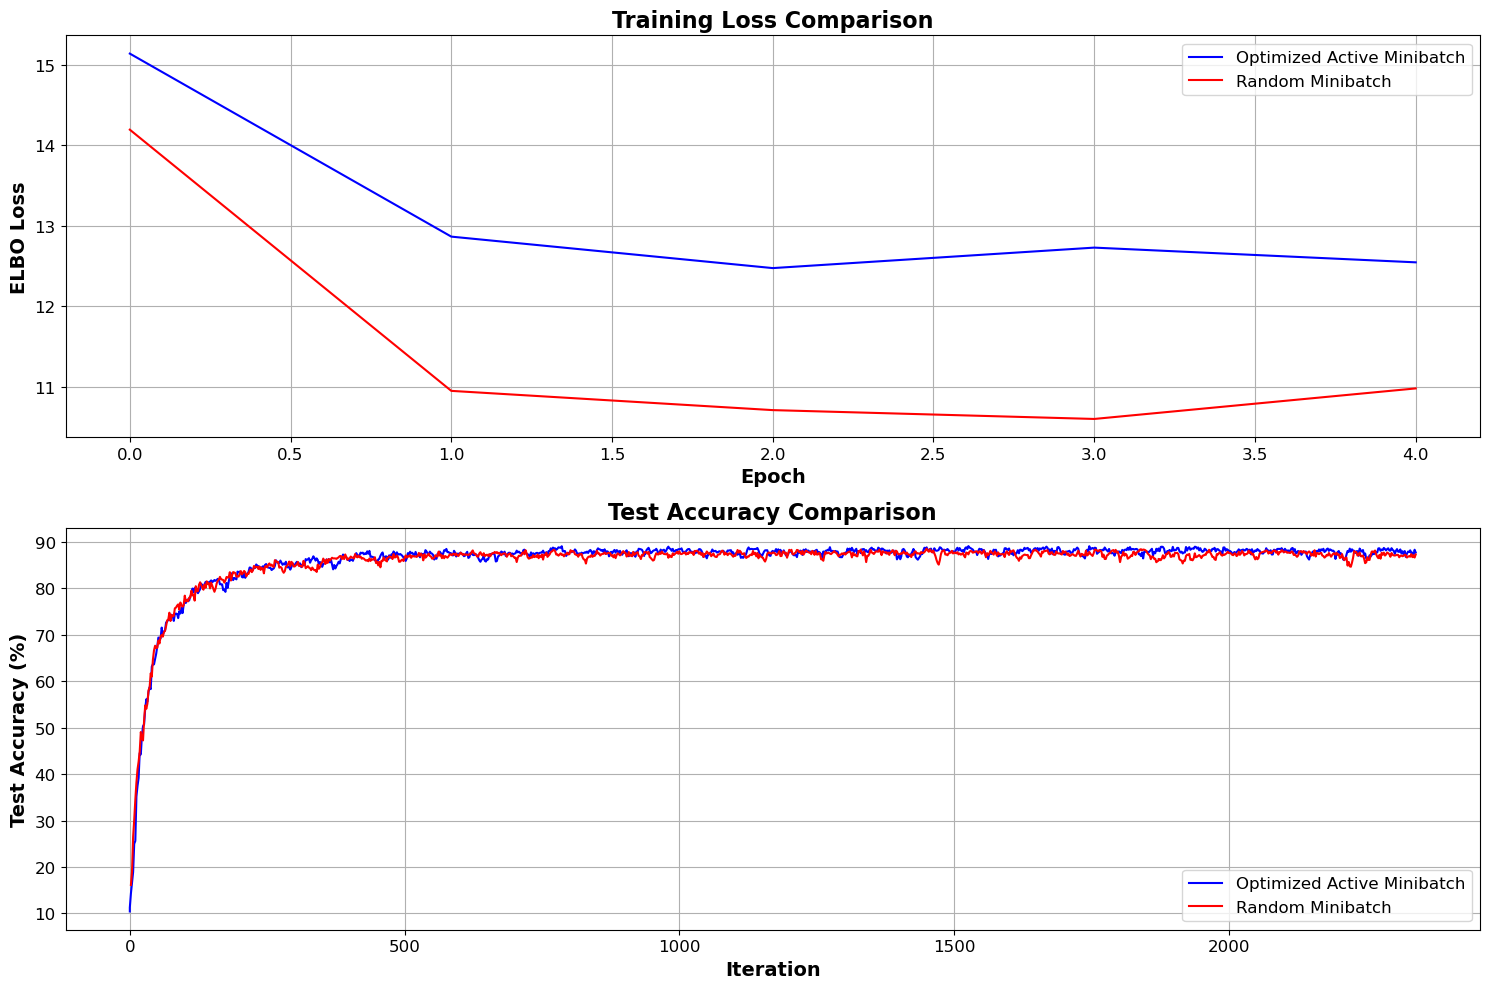

Sample Usage Statistics:
  - Min usage: 1
  - Max usage: 26
  - Mean usage: 9.98
  - Never used: 0 samples (0.00%)


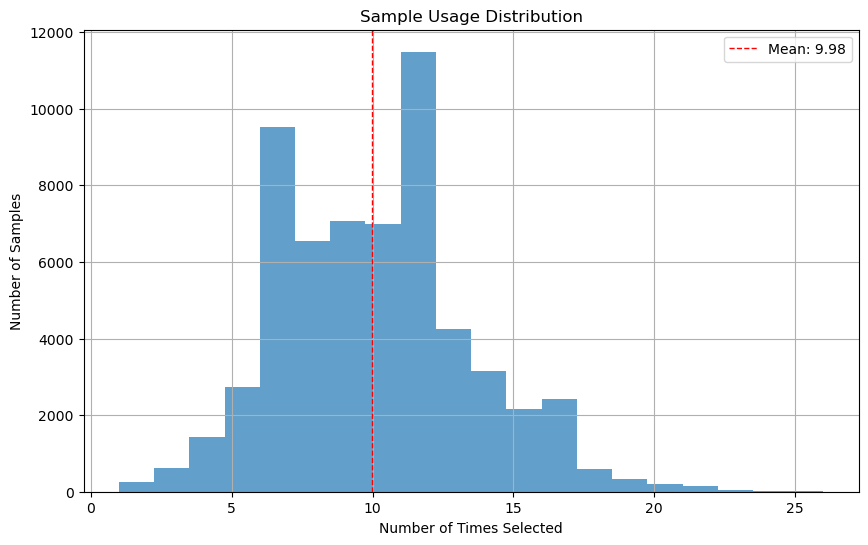

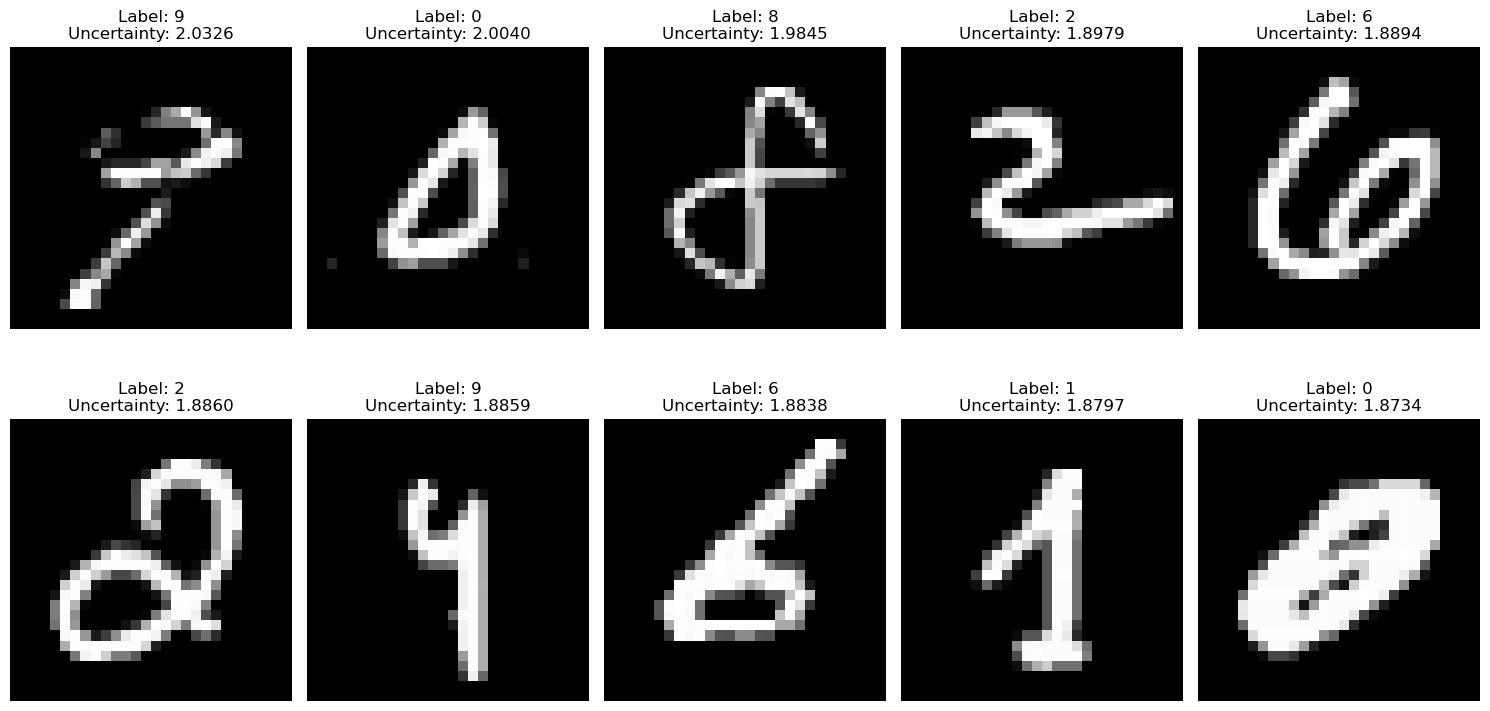


Done!


In [6]:


# Plot comparison of methods
plot_comparison(
    active_losses, random_losses,
    active_accuracies, random_accuracies
)

# Restore active model for visualization
pyro.clear_param_store()
for name, param in active_model_params.items():
    pyro.param(name, param)

# Compute final uncertainties
all_data = torch.stack([active_dataset[i][0] for i in range(len(active_dataset))]).to(device)
uncertainties = compute_bayesian_uncertainty(
    model, guide, all_data, num_samples=10, uncertainty_type='entropy'
)
active_dataset.update_uncertainties(uncertainties.cpu())

# Analyze dataset usage patterns
analyze_dataset_usage(active_dataset)

# Visualize most uncertain samples
visualize_uncertain_samples(active_dataset)

print("\nDone!")